In [1]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
import keras
from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Useful Functions

In [2]:
#Function to normalize columns
def normalize_numeric_minmax(df, name):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
    

In [3]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
import collections
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [4]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


In [266]:
def to_sequences(seq_size, data, label):
    x = []
    y = []

    for i in range(len(data)-seq_size-1):
        print(i)
        window = data[i:(i+seq_size)].values
        after_window = label[i+seq_size]
        #window = [[x] for x in window]
        print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

# Data Pre-Processing

In [397]:
#Read Stock_Price_MAX.csv file and load data into stock_df dataframe 
stock_df= pd.read_csv('Stock_Price_MAX.csv')
stock_df

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600
5,2000/4/3,3.500000,3.703125,3.437500,3.437500,3.437500,11486800
6,2000/4/4,3.531250,3.578125,3.093750,3.500000,3.500000,13136800
7,2000/4/5,3.468750,3.562500,3.453125,3.484375,3.484375,6349600
8,2000/4/6,3.500000,3.593750,3.468750,3.578125,3.578125,7181200
9,2000/4/7,3.593750,3.812500,3.593750,3.609375,3.609375,13904800


In [398]:
stock_df = stock_df.drop(['Date', 'Adj_Close'], axis = 1)
stock_df

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600
5,3.500000,3.703125,3.437500,3.437500,11486800
6,3.531250,3.578125,3.093750,3.500000,13136800
7,3.468750,3.562500,3.453125,3.484375,6349600
8,3.500000,3.593750,3.468750,3.578125,7181200
9,3.593750,3.812500,3.593750,3.609375,13904800


In [399]:
# Normalize the input columns
    
normalize_numeric_minmax(stock_df,"Open")
normalize_numeric_minmax(stock_df,"High") 
normalize_numeric_minmax(stock_df,"Low") 
normalize_numeric_minmax(stock_df,"Volume") 
stock_df

,Open,High,Low,Close,Volume
0,0.004378,0.006469,0.006934,4.125000,0.075401
1,0.007031,0.006205,0.008535,4.015625,0.019194
2,0.005970,0.005413,0.008135,4.000000,0.005339
3,0.005970,0.005149,0.007201,3.843750,0.036632
4,0.003714,0.002904,0.003334,3.390625,0.167478
5,0.001725,0.002640,0.003734,3.437500,0.244393
6,0.001990,0.001584,0.000800,3.500000,0.280091
7,0.001459,0.001452,0.003867,3.484375,0.133252
8,0.001725,0.001716,0.004001,3.578125,0.151243
9,0.002521,0.003564,0.005067,3.609375,0.296706


In [281]:
# to xy to convert pandas to tensor flow
x,y=to_xy(stock_df,"Close")

# Fully Connected Neural Network

In [9]:
#Split for train and test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [10]:
x_train.shape

(3074, 4)

In [11]:
x_test.shape

(1318, 4)

In [12]:
y_train.shape

(3074,)

In [13]:
y_test.shape

(1318,)

## ReLU

### ReLU, adam, 2 layers, early stopping and Model checkpoint  - score_relu_2l

In [14]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_2l.hdf5", verbose=1, save_best_only=True)

In [15]:
# relu adam 2 layers
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()
    model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu')) 
    model_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_2l.hdf5')


0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 0s - loss: 1781.2827 - val_loss: 1496.9032

Epoch 00001: val_loss improved from inf to 1496.90321, saving model to ./best_weights_relu_2l.hdf5
Epoch 2/100
 - 0s - loss: 1022.3711 - val_loss: 396.7310

Epoch 00002: val_loss improved from 1496.90321 to 396.73099, saving model to ./best_weights_relu_2l.hdf5
Epoch 3/100
 - 0s - loss: 221.9172 - val_loss: 132.8762

Epoch 00003: val_loss improved from 396.73099 to 132.87618, saving model to ./best_weights_relu_2l.hdf5
Epoch 4/100
 - 0s - loss: 68.8028 - val_loss: 19.6692

Epoch 00004: val_loss improved from 132.87618 to 19.66923, saving model to ./best_weights_relu_2l.hdf5
Epoch 5/100
 - 0s - loss: 4.7612 - val_loss: 0.3389

Epoch 00005: val_loss improved from 19.66923 to 0.33891, saving model to ./best_weights_relu_2l.hdf5
Epoch 6/100
 - 0s - loss: 0.2521 - val_loss: 0.1790

Epoch 00006: val_loss improved from 0.33891 to 0.17896, saving model to ./best_weights_relu_2l.hdf5
Epo


Epoch 00012: val_loss did not improve from 0.14931
Epoch 13/100
 - 0s - loss: 0.1728 - val_loss: 0.1560

Epoch 00013: val_loss did not improve from 0.14931
Epoch 14/100
 - 0s - loss: 0.1720 - val_loss: 0.1580

Epoch 00014: val_loss did not improve from 0.14931
Epoch 15/100
 - 0s - loss: 0.1746 - val_loss: 0.1540

Epoch 00015: val_loss did not improve from 0.14931
Epoch 16/100
 - 0s - loss: 0.1718 - val_loss: 0.1746

Epoch 00016: val_loss did not improve from 0.14931
Epoch 17/100
 - 0s - loss: 0.1872 - val_loss: 0.1556

Epoch 00017: val_loss did not improve from 0.14931
Epoch 18/100
 - 0s - loss: 0.1734 - val_loss: 0.1615

Epoch 00018: val_loss did not improve from 0.14931
Epoch 19/100
 - 0s - loss: 0.1743 - val_loss: 0.1568

Epoch 00019: val_loss did not improve from 0.14931
Epoch 20/100
 - 0s - loss: 0.1717 - val_loss: 0.1573

Epoch 00020: val_loss did not improve from 0.14931
Epoch 00020: early stopping
4
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 0s - loss: 1709


Epoch 00008: val_loss did not improve from 0.14511
Epoch 9/100
 - 0s - loss: 0.1787 - val_loss: 0.1763

Epoch 00009: val_loss did not improve from 0.14511
Epoch 10/100
 - 0s - loss: 0.1744 - val_loss: 0.1581

Epoch 00010: val_loss did not improve from 0.14511
Epoch 11/100
 - 0s - loss: 0.1714 - val_loss: 0.1575

Epoch 00011: val_loss did not improve from 0.14511
Epoch 12/100
 - 0s - loss: 0.1692 - val_loss: 0.1561

Epoch 00012: val_loss did not improve from 0.14511
Epoch 13/100
 - 0s - loss: 0.1682 - val_loss: 0.1594

Epoch 00013: val_loss did not improve from 0.14511
Epoch 14/100
 - 0s - loss: 0.1703 - val_loss: 0.1527

Epoch 00014: val_loss did not improve from 0.14511
Epoch 15/100
 - 0s - loss: 0.1689 - val_loss: 0.1516

Epoch 00015: val_loss did not improve from 0.14511
Epoch 16/100
 - 0s - loss: 0.1698 - val_loss: 0.1560

Epoch 00016: val_loss did not improve from 0.14511
Epoch 17/100
 - 0s - loss: 0.1713 - val_loss: 0.1516

Epoch 00017: val_loss did not improve from 0.14511
Epoc

In [16]:
# Predict stars
pred_relu_2l = model_relu.predict(x_test)
print("Shape: {}".format(pred_relu_2l.shape))


Shape: (1318, 1)


In [17]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_2l = np.sqrt(mean_squared_error(y_test,pred_relu_2l))
print("Final score (RMSE): {}".format(score_relu_2l))
print('R2 score: %.2f' % r2_score(y_test, pred_relu_2l))

Final score (RMSE): 0.3809351623058319
R2 score: 1.00


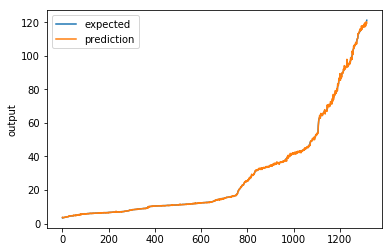

In [18]:
#Regression lift Chart
chart_regression(pred_relu_2l.flatten(),y_test)

### ReLU, adam, 3 layer, early stopping and Model checkpoint  - score_relu_3l

In [19]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adam3l.hdf5", verbose=1, save_best_only=True)

In [20]:
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()
    model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu')) 
    model_relu.add(Dense(30, activation='relu')) # Hidden 3
    model_relu.add(Dense(10, activation='relu')) # Hidden 2
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_adam3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 1s - loss: 1707.7021 - val_loss: 1157.7113

Epoch 00001: val_loss improved from inf to 1157.71135, saving model to ./best_weights_relu_adam3l.hdf5
Epoch 2/100
 - 0s - loss: 436.7299 - val_loss: 123.4597

Epoch 00002: val_loss improved from 1157.71135 to 123.45974, saving model to ./best_weights_relu_adam3l.hdf5
Epoch 3/100
 - 0s - loss: 58.2929 - val_loss: 16.0899

Epoch 00003: val_loss improved from 123.45974 to 16.08986, saving model to ./best_weights_relu_adam3l.hdf5
Epoch 4/100
 - 0s - loss: 4.3082 - val_loss: 0.2508

Epoch 00004: val_loss improved from 16.08986 to 0.25080, saving model to ./best_weights_relu_adam3l.hdf5
Epoch 5/100
 - 0s - loss: 0.2374 - val_loss: 0.2078

Epoch 00005: val_loss improved from 0.25080 to 0.20776, saving model to ./best_weights_relu_adam3l.hdf5
Epoch 6/100
 - 0s - loss: 0.2103 - val_loss: 0.1893

Epoch 00006: val_loss improved from 0.20776 to 0.18933, saving model to ./best_weights_relu_

 - 0s - loss: 62.0930 - val_loss: 12.3828

Epoch 00003: val_loss did not improve from 0.13757
Epoch 4/100
 - 0s - loss: 2.5209 - val_loss: 0.1670

Epoch 00004: val_loss did not improve from 0.13757
Epoch 5/100
 - 0s - loss: 0.1755 - val_loss: 0.1586

Epoch 00005: val_loss did not improve from 0.13757
Epoch 6/100
 - 0s - loss: 0.1668 - val_loss: 0.1549

Epoch 00006: val_loss did not improve from 0.13757
Epoch 7/100
 - 0s - loss: 0.1694 - val_loss: 0.1552

Epoch 00007: val_loss did not improve from 0.13757
Epoch 8/100
 - 0s - loss: 0.1665 - val_loss: 0.1510

Epoch 00008: val_loss did not improve from 0.13757
Epoch 9/100
 - 0s - loss: 0.1642 - val_loss: 0.1508

Epoch 00009: val_loss did not improve from 0.13757
Epoch 10/100
 - 0s - loss: 0.1668 - val_loss: 0.1490

Epoch 00010: val_loss did not improve from 0.13757
Epoch 11/100
 - 0s - loss: 0.1767 - val_loss: 0.1495

Epoch 00011: val_loss did not improve from 0.13757
Epoch 12/100
 - 0s - loss: 0.1634 - val_loss: 0.1610

Epoch 00012: val_l

 - 0s - loss: 0.1706 - val_loss: 0.1539

Epoch 00016: val_loss did not improve from 0.13757
Epoch 17/100
 - 0s - loss: 0.1653 - val_loss: 0.1618

Epoch 00017: val_loss did not improve from 0.13757
Epoch 18/100
 - 0s - loss: 0.1719 - val_loss: 0.1961

Epoch 00018: val_loss did not improve from 0.13757
Epoch 19/100
 - 0s - loss: 0.1673 - val_loss: 0.1475

Epoch 00019: val_loss did not improve from 0.13757
Epoch 00019: early stopping
8
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 1s - loss: 1793.4711 - val_loss: 1525.9430

Epoch 00001: val_loss did not improve from 0.13757
Epoch 2/100
 - 0s - loss: 914.1783 - val_loss: 237.0061

Epoch 00002: val_loss did not improve from 0.13757
Epoch 3/100
 - 0s - loss: 147.2155 - val_loss: 76.3792

Epoch 00003: val_loss did not improve from 0.13757
Epoch 4/100
 - 0s - loss: 32.0973 - val_loss: 5.4565

Epoch 00004: val_loss did not improve from 0.13757
Epoch 5/100
 - 0s - loss: 1.2080 - val_loss: 0.2623

Epoch 00005: val_loss did not im

In [21]:
# Predict stars
pred_hl_3 = model_relu.predict(x_test)

In [22]:
# Measure RMSE error.  RMSE is common for regression.
score_3l = np.sqrt(mean_squared_error(y_test,pred_hl_3))
print("Final score (RMSE): {}".format(score_3l))
print('R2 score: %.2f' % r2_score(y_test, pred_hl_3))

Final score (RMSE): 0.3709031045436859
R2 score: 1.00


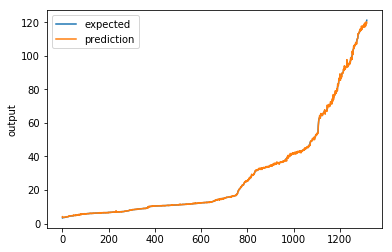

In [23]:
#Regression lift Chart
chart_regression(pred_hl_3.flatten(),y_test)

### ReLU, adam, 4 layer, early stopping and Model checkpoint  - score_relu_4l

In [24]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adam4l.hdf5", verbose=1, save_best_only=True)

In [25]:
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(80, input_dim=x_train.shape[1], activation='relu'))  
    model_relu.add(Dense(60, activation='relu')) # Hidden 2
    model_relu.add(Dense(20, activation='relu')) # Hidden 3
    model_relu.add(Dense(10, activation='relu')) # Hidden 4
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_adam4l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 1s - loss: 1337.5278 - val_loss: 202.6072

Epoch 00001: val_loss improved from inf to 202.60723, saving model to ./best_weights_relu_adam4l.hdf5
Epoch 2/100
 - 0s - loss: 70.1906 - val_loss: 0.2057

Epoch 00002: val_loss improved from 202.60723 to 0.20575, saving model to ./best_weights_relu_adam4l.hdf5
Epoch 3/100
 - 0s - loss: 0.2173 - val_loss: 0.1572

Epoch 00003: val_loss improved from 0.20575 to 0.15718, saving model to ./best_weights_relu_adam4l.hdf5
Epoch 4/100
 - 0s - loss: 0.1704 - val_loss: 0.1488

Epoch 00004: val_loss improved from 0.15718 to 0.14881, saving model to ./best_weights_relu_adam4l.hdf5
Epoch 5/100
 - 0s - loss: 0.1609 - val_loss: 0.1473

Epoch 00005: val_loss improved from 0.14881 to 0.14735, saving model to ./best_weights_relu_adam4l.hdf5
Epoch 6/100
 - 0s - loss: 0.1594 - val_loss: 0.1515

Epoch 00006: val_loss did not improve from 0.14735
Epoch 7/100
 - 0s - loss: 0.1641 - val_loss: 0.1438

Ep

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 1s - loss: 1182.9475 - val_loss: 156.7611

Epoch 00001: val_loss did not improve from 0.14363
Epoch 2/100
 - 0s - loss: 43.7931 - val_loss: 0.1973

Epoch 00002: val_loss did not improve from 0.14363
Epoch 3/100
 - 0s - loss: 0.2034 - val_loss: 0.1717

Epoch 00003: val_loss did not improve from 0.14363
Epoch 4/100
 - 0s - loss: 0.1824 - val_loss: 0.1603

Epoch 00004: val_loss did not improve from 0.14363
Epoch 5/100
 - 0s - loss: 0.1721 - val_loss: 0.1612

Epoch 00005: val_loss did not improve from 0.14363
Epoch 6/100
 - 0s - loss: 0.1772 - val_loss: 0.1542

Epoch 00006: val_loss did not improve from 0.14363
Epoch 7/100
 - 0s - loss: 0.1751 - val_loss: 0.1630

Epoch 00007: val_loss did not improve from 0.14363
Epoch 8/100
 - 0s - loss: 0.1766 - val_loss: 0.1550

Epoch 00008: val_loss did not improve from 0.14363
Epoch 9/100
 - 0s - loss: 0.1773 - val_loss: 0.1674

Epoch 00009: val_loss did not improve from 0.14363
Epoch 10/1

 - 0s - loss: 0.2158 - val_loss: 0.1843

Epoch 00007: val_loss did not improve from 0.14363
Epoch 8/100
 - 0s - loss: 0.1996 - val_loss: 0.1899

Epoch 00008: val_loss did not improve from 0.14363
Epoch 9/100
 - 0s - loss: 0.1912 - val_loss: 0.1745

Epoch 00009: val_loss did not improve from 0.14363
Epoch 10/100
 - 0s - loss: 0.1878 - val_loss: 0.1983

Epoch 00010: val_loss did not improve from 0.14363
Epoch 11/100
 - 0s - loss: 0.2058 - val_loss: 0.1662

Epoch 00011: val_loss did not improve from 0.14363
Epoch 12/100
 - 0s - loss: 0.1894 - val_loss: 0.1683

Epoch 00012: val_loss did not improve from 0.14363
Epoch 13/100
 - 0s - loss: 0.1868 - val_loss: 0.1831

Epoch 00013: val_loss did not improve from 0.14363
Epoch 14/100
 - 0s - loss: 0.1890 - val_loss: 0.1809

Epoch 00014: val_loss did not improve from 0.14363
Epoch 15/100
 - 0s - loss: 0.1854 - val_loss: 0.1923

Epoch 00015: val_loss did not improve from 0.14363
Epoch 16/100
 - 0s - loss: 0.1942 - val_loss: 0.1715

Epoch 00016: val

In [26]:
# Predict stars
pred_hl4 = model_relu.predict(x_test)

In [27]:
# Measure RMSE error.  RMSE is common for regression.
score_4l = np.sqrt(mean_squared_error(y_test,pred_hl4))
print("Final score (RMSE): {}".format(score_4l))
print('R2 score: %.2f' % r2_score(y_test, pred_hl4))

Final score (RMSE): 0.3789813816547394
R2 score: 1.00


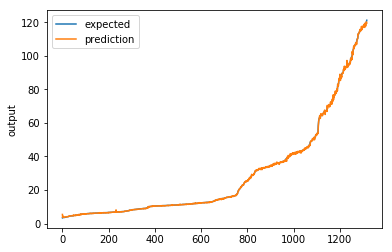

In [28]:
#Regression lift Chart
chart_regression(pred_hl4.flatten(),y_test)

### ReLU, adam, 4 layer and dropout - score_relu_4l_do

In [29]:
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(80, input_dim=x_train.shape[1]))  
    model_relu.add(Dropout(0.1))
    model_relu.add(Dense(60, activation='relu')) # Hidden 2
    model_relu.add(Dense(20, activation='relu')) # Hidden 3
    model_relu.add(Dense(10, activation='relu')) # Hidden 4
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 1007.8982 - val_loss: 77.6608
Epoch 2/100
 - 0s - loss: 22.7313 - val_loss: 0.3971
Epoch 3/100
 - 0s - loss: 3.3546 - val_loss: 0.2795
Epoch 4/100
 - 0s - loss: 3.0226 - val_loss: 0.2605
Epoch 5/100
 - 0s - loss: 3.3476 - val_loss: 0.2725
Epoch 6/100
 - 0s - loss: 3.1914 - val_loss: 0.6456
Epoch 7/100
 - 0s - loss: 3.1916 - val_loss: 0.1934
Epoch 8/100
 - 0s - loss: 3.1659 - val_loss: 0.1575
Epoch 9/100
 - 0s - loss: 3.3258 - val_loss: 0.1962
Epoch 10/100
 - 0s - loss: 3.4377 - val_loss: 0.7267
Epoch 11/100
 - 0s - loss: 2.9686 - val_loss: 0.3799
Epoch 12/100
 - 0s - loss: 3.0911 - val_loss: 0.1798
Epoch 13/100
 - 0s - loss: 2.8314 - val_loss: 0.2871
Epoch 00013: early stopping


In [30]:
# Predict stars
pred_hl4_do = model_relu.predict(x_test)

In [31]:
# Measure RMSE error.  RMSE is common for regression.
score_4l_do = np.sqrt(mean_squared_error(y_test,pred_hl4_do))
print("Final score (RMSE): {}".format(score_4l_do))
print('R2 score: %.2f' % r2_score(y_test, pred_hl4_do))

Final score (RMSE): 0.5358445644378662
R2 score: 1.00


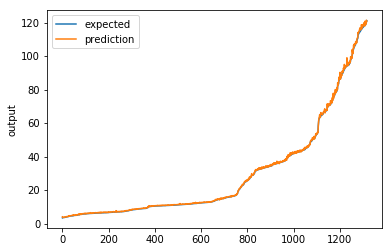

In [32]:
#Regression lift Chart
chart_regression(pred_hl4_do.flatten(),y_test)

### ReLU, sgd, 3 layers, early stopping and Model checkpoint  - score_relu_3l

In [33]:
# set up checkpoinAter
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_sgd3l.hdf5", verbose=1, save_best_only=True)

In [34]:
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))  
    model_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_sgd3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 1s - loss: 4082.1329 - val_loss: 894.5143

Epoch 00001: val_loss improved from inf to 894.51427, saving model to ./best_weights_relu_sgd3l.hdf5
Epoch 2/100
 - 0s - loss: 894.5117 - val_loss: 895.5806

Epoch 00002: val_loss did not improve from 894.51427
Epoch 3/100
 - 0s - loss: 893.7588 - val_loss: 895.1592

Epoch 00003: val_loss did not improve from 894.51427
Epoch 4/100
 - 0s - loss: 893.9408 - val_loss: 896.0229

Epoch 00004: val_loss did not improve from 894.51427
Epoch 5/100
 - 0s - loss: 893.5072 - val_loss: 897.0486

Epoch 00005: val_loss did not improve from 894.51427
Epoch 6/100
 - 0s - loss: 893.6691 - val_loss: 896.0128

Epoch 00006: val_loss did not improve from 894.51427
Epoch 00006: early stopping
1
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 67820.4541 - val_loss: 911.3711

Epoch 00001: val_loss did not improve from 894.51427
Epoch 2/100
 - 0s - loss: 895.5387 - val_loss: 897.


Epoch 00008: val_loss did not improve from 894.51427
Epoch 00008: early stopping
7
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 82743292177521712.0000 - val_loss: 101521776010198.0469

Epoch 00001: val_loss did not improve from 894.51427
Epoch 2/100
 - 0s - loss: 26137276497376.3555 - val_loss: 2015667755924.7830

Epoch 00002: val_loss did not improve from 894.51427
Epoch 3/100
 - 0s - loss: 518942646282.6597 - val_loss: 40020580448.3399

Epoch 00003: val_loss did not improve from 894.51427
Epoch 4/100
 - 0s - loss: 10303352444.0026 - val_loss: 794672614.0698

Epoch 00004: val_loss did not improve from 894.51427
Epoch 5/100
 - 0s - loss: 204562853.1165 - val_loss: 15787843.0516

Epoch 00005: val_loss did not improve from 894.51427
Epoch 6/100
 - 0s - loss: 4062355.2931 - val_loss: 315582.5744

Epoch 00006: val_loss did not improve from 894.51427
Epoch 7/100
 - 0s - loss: 81524.1126 - val_loss: 7295.0805

Epoch 00007: val_loss did not improve from 894.51427

In [35]:
# Predict stars
pred_relu_3l_sgd = model_relu.predict(x_test)
print("Shape: {}".format(pred_relu_3l_sgd.shape))

Shape: (1318, 1)


In [36]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_3l_sgd = np.sqrt(mean_squared_error(y_test,pred_relu_3l_sgd))
print("Final score (RMSE): {}".format(score_relu_3l_sgd))
print('R2 score: %.2f' % r2_score(y_test, pred_relu_3l_sgd))

Final score (RMSE): 29.908430099487305
R2 score: -0.00


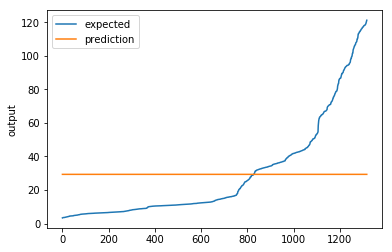

In [37]:
#Regression lift Chart
chart_regression(pred_relu_3l_sgd.flatten(),y_test)

### ReLU, sgd, 3 layer and dropout - score_relu_3l_do

In [38]:
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(50, input_dim=x_train.shape[1]))  
    model_relu.add(Dropout(0.1))
    model_relu.add(Dense(25, activation='relu')) # Hidden 2
    model_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 1140.0804 - val_loss: 902.6569
Epoch 2/100
 - 0s - loss: 899.0324 - val_loss: 895.0152
Epoch 3/100
 - 0s - loss: 893.8640 - val_loss: 895.3747
Epoch 4/100
 - 0s - loss: 893.8114 - val_loss: 895.8812
Epoch 5/100
 - 0s - loss: 893.8151 - val_loss: 896.7847
Epoch 6/100
 - 0s - loss: 893.8894 - val_loss: 896.4157
Epoch 7/100
 - 0s - loss: 893.6785 - val_loss: 900.7824
Epoch 00007: early stopping


In [39]:
# Predict stars
pred_hl3_do = model_relu.predict(x_test)

In [40]:
# Measure RMSE error.  RMSE is common for regression.
score_3l_do = np.sqrt(mean_squared_error(y_test,pred_hl3_do))
print("Final score (RMSE): {}".format(score_3l_do))
print('R2 score: %.2f' % r2_score(y_test, pred_hl3_do))

Final score (RMSE): 30.013036727905273
R2 score: -0.01


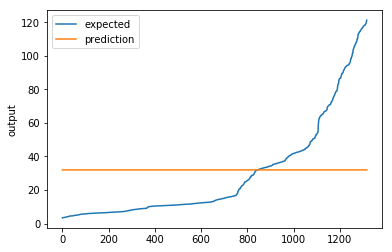

In [41]:
#Regression lift Chart
chart_regression(pred_hl3_do.flatten(),y_test)

### ReLU, rmsprop, 3 layers, early stopping and Model checkpoint  - score_relu_3l_rms

In [42]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_rms3l.hdf5", verbose=1, save_best_only=True)

In [43]:
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))  
    model_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_rms3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 1271.8332 - val_loss: 436.0490

Epoch 00001: val_loss improved from inf to 436.04901, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 2/100
 - 0s - loss: 163.1192 - val_loss: 26.9865

Epoch 00002: val_loss improved from 436.04901 to 26.98651, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 3/100
 - 0s - loss: 4.2603 - val_loss: 0.2380

Epoch 00003: val_loss improved from 26.98651 to 0.23797, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 4/100
 - 0s - loss: 0.4040 - val_loss: 0.4615

Epoch 00004: val_loss did not improve from 0.23797
Epoch 5/100
 - 0s - loss: 0.3457 - val_loss: 0.3009

Epoch 00005: val_loss did not improve from 0.23797
Epoch 6/100
 - 0s - loss: 0.3723 - val_loss: 0.1690

Epoch 00006: val_loss improved from 0.23797 to 0.16901, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 7/100
 - 0s - loss: 0.3660 - val_loss: 0.2392

Epoch 00007: val_loss did not improve from 0.16901
Epoc

 - 0s - loss: 0.3389 - val_loss: 0.2044

Epoch 00005: val_loss did not improve from 0.14790
Epoch 6/100
 - 0s - loss: 0.2665 - val_loss: 0.4694

Epoch 00006: val_loss did not improve from 0.14790
Epoch 7/100
 - 0s - loss: 0.2805 - val_loss: 0.1488

Epoch 00007: val_loss did not improve from 0.14790
Epoch 8/100
 - 0s - loss: 0.2573 - val_loss: 0.1490

Epoch 00008: val_loss did not improve from 0.14790
Epoch 9/100
 - 0s - loss: 0.2647 - val_loss: 0.2214

Epoch 00009: val_loss did not improve from 0.14790
Epoch 10/100
 - 0s - loss: 0.2576 - val_loss: 0.2822

Epoch 00010: val_loss did not improve from 0.14790
Epoch 11/100
 - 0s - loss: 0.2478 - val_loss: 0.3132

Epoch 00011: val_loss did not improve from 0.14790
Epoch 12/100
 - 0s - loss: 0.2547 - val_loss: 0.6003

Epoch 00012: val_loss did not improve from 0.14790
Epoch 00012: early stopping
6
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 1770.4963 - val_loss: 1535.9635

Epoch 00001: val_loss did not improve fr

 - 0s - loss: 0.3562 - val_loss: 0.1678

Epoch 00015: val_loss did not improve from 0.14278
Epoch 16/100
 - 0s - loss: 0.3220 - val_loss: 1.8357

Epoch 00016: val_loss did not improve from 0.14278
Epoch 17/100
 - 0s - loss: 0.3430 - val_loss: 0.1456

Epoch 00017: val_loss did not improve from 0.14278
Epoch 18/100
 - 0s - loss: 0.3530 - val_loss: 0.1460

Epoch 00018: val_loss did not improve from 0.14278
Epoch 19/100
 - 0s - loss: 0.3345 - val_loss: 0.1460

Epoch 00019: val_loss did not improve from 0.14278
Epoch 20/100
 - 0s - loss: 0.3258 - val_loss: 0.1623

Epoch 00020: val_loss did not improve from 0.14278
Epoch 21/100
 - 0s - loss: 0.3346 - val_loss: 0.3208

Epoch 00021: val_loss did not improve from 0.14278
Epoch 22/100
 - 0s - loss: 0.3521 - val_loss: 4.8800

Epoch 00022: val_loss did not improve from 0.14278
Epoch 00022: early stopping
Training finished...Loading the best model



In [44]:
# Predict stars
pred_relu_3l_rms = model_relu.predict(x_test)
print("Shape: {}".format(pred_relu_3l_rms.shape))


Shape: (1318, 1)


In [45]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_3l_rms = np.sqrt(mean_squared_error(y_test,pred_relu_3l_rms))
print("Final score (RMSE): {}".format(score_relu_3l_rms))
print('R2 score: %.2f' % r2_score(y_test, pred_relu_3l_rms))

Final score (RMSE): 0.37786445021629333
R2 score: 1.00


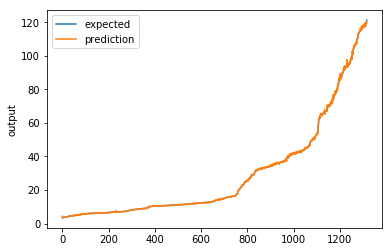

In [46]:
#Regression lift Chart
chart_regression(pred_relu_3l_rms.flatten(),y_test)

### ReLU, rmsprop, 3 layer and dropout - score_relu_3l_do

In [47]:
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(50, input_dim=x_train.shape[1]))  
    model_relu.add(Dropout(0.1))
    model_relu.add(Dense(25, activation='relu')) # Hidden 2
    model_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 1426.2966 - val_loss: 679.2742
Epoch 2/100
 - 0s - loss: 248.7219 - val_loss: 54.8069
Epoch 3/100
 - 0s - loss: 18.5531 - val_loss: 0.3808
Epoch 4/100
 - 0s - loss: 5.2844 - val_loss: 0.2391
Epoch 5/100
 - 0s - loss: 4.7590 - val_loss: 0.2521
Epoch 6/100
 - 0s - loss: 4.6149 - val_loss: 0.3069
Epoch 7/100
 - 0s - loss: 4.7984 - val_loss: 1.4264
Epoch 8/100
 - 0s - loss: 4.7782 - val_loss: 3.4112
Epoch 9/100
 - 0s - loss: 4.6562 - val_loss: 0.4013
Epoch 00009: early stopping


In [48]:
# Predict stars
pred_hl3_rms_do = model_relu.predict(x_test)

In [49]:
# Measure RMSE error.  RMSE is common for regression.
score_3l_rms_do = np.sqrt(mean_squared_error(y_test,pred_hl3_rms_do))
print("Final score (RMSE): {}".format(score_3l_rms_do))
print('R2 score: %.2f' % r2_score(y_test, pred_hl3_rms_do))

Final score (RMSE): 0.6334989070892334
R2 score: 1.00


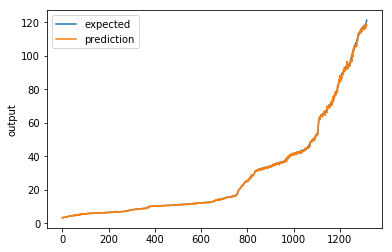

In [50]:
#Regression lift Chart
chart_regression(pred_hl3_rms_do.flatten(),y_test)

## Sigmoid

### Sigmoid, adam, 2 layers, early stopping and Model checkpoint  - score_sig_adam2l

In [51]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid_2l.hdf5", verbose=1, save_best_only=True)

In [52]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(120, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_sigmoid_2l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 1533.9613 - val_loss: 1301.5307

Epoch 00001: val_loss improved from inf to 1301.53068, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 2/100
 - 0s - loss: 1265.9295 - val_loss: 1129.1602

Epoch 00002: val_loss improved from 1301.53068 to 1129.16022, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 3/100
 - 0s - loss: 1113.5059 - val_loss: 1019.8139

Epoch 00003: val_loss improved from 1129.16022 to 1019.81387, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 4/100
 - 0s - loss: 1016.9961 - val_loss: 957.5051

Epoch 00004: val_loss improved from 1019.81387 to 957.50507, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 5/100
 - 0s - loss: 960.2586 - val_loss: 922.3001

Epoch 00005: val_loss improved from 957.50507 to 922.30006, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 6/100
 - 0s - loss: 927.3777 - val_loss: 904.5173

Epoch 00006: val_loss improved from 922.30006 to 904.51728, saving


Epoch 00051: val_loss improved from 2.54448 to 2.27038, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 52/100
 - 0s - loss: 2.0958 - val_loss: 1.9589

Epoch 00052: val_loss improved from 2.27038 to 1.95887, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 53/100
 - 0s - loss: 1.8236 - val_loss: 1.7642

Epoch 00053: val_loss improved from 1.95887 to 1.76420, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 54/100
 - 0s - loss: 1.6059 - val_loss: 1.5187

Epoch 00054: val_loss improved from 1.76420 to 1.51871, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 55/100
 - 0s - loss: 1.4233 - val_loss: 1.4015

Epoch 00055: val_loss improved from 1.51871 to 1.40152, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 56/100
 - 0s - loss: 1.2648 - val_loss: 1.2293

Epoch 00056: val_loss improved from 1.40152 to 1.22931, saving model to ./best_weights_sigmoid_2l.hdf5
Epoch 57/100
 - 0s - loss: 1.1315 - val_loss: 1.1110

Epoch 00057: val_loss improved from 1.22931 to 1.11096, s

 - 0s - loss: 34.3024 - val_loss: 31.1527

Epoch 00032: val_loss did not improve from 0.22391
Epoch 33/100
 - 0s - loss: 30.3951 - val_loss: 27.4403

Epoch 00033: val_loss did not improve from 0.22391
Epoch 34/100
 - 0s - loss: 26.8723 - val_loss: 24.2011

Epoch 00034: val_loss did not improve from 0.22391
Epoch 35/100
 - 0s - loss: 23.7785 - val_loss: 21.3456

Epoch 00035: val_loss did not improve from 0.22391
Epoch 36/100
 - 0s - loss: 21.0676 - val_loss: 18.9612

Epoch 00036: val_loss did not improve from 0.22391
Epoch 37/100
 - 0s - loss: 18.5912 - val_loss: 16.7056

Epoch 00037: val_loss did not improve from 0.22391
Epoch 38/100
 - 0s - loss: 16.4184 - val_loss: 14.7738

Epoch 00038: val_loss did not improve from 0.22391
Epoch 39/100
 - 0s - loss: 14.4856 - val_loss: 13.0676

Epoch 00039: val_loss did not improve from 0.22391
Epoch 40/100
 - 0s - loss: 12.7876 - val_loss: 11.5478

Epoch 00040: val_loss did not improve from 0.22391
Epoch 41/100
 - 0s - loss: 11.2939 - val_loss: 10.

 - 0s - loss: 130.0648 - val_loss: 120.4794

Epoch 00020: val_loss did not improve from 0.21191
Epoch 21/100
 - 0s - loss: 113.9444 - val_loss: 105.6631

Epoch 00021: val_loss did not improve from 0.21191
Epoch 22/100
 - 0s - loss: 99.4806 - val_loss: 92.0283

Epoch 00022: val_loss did not improve from 0.21191
Epoch 23/100
 - 0s - loss: 87.6960 - val_loss: 81.3077

Epoch 00023: val_loss did not improve from 0.21191
Epoch 24/100
 - 0s - loss: 77.6001 - val_loss: 71.6837

Epoch 00024: val_loss did not improve from 0.21191
Epoch 25/100
 - 0s - loss: 68.7555 - val_loss: 63.5178

Epoch 00025: val_loss did not improve from 0.21191
Epoch 26/100
 - 0s - loss: 61.0191 - val_loss: 56.1333

Epoch 00026: val_loss did not improve from 0.21191
Epoch 27/100
 - 0s - loss: 54.0364 - val_loss: 49.5393

Epoch 00027: val_loss did not improve from 0.21191
Epoch 28/100
 - 0s - loss: 47.7787 - val_loss: 43.5983

Epoch 00028: val_loss did not improve from 0.21191
Epoch 29/100
 - 0s - loss: 42.1336 - val_loss:

 - 0s - loss: 578.5563 - val_loss: 491.3472

Epoch 00011: val_loss did not improve from 0.21191
Epoch 12/100
 - 0s - loss: 446.9350 - val_loss: 395.6815

Epoch 00012: val_loss did not improve from 0.21191
Epoch 13/100
 - 0s - loss: 369.0447 - val_loss: 335.9357

Epoch 00013: val_loss did not improve from 0.21191
Epoch 14/100
 - 0s - loss: 316.0862 - val_loss: 289.8970

Epoch 00014: val_loss did not improve from 0.21191
Epoch 15/100
 - 0s - loss: 272.4789 - val_loss: 251.2782

Epoch 00015: val_loss did not improve from 0.21191
Epoch 16/100
 - 0s - loss: 236.5809 - val_loss: 219.4210

Epoch 00016: val_loss did not improve from 0.21191
Epoch 17/100
 - 0s - loss: 205.5277 - val_loss: 190.2252

Epoch 00017: val_loss did not improve from 0.21191
Epoch 18/100
 - 0s - loss: 179.7861 - val_loss: 166.2348

Epoch 00018: val_loss did not improve from 0.21191
Epoch 19/100
 - 0s - loss: 156.2960 - val_loss: 145.2128

Epoch 00019: val_loss did not improve from 0.21191
Epoch 20/100
 - 0s - loss: 137.0

Epoch 88/100
 - 0s - loss: 0.2402 - val_loss: 0.2284

Epoch 00088: val_loss did not improve from 0.20066
Epoch 89/100
 - 0s - loss: 0.2259 - val_loss: 0.2154

Epoch 00089: val_loss did not improve from 0.20066
Epoch 90/100
 - 0s - loss: 0.2224 - val_loss: 0.2033

Epoch 00090: val_loss did not improve from 0.20066
Epoch 00090: early stopping
4
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 1613.4516 - val_loss: 1378.8238

Epoch 00001: val_loss did not improve from 0.20066
Epoch 2/100
 - 0s - loss: 1360.0354 - val_loss: 1216.6827

Epoch 00002: val_loss did not improve from 0.20066
Epoch 3/100
 - 0s - loss: 1206.2753 - val_loss: 1097.3134

Epoch 00003: val_loss did not improve from 0.20066
Epoch 4/100
 - 0s - loss: 1096.6284 - val_loss: 1015.8324

Epoch 00004: val_loss did not improve from 0.20066
Epoch 5/100
 - 0s - loss: 1018.5034 - val_loss: 960.7043

Epoch 00005: val_loss did not improve from 0.20066
Epoch 6/100
 - 0s - loss: 964.1898 - val_loss: 925.1841

E

 - 1s - loss: 0.3918 - val_loss: 0.4121

Epoch 00074: val_loss did not improve from 0.20066
Epoch 75/100
 - 0s - loss: 0.3589 - val_loss: 0.3511

Epoch 00075: val_loss did not improve from 0.20066
Epoch 76/100
 - 0s - loss: 0.3462 - val_loss: 0.3553

Epoch 00076: val_loss did not improve from 0.20066
Epoch 77/100
 - 0s - loss: 0.3272 - val_loss: 0.3292

Epoch 00077: val_loss did not improve from 0.20066
Epoch 78/100
 - 0s - loss: 0.3118 - val_loss: 0.2988

Epoch 00078: val_loss did not improve from 0.20066
Epoch 79/100
 - 0s - loss: 0.3505 - val_loss: 0.3014

Epoch 00079: val_loss did not improve from 0.20066
Epoch 80/100
 - 0s - loss: 0.3502 - val_loss: 0.3721

Epoch 00080: val_loss did not improve from 0.20066
Epoch 81/100
 - 0s - loss: 0.2877 - val_loss: 0.2716

Epoch 00081: val_loss did not improve from 0.20066
Epoch 82/100
 - 0s - loss: 0.2724 - val_loss: 0.2667

Epoch 00082: val_loss did not improve from 0.20066
Epoch 83/100
 - 0s - loss: 0.2750 - val_loss: 0.2462

Epoch 00083: v

 - 0s - loss: 4.6084 - val_loss: 4.2675

Epoch 00051: val_loss did not improve from 0.17849
Epoch 52/100
 - 0s - loss: 4.1217 - val_loss: 3.7189

Epoch 00052: val_loss did not improve from 0.17849
Epoch 53/100
 - 0s - loss: 3.5402 - val_loss: 3.3038

Epoch 00053: val_loss did not improve from 0.17849
Epoch 54/100
 - 0s - loss: 3.1079 - val_loss: 2.8875

Epoch 00054: val_loss did not improve from 0.17849
Epoch 55/100
 - 0s - loss: 2.7271 - val_loss: 2.5877

Epoch 00055: val_loss did not improve from 0.17849
Epoch 56/100
 - 0s - loss: 2.3954 - val_loss: 2.3646

Epoch 00056: val_loss did not improve from 0.17849
Epoch 57/100
 - 0s - loss: 2.0985 - val_loss: 1.9679

Epoch 00057: val_loss did not improve from 0.17849
Epoch 58/100
 - 0s - loss: 1.8657 - val_loss: 1.7691

Epoch 00058: val_loss did not improve from 0.17849
Epoch 59/100
 - 0s - loss: 1.6366 - val_loss: 1.5315

Epoch 00059: val_loss did not improve from 0.17849
Epoch 60/100
 - 0s - loss: 1.4388 - val_loss: 1.3786

Epoch 00060: v


Epoch 00034: val_loss did not improve from 0.17849
Epoch 35/100
 - 0s - loss: 22.1554 - val_loss: 19.9056

Epoch 00035: val_loss did not improve from 0.17849
Epoch 36/100
 - 0s - loss: 19.6232 - val_loss: 17.7322

Epoch 00036: val_loss did not improve from 0.17849
Epoch 37/100
 - 0s - loss: 17.3954 - val_loss: 15.7052

Epoch 00037: val_loss did not improve from 0.17849
Epoch 38/100
 - 0s - loss: 15.4400 - val_loss: 13.9616

Epoch 00038: val_loss did not improve from 0.17849
Epoch 39/100
 - 0s - loss: 13.6532 - val_loss: 12.3650

Epoch 00039: val_loss did not improve from 0.17849
Epoch 40/100
 - 0s - loss: 12.0383 - val_loss: 10.8970

Epoch 00040: val_loss did not improve from 0.17849
Epoch 41/100
 - 0s - loss: 10.6187 - val_loss: 9.6564

Epoch 00041: val_loss did not improve from 0.17849
Epoch 42/100
 - 0s - loss: 9.4214 - val_loss: 8.5925

Epoch 00042: val_loss did not improve from 0.17849
Epoch 43/100
 - 0s - loss: 8.3561 - val_loss: 7.6364

Epoch 00043: val_loss did not improve fro

 - 0s - loss: 97.9488 - val_loss: 90.2684

Epoch 00021: val_loss did not improve from 0.17849
Epoch 22/100
 - 0s - loss: 85.4506 - val_loss: 78.7109

Epoch 00022: val_loss did not improve from 0.17849
Epoch 23/100
 - 0s - loss: 74.8495 - val_loss: 68.8348

Epoch 00023: val_loss did not improve from 0.17849
Epoch 24/100
 - 0s - loss: 65.7573 - val_loss: 60.3798

Epoch 00024: val_loss did not improve from 0.17849
Epoch 25/100
 - 0s - loss: 57.8564 - val_loss: 52.8855

Epoch 00025: val_loss did not improve from 0.17849
Epoch 26/100
 - 0s - loss: 50.4154 - val_loss: 45.9652

Epoch 00026: val_loss did not improve from 0.17849
Epoch 27/100
 - 0s - loss: 44.3506 - val_loss: 40.1969

Epoch 00027: val_loss did not improve from 0.17849
Epoch 28/100
 - 0s - loss: 38.8798 - val_loss: 35.3061

Epoch 00028: val_loss did not improve from 0.17849
Epoch 29/100
 - 0s - loss: 34.1161 - val_loss: 30.7787

Epoch 00029: val_loss did not improve from 0.17849
Epoch 30/100
 - 0s - loss: 29.8904 - val_loss: 26.

 - 0s - loss: 470.5180 - val_loss: 419.5079

Epoch 00012: val_loss did not improve from 0.17849
Epoch 13/100
 - 0s - loss: 392.9357 - val_loss: 358.5026

Epoch 00013: val_loss did not improve from 0.17849
Epoch 14/100
 - 0s - loss: 338.5159 - val_loss: 312.5165

Epoch 00014: val_loss did not improve from 0.17849
Epoch 15/100
 - 0s - loss: 295.7934 - val_loss: 274.0888

Epoch 00015: val_loss did not improve from 0.17849
Epoch 16/100
 - 0s - loss: 258.9895 - val_loss: 239.6156

Epoch 00016: val_loss did not improve from 0.17849
Epoch 17/100
 - 0s - loss: 227.2809 - val_loss: 211.0618

Epoch 00017: val_loss did not improve from 0.17849
Epoch 18/100
 - 0s - loss: 197.1631 - val_loss: 181.5644

Epoch 00018: val_loss did not improve from 0.17849
Epoch 19/100
 - 0s - loss: 170.9048 - val_loss: 157.9996

Epoch 00019: val_loss did not improve from 0.17849
Epoch 20/100
 - 0s - loss: 148.2332 - val_loss: 137.4324

Epoch 00020: val_loss did not improve from 0.17849
Epoch 21/100
 - 0s - loss: 130.1


Epoch 00089: val_loss did not improve from 0.17849
Epoch 90/100
 - 0s - loss: 0.2251 - val_loss: 0.1958

Epoch 00090: val_loss did not improve from 0.17849
Epoch 91/100
 - 0s - loss: 0.2223 - val_loss: 0.2074

Epoch 00091: val_loss did not improve from 0.17849
Epoch 92/100
 - 0s - loss: 0.2157 - val_loss: 0.1962

Epoch 00092: val_loss did not improve from 0.17849
Epoch 93/100
 - 0s - loss: 0.2176 - val_loss: 0.2000

Epoch 00093: val_loss did not improve from 0.17849
Epoch 00093: early stopping
9
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 3s - loss: 1523.9348 - val_loss: 1288.8474

Epoch 00001: val_loss did not improve from 0.17849
Epoch 2/100
 - 0s - loss: 1257.1747 - val_loss: 1123.5670

Epoch 00002: val_loss did not improve from 0.17849
Epoch 3/100
 - 0s - loss: 1109.3420 - val_loss: 1017.8620

Epoch 00003: val_loss did not improve from 0.17849
Epoch 4/100
 - 0s - loss: 1016.4955 - val_loss: 957.7631

Epoch 00004: val_loss did not improve from 0.17849
Epoch 5/100

 - 0s - loss: 0.4047 - val_loss: 0.4029

Epoch 00073: val_loss did not improve from 0.17849
Epoch 74/100
 - 0s - loss: 0.3607 - val_loss: 0.4182

Epoch 00074: val_loss did not improve from 0.17849
Epoch 75/100
 - 0s - loss: 0.3769 - val_loss: 0.3890

Epoch 00075: val_loss did not improve from 0.17849
Epoch 76/100
 - 0s - loss: 0.3276 - val_loss: 0.3114

Epoch 00076: val_loss did not improve from 0.17849
Epoch 77/100
 - 0s - loss: 0.3374 - val_loss: 0.3144

Epoch 00077: val_loss did not improve from 0.17849
Epoch 78/100
 - 0s - loss: 0.3201 - val_loss: 0.2966

Epoch 00078: val_loss did not improve from 0.17849
Epoch 79/100
 - 0s - loss: 0.2899 - val_loss: 0.2666

Epoch 00079: val_loss did not improve from 0.17849
Epoch 80/100
 - 0s - loss: 0.2770 - val_loss: 0.2587

Epoch 00080: val_loss did not improve from 0.17849
Epoch 81/100
 - 0s - loss: 0.2684 - val_loss: 0.2549

Epoch 00081: val_loss did not improve from 0.17849
Epoch 82/100
 - 0s - loss: 0.2608 - val_loss: 0.2798

Epoch 00082: v

In [53]:
# Predict stars
pred_sig_adam2l = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_adam2l.shape))

Shape: (1318, 1)


In [54]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_adam2l = np.sqrt(mean_squared_error(y_test,pred_sig_adam2l))
print("Final score (RMSE): {}".format(score_sig_adam2l))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_adam2l))

Final score (RMSE): 0.4224771559238434
R2 score: 1.00


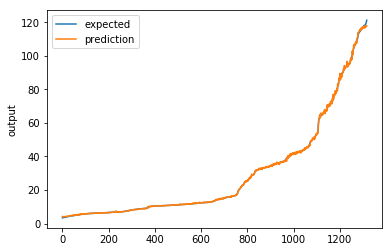

In [55]:
#Regression lift Chart
chart_regression(pred_sig_adam2l.flatten(),y_test)

### Sigmoid, adam, 3 layers, early stopping and Model checkpoint  - score_sig_adam3l

In [56]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid_adam3l.hdf5", verbose=1, save_best_only=True)

In [57]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(120, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_sigmoid_adam3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 3s - loss: 1574.2534 - val_loss: 1352.5726

Epoch 00001: val_loss improved from inf to 1352.57258, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 2/100
 - 0s - loss: 1340.1616 - val_loss: 1206.6457

Epoch 00002: val_loss improved from 1352.57258 to 1206.64573, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 3/100
 - 0s - loss: 1201.1958 - val_loss: 1100.0943

Epoch 00003: val_loss improved from 1206.64573 to 1100.09432, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 4/100
 - 0s - loss: 1103.8309 - val_loss: 1027.3543

Epoch 00004: val_loss improved from 1100.09432 to 1027.35426, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 5/100
 - 0s - loss: 1034.4823 - val_loss: 976.8311

Epoch 00005: val_loss improved from 1027.35426 to 976.83115, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 6/100
 - 0s - loss: 985.4272 - val_loss: 942.7944

Epoch 00006: val_loss improved from 976.83

 - 0s - loss: 894.4491 - val_loss: 894.9100

Epoch 00014: val_loss did not improve from 894.47767
Epoch 15/100
 - 0s - loss: 893.7627 - val_loss: 895.4631

Epoch 00015: val_loss did not improve from 894.47767
Epoch 00015: early stopping
4
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 3s - loss: 1622.3730 - val_loss: 1406.9490

Epoch 00001: val_loss did not improve from 894.47767
Epoch 2/100
 - 0s - loss: 1410.5206 - val_loss: 1280.0360

Epoch 00002: val_loss did not improve from 894.47767
Epoch 3/100
 - 0s - loss: 1287.4594 - val_loss: 1179.6707

Epoch 00003: val_loss did not improve from 894.47767
Epoch 4/100
 - 0s - loss: 1192.2768 - val_loss: 1104.2307

Epoch 00004: val_loss did not improve from 894.47767
Epoch 5/100
 - 0s - loss: 1116.5945 - val_loss: 1044.4905

Epoch 00005: val_loss did not improve from 894.47767
Epoch 6/100
 - 0s - loss: 1057.5967 - val_loss: 998.2406

Epoch 00006: val_loss did not improve from 894.47767
Epoch 7/100
 - 0s - loss: 1009.3658 - val_


Epoch 00007: val_loss did not improve from 894.47767
Epoch 8/100
 - 0s - loss: 942.0357 - val_loss: 915.5309

Epoch 00008: val_loss did not improve from 894.47767
Epoch 9/100
 - 0s - loss: 923.6552 - val_loss: 905.1646

Epoch 00009: val_loss did not improve from 894.47767
Epoch 10/100
 - 0s - loss: 911.7749 - val_loss: 899.1883

Epoch 00010: val_loss did not improve from 894.47767
Epoch 11/100
 - 0s - loss: 904.2916 - val_loss: 896.0046

Epoch 00011: val_loss did not improve from 894.47767
Epoch 12/100
 - 0s - loss: 899.6688 - val_loss: 894.8253

Epoch 00012: val_loss did not improve from 894.47767
Epoch 13/100
 - 0s - loss: 897.0085 - val_loss: 894.4868

Epoch 00013: val_loss did not improve from 894.47767
Epoch 14/100
 - 0s - loss: 894.8418 - val_loss: 894.7697

Epoch 00014: val_loss did not improve from 894.47767
Epoch 15/100
 - 0s - loss: 894.0708 - val_loss: 895.1846

Epoch 00015: val_loss did not improve from 894.47767
Epoch 16/100
 - 0s - loss: 893.6911 - val_loss: 895.5359

Ep

In [58]:
# Predict stars
pred_sig_adam3l = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_adam3l.shape))

Shape: (1318, 1)


In [59]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_adam3l = np.sqrt(mean_squared_error(y_test,pred_sig_adam3l))
print("Final score (RMSE): {}".format(score_sig_adam3l))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_adam3l))

Final score (RMSE): 29.907817840576172
R2 score: 0.00


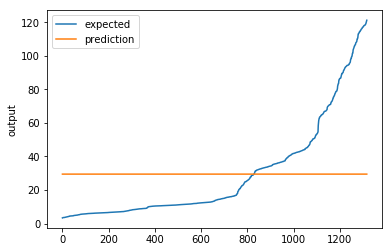

In [60]:
#Regression lift Chart
chart_regression(pred_sig_adam3l.flatten(),y_test)

### Sigmoid, adam, 4 layers, early stopping and Model checkpoint  - score_sig_adam4l

In [61]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid_4l.hdf5", verbose=1, save_best_only=True)

In [62]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(120, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_sigmoid_4l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 3s - loss: 1753.4796 - val_loss: 1620.3920

Epoch 00001: val_loss improved from inf to 1620.39197, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 2/100
 - 0s - loss: 1683.0843 - val_loss: 1578.2701

Epoch 00002: val_loss improved from 1620.39197 to 1578.27014, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 3/100
 - 0s - loss: 1642.2269 - val_loss: 1542.0719

Epoch 00003: val_loss improved from 1578.27014 to 1542.07188, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 4/100
 - 0s - loss: 1604.9603 - val_loss: 1508.1375

Epoch 00004: val_loss improved from 1542.07188 to 1508.13749, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 5/100
 - 0s - loss: 1569.6015 - val_loss: 1475.9391

Epoch 00005: val_loss improved from 1508.13749 to 1475.93915, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 6/100
 - 0s - loss: 1536.5559 - val_loss: 1445.5837

Epoch 00006: val_loss improved from 1475.93915 to 1445.583

 - 0s - loss: 914.3111 - val_loss: 902.7579

Epoch 00050: val_loss improved from 904.50863 to 902.75791, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 51/100
 - 0s - loss: 911.7863 - val_loss: 901.2753

Epoch 00051: val_loss improved from 902.75791 to 901.27525, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 52/100
 - 0s - loss: 909.6075 - val_loss: 899.9897

Epoch 00052: val_loss improved from 901.27525 to 899.98967, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 53/100
 - 0s - loss: 907.6212 - val_loss: 898.8941

Epoch 00053: val_loss improved from 899.98967 to 898.89406, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 54/100
 - 0s - loss: 905.8395 - val_loss: 897.9511

Epoch 00054: val_loss improved from 898.89406 to 897.95113, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 55/100
 - 0s - loss: 904.1281 - val_loss: 897.0967

Epoch 00055: val_loss improved from 897.95113 to 897.09672, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 56/100
 - 0s - lo


Epoch 00051: val_loss did not improve from 894.49565
Epoch 52/100
 - 0s - loss: 909.2891 - val_loss: 899.7449

Epoch 00052: val_loss did not improve from 894.49565
Epoch 53/100
 - 0s - loss: 907.2168 - val_loss: 898.6384

Epoch 00053: val_loss did not improve from 894.49565
Epoch 54/100
 - 0s - loss: 905.4889 - val_loss: 897.7479

Epoch 00054: val_loss did not improve from 894.49565
Epoch 55/100
 - 0s - loss: 903.7258 - val_loss: 896.8991

Epoch 00055: val_loss did not improve from 894.49565
Epoch 56/100
 - 0s - loss: 902.2727 - val_loss: 896.2288

Epoch 00056: val_loss did not improve from 894.49565
Epoch 57/100
 - 0s - loss: 900.9509 - val_loss: 895.7025

Epoch 00057: val_loss did not improve from 894.49565
Epoch 58/100
 - 0s - loss: 899.8645 - val_loss: 895.2979

Epoch 00058: val_loss did not improve from 894.49565
Epoch 59/100
 - 0s - loss: 898.9105 - val_loss: 894.9992

Epoch 00059: val_loss did not improve from 894.49565
Epoch 60/100
 - 0s - loss: 897.8838 - val_loss: 894.7275



 - 0s - loss: 895.2972 - val_loss: 894.5428

Epoch 00058: val_loss did not improve from 894.49338
Epoch 59/100
 - 0s - loss: 894.9381 - val_loss: 894.6220

Epoch 00059: val_loss did not improve from 894.49338
Epoch 00059: early stopping
3
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 3s - loss: 1755.0310 - val_loss: 1625.1591

Epoch 00001: val_loss did not improve from 894.49338
Epoch 2/100
 - 0s - loss: 1686.1147 - val_loss: 1578.9818

Epoch 00002: val_loss did not improve from 894.49338
Epoch 3/100
 - 0s - loss: 1640.4075 - val_loss: 1538.2073

Epoch 00003: val_loss did not improve from 894.49338
Epoch 4/100
 - 0s - loss: 1598.3904 - val_loss: 1499.6980

Epoch 00004: val_loss did not improve from 894.49338
Epoch 5/100
 - 0s - loss: 1558.6953 - val_loss: 1463.4348

Epoch 00005: val_loss did not improve from 894.49338
Epoch 6/100
 - 0s - loss: 1521.0211 - val_loss: 1429.2377

Epoch 00006: val_loss did not improve from 894.49338
Epoch 7/100
 - 0s - loss: 1485.6333 - val


Epoch 00010: val_loss did not improve from 894.49285
Epoch 11/100
 - 0s - loss: 1428.1084 - val_loss: 1346.0444

Epoch 00011: val_loss did not improve from 894.49285
Epoch 12/100
 - 0s - loss: 1400.1727 - val_loss: 1320.7373

Epoch 00012: val_loss did not improve from 894.49285
Epoch 13/100
 - 0s - loss: 1373.3112 - val_loss: 1296.1514

Epoch 00013: val_loss did not improve from 894.49285
Epoch 14/100
 - 0s - loss: 1347.1902 - val_loss: 1272.4285

Epoch 00014: val_loss did not improve from 894.49285
Epoch 15/100
 - 1s - loss: 1322.5473 - val_loss: 1250.1832

Epoch 00015: val_loss did not improve from 894.49285
Epoch 16/100
 - 0s - loss: 1298.8630 - val_loss: 1228.6969

Epoch 00016: val_loss did not improve from 894.49285
Epoch 17/100
 - 0s - loss: 1276.1550 - val_loss: 1208.5709

Epoch 00017: val_loss did not improve from 894.49285
Epoch 18/100
 - 0s - loss: 1254.6395 - val_loss: 1189.1186

Epoch 00018: val_loss did not improve from 894.49285
Epoch 19/100
 - 0s - loss: 1234.0138 - val

 - 0s - loss: 1527.9428 - val_loss: 1444.0164

Epoch 00015: val_loss did not improve from 894.49285
Epoch 16/100
 - 0s - loss: 1509.4769 - val_loss: 1427.0055

Epoch 00016: val_loss did not improve from 894.49285
Epoch 17/100
 - 0s - loss: 1491.6596 - val_loss: 1410.5621

Epoch 00017: val_loss did not improve from 894.49285
Epoch 18/100
 - 0s - loss: 1474.0827 - val_loss: 1393.7625

Epoch 00018: val_loss did not improve from 894.49285
Epoch 19/100
 - 1s - loss: 1443.4389 - val_loss: 1356.9227

Epoch 00019: val_loss did not improve from 894.49285
Epoch 20/100
 - 0s - loss: 1411.7711 - val_loss: 1331.9365

Epoch 00020: val_loss did not improve from 894.49285
Epoch 21/100
 - 0s - loss: 1386.9996 - val_loss: 1310.3043

Epoch 00021: val_loss did not improve from 894.49285
Epoch 22/100
 - 0s - loss: 1364.2468 - val_loss: 1290.1731

Epoch 00022: val_loss did not improve from 894.49285
Epoch 23/100
 - 0s - loss: 1343.3402 - val_loss: 1271.3078

Epoch 00023: val_loss did not improve from 894.49


Epoch 00088: val_loss did not improve from 894.49285
Epoch 89/100
 - 0s - loss: 896.0131 - val_loss: 894.4936

Epoch 00089: val_loss did not improve from 894.49285
Epoch 90/100
 - 0s - loss: 895.5976 - val_loss: 894.5008

Epoch 00090: val_loss did not improve from 894.49285
Epoch 91/100
 - 0s - loss: 895.2860 - val_loss: 894.5374

Epoch 00091: val_loss did not improve from 894.49285
Epoch 92/100
 - 0s - loss: 894.9806 - val_loss: 894.5836

Epoch 00092: val_loss did not improve from 894.49285
Epoch 00092: early stopping
6
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 3s - loss: 1741.1701 - val_loss: 1602.8435

Epoch 00001: val_loss did not improve from 894.49285
Epoch 2/100
 - 0s - loss: 1661.2977 - val_loss: 1555.2862

Epoch 00002: val_loss did not improve from 894.49285
Epoch 3/100
 - 0s - loss: 1615.7197 - val_loss: 1514.8008

Epoch 00003: val_loss did not improve from 894.49285
Epoch 4/100
 - 0s - loss: 1574.4463 - val_loss: 1477.5983

Epoch 00004: val_loss did not


Epoch 00009: val_loss did not improve from 894.49285
Epoch 10/100
 - 1s - loss: 1475.5295 - val_loss: 1391.6738

Epoch 00010: val_loss did not improve from 894.49285
Epoch 11/100
 - 0s - loss: 1450.6407 - val_loss: 1369.0079

Epoch 00011: val_loss did not improve from 894.49285
Epoch 12/100
 - 0s - loss: 1426.3067 - val_loss: 1346.7201

Epoch 00012: val_loss did not improve from 894.49285
Epoch 13/100
 - 0s - loss: 1402.9579 - val_loss: 1325.3365

Epoch 00013: val_loss did not improve from 894.49285
Epoch 14/100
 - 0s - loss: 1380.4373 - val_loss: 1304.5872

Epoch 00014: val_loss did not improve from 894.49285
Epoch 15/100
 - 0s - loss: 1358.5953 - val_loss: 1284.6829

Epoch 00015: val_loss did not improve from 894.49285
Epoch 16/100
 - 0s - loss: 1337.2693 - val_loss: 1265.2807

Epoch 00016: val_loss did not improve from 894.49285
Epoch 17/100
 - 0s - loss: 1316.7737 - val_loss: 1246.6567

Epoch 00017: val_loss did not improve from 894.49285
Epoch 18/100
 - 0s - loss: 1296.7538 - val

 - 0s - loss: 1562.9256 - val_loss: 1471.9023

Epoch 00005: val_loss did not improve from 894.49285
Epoch 6/100
 - 0s - loss: 1534.3611 - val_loss: 1445.6061

Epoch 00006: val_loss did not improve from 894.49285
Epoch 7/100
 - 0s - loss: 1506.7464 - val_loss: 1420.1010

Epoch 00007: val_loss did not improve from 894.49285
Epoch 8/100
 - 0s - loss: 1480.3027 - val_loss: 1395.7945

Epoch 00008: val_loss did not improve from 894.49285
Epoch 9/100
 - 0s - loss: 1453.9386 - val_loss: 1371.8899

Epoch 00009: val_loss did not improve from 894.49285
Epoch 10/100
 - 0s - loss: 1429.4883 - val_loss: 1349.5581

Epoch 00010: val_loss did not improve from 894.49285
Epoch 11/100
 - 0s - loss: 1405.7626 - val_loss: 1327.6921

Epoch 00011: val_loss did not improve from 894.49285
Epoch 12/100
 - 0s - loss: 1382.2935 - val_loss: 1306.3108

Epoch 00012: val_loss did not improve from 894.49285
Epoch 13/100
 - 0s - loss: 1359.8665 - val_loss: 1285.8088

Epoch 00013: val_loss did not improve from 894.49285


 - 0s - loss: 1667.4347 - val_loss: 1570.6131

Epoch 00003: val_loss did not improve from 894.49285
Epoch 4/100
 - 0s - loss: 1639.8177 - val_loss: 1545.3862

Epoch 00004: val_loss did not improve from 894.49285
Epoch 5/100
 - 0s - loss: 1613.6670 - val_loss: 1521.3512

Epoch 00005: val_loss did not improve from 894.49285
Epoch 6/100
 - 0s - loss: 1588.5517 - val_loss: 1498.0413

Epoch 00006: val_loss did not improve from 894.49285
Epoch 7/100
 - 0s - loss: 1564.2482 - val_loss: 1475.5309

Epoch 00007: val_loss did not improve from 894.49285
Epoch 8/100
 - 0s - loss: 1540.7719 - val_loss: 1453.8815

Epoch 00008: val_loss did not improve from 894.49285
Epoch 9/100
 - 0s - loss: 1517.8909 - val_loss: 1432.8232

Epoch 00009: val_loss did not improve from 894.49285
Epoch 10/100
 - 0s - loss: 1495.5342 - val_loss: 1412.0587

Epoch 00010: val_loss did not improve from 894.49285
Epoch 11/100
 - 0s - loss: 1473.8526 - val_loss: 1392.0806

Epoch 00011: val_loss did not improve from 894.49285
Ep


Epoch 00076: val_loss did not improve from 894.49285
Epoch 77/100
 - 0s - loss: 900.2744 - val_loss: 895.4951

Epoch 00077: val_loss did not improve from 894.49285
Epoch 78/100
 - 0s - loss: 899.4733 - val_loss: 895.2060

Epoch 00078: val_loss did not improve from 894.49285
Epoch 79/100
 - 0s - loss: 898.7676 - val_loss: 894.9881

Epoch 00079: val_loss did not improve from 894.49285
Epoch 80/100
 - 0s - loss: 898.1298 - val_loss: 894.8228

Epoch 00080: val_loss did not improve from 894.49285
Epoch 81/100
 - 0s - loss: 897.5920 - val_loss: 894.6732

Epoch 00081: val_loss did not improve from 894.49285
Epoch 82/100
 - 0s - loss: 897.0435 - val_loss: 894.5886

Epoch 00082: val_loss did not improve from 894.49285
Epoch 83/100
 - 0s - loss: 896.5808 - val_loss: 894.5211

Epoch 00083: val_loss did not improve from 894.49285
Epoch 84/100
 - 0s - loss: 895.6044 - val_loss: 894.5448

Epoch 00084: val_loss did not improve from 894.49285
Epoch 85/100
 - 0s - loss: 894.9478 - val_loss: 894.6124



In [63]:
# Predict stars
pred_sig_adam4l = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_adam4l.shape))

Shape: (1318, 1)


In [64]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_adam4l = np.sqrt(mean_squared_error(y_test,pred_sig_adam4l))
print("Final score (RMSE): {}".format(score_sig_adam4l))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_adam4l))

Final score (RMSE): 29.90807342529297
R2 score: -0.00


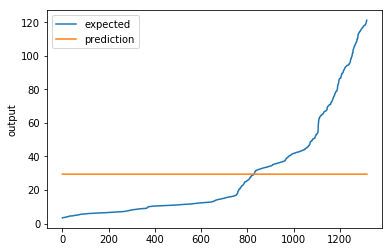

In [65]:
#Regression lift Chart
chart_regression(pred_sig_adam4l.flatten(),y_test)

### Sigmoid, adam, 4 layer and dropout - score_4l_sig_do

In [66]:
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(80, input_dim=x_train.shape[1]))  
    model_sig.add(Dropout(0.1))
    model_sig.add(Dense(60, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(20, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 4s - loss: 1831.7621 - val_loss: 1696.3688
Epoch 2/100
 - 0s - loss: 1762.9141 - val_loss: 1655.9093
Epoch 3/100
 - 0s - loss: 1726.8947 - val_loss: 1623.2267
Epoch 4/100
 - 0s - loss: 1690.0142 - val_loss: 1583.4696
Epoch 5/100
 - 0s - loss: 1644.0018 - val_loss: 1542.2556
Epoch 6/100
 - 0s - loss: 1605.0257 - val_loss: 1508.8826
Epoch 7/100
 - 0s - loss: 1571.6621 - val_loss: 1478.8101
Epoch 8/100
 - 0s - loss: 1540.3553 - val_loss: 1450.3915
Epoch 9/100
 - 0s - loss: 1511.2478 - val_loss: 1423.7146
Epoch 10/100
 - 0s - loss: 1483.3613 - val_loss: 1398.4064
Epoch 11/100
 - 0s - loss: 1456.7821 - val_loss: 1373.9406
Epoch 12/100
 - 0s - loss: 1431.0816 - val_loss: 1350.6372
Epoch 13/100
 - 0s - loss: 1406.9247 - val_loss: 1328.4283
Epoch 14/100
 - 0s - loss: 1383.3432 - val_loss: 1307.1109
Epoch 15/100
 - 0s - loss: 1360.6655 - val_loss: 1286.4250
Epoch 16/100
 - 0s - loss: 1339.0546 - val_loss: 1266.7540
Epoch 17/100
 - 0

In [67]:
# Predict stars
pred_sig_hl4_do = model_sig.predict(x_test)

In [68]:
# Measure RMSE error.  RMSE is common for regression.
score_4l_sig_do = np.sqrt(mean_squared_error(y_test,pred_sig_hl4_do))
print("Final score (RMSE): {}".format(score_4l_sig_do))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_hl4_do))

Final score (RMSE): 18.561588287353516
R2 score: 0.61


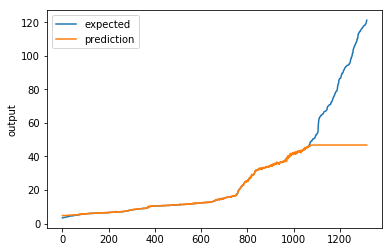

In [69]:
#Regression lift Chart
chart_regression(pred_sig_hl4_do.flatten(),y_test)

### Sigmoid, sgd, 3 layers, early stopping and Model checkpoint  - score_sig_3l_sgd

In [70]:
# set up checkpoinAter
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sig_sgd3l.hdf5", verbose=1, save_best_only=True)

In [71]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(60, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(30, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_sig_sgd3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 4s - loss: 936.7035 - val_loss: 897.5495

Epoch 00001: val_loss improved from inf to 897.54947, saving model to ./best_weights_sig_sgd3l.hdf5
Epoch 2/100
 - 0s - loss: 711.3575 - val_loss: 146.5359

Epoch 00002: val_loss improved from 897.54947 to 146.53588, saving model to ./best_weights_sig_sgd3l.hdf5
Epoch 3/100
 - 0s - loss: 72.5379 - val_loss: 70.2159

Epoch 00003: val_loss improved from 146.53588 to 70.21593, saving model to ./best_weights_sig_sgd3l.hdf5
Epoch 4/100
 - 1s - loss: 23.9522 - val_loss: 11.7209

Epoch 00004: val_loss improved from 70.21593 to 11.72093, saving model to ./best_weights_sig_sgd3l.hdf5
Epoch 5/100
 - 0s - loss: 9.0628 - val_loss: 9.0130

Epoch 00005: val_loss improved from 11.72093 to 9.01297, saving model to ./best_weights_sig_sgd3l.hdf5
Epoch 6/100
 - 0s - loss: 11.5399 - val_loss: 24.5389

Epoch 00006: val_loss did not improve from 9.01297
Epoch 7/100
 - 0s - loss: 7.5900 - val_loss: 2.58


Epoch 00004: val_loss did not improve from 0.73522
Epoch 5/100
 - 1s - loss: 10.5369 - val_loss: 9.7090

Epoch 00005: val_loss did not improve from 0.73522
Epoch 6/100
 - 0s - loss: 6.0531 - val_loss: 9.7614

Epoch 00006: val_loss did not improve from 0.73522
Epoch 7/100
 - 0s - loss: 6.6501 - val_loss: 4.7170

Epoch 00007: val_loss did not improve from 0.73522
Epoch 8/100
 - 0s - loss: 4.3362 - val_loss: 7.1360

Epoch 00008: val_loss did not improve from 0.73522
Epoch 9/100
 - 0s - loss: 4.5330 - val_loss: 2.7898

Epoch 00009: val_loss did not improve from 0.73522
Epoch 10/100
 - 0s - loss: 3.5700 - val_loss: 2.0542

Epoch 00010: val_loss did not improve from 0.73522
Epoch 11/100
 - 0s - loss: 4.9050 - val_loss: 11.6251

Epoch 00011: val_loss did not improve from 0.73522
Epoch 12/100
 - 0s - loss: 2.4151 - val_loss: 2.5799

Epoch 00012: val_loss did not improve from 0.73522
Epoch 13/100
 - 0s - loss: 2.2765 - val_loss: 2.4438

Epoch 00013: val_loss did not improve from 0.73522
Epoch 


Epoch 00010: val_loss did not improve from 0.46197
Epoch 11/100
 - 0s - loss: 1.7707 - val_loss: 32.2707

Epoch 00011: val_loss did not improve from 0.46197
Epoch 12/100
 - 0s - loss: 3.5653 - val_loss: 10.9987

Epoch 00012: val_loss did not improve from 0.46197
Epoch 13/100
 - 0s - loss: 2.9545 - val_loss: 2.3751

Epoch 00013: val_loss did not improve from 0.46197
Epoch 14/100
 - 0s - loss: 1.9671 - val_loss: 1.1995

Epoch 00014: val_loss did not improve from 0.46197
Epoch 15/100
 - 0s - loss: 2.0951 - val_loss: 3.1669

Epoch 00015: val_loss did not improve from 0.46197
Epoch 16/100
 - 0s - loss: 1.3553 - val_loss: 0.8420

Epoch 00016: val_loss did not improve from 0.46197
Epoch 17/100
 - 0s - loss: 3.0619 - val_loss: 7.3131

Epoch 00017: val_loss did not improve from 0.46197
Epoch 18/100
 - 0s - loss: 1.2264 - val_loss: 4.1860

Epoch 00018: val_loss did not improve from 0.46197
Epoch 19/100
 - 0s - loss: 3.2162 - val_loss: 2.1938

Epoch 00019: val_loss did not improve from 0.46197
E

In [72]:
# Predict stars
pred_sig_3l_sgd = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_3l_sgd.shape))


Shape: (1318, 1)


In [73]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_3l_sgd = np.sqrt(mean_squared_error(y_test,pred_sig_3l_sgd))
print("Final score (RMSE): {}".format(score_sig_3l_sgd))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_3l_sgd))

Final score (RMSE): 0.6796868443489075
R2 score: 1.00


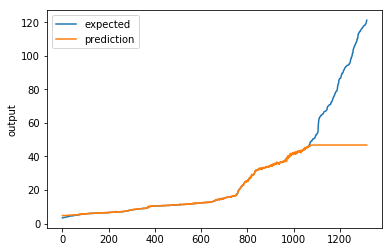

In [74]:
#Regression lift Chart
chart_regression(pred_sig_hl4_do.flatten(),y_test)

### Sigmoid, sgd, 3 layer and dropout - score_3l_sig_do

In [75]:
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(50, input_dim=x_train.shape[1]))  
    model_sig.add(Dropout(0.1))
    model_sig.add(Dense(25, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 4s - loss: 532.2570 - val_loss: 184.0305
Epoch 2/100
 - 0s - loss: 58.1811 - val_loss: 66.1215
Epoch 3/100
 - 0s - loss: 31.0287 - val_loss: 123.8884
Epoch 4/100
 - 0s - loss: 21.7321 - val_loss: 15.9764
Epoch 5/100
 - 0s - loss: 18.5145 - val_loss: 12.7352
Epoch 6/100
 - 0s - loss: 7.8863 - val_loss: 8.0795
Epoch 7/100
 - 0s - loss: 9.2645 - val_loss: 7.2117
Epoch 8/100
 - 0s - loss: 7.2272 - val_loss: 24.5154
Epoch 9/100
 - 0s - loss: 12.3332 - val_loss: 5.7286
Epoch 10/100
 - 0s - loss: 7.5535 - val_loss: 4.2741
Epoch 11/100
 - 0s - loss: 5.1146 - val_loss: 36.9126
Epoch 12/100
 - 0s - loss: 7.0316 - val_loss: 15.6471
Epoch 13/100
 - 0s - loss: 8.9609 - val_loss: 23.9045
Epoch 14/100
 - 0s - loss: 6.0624 - val_loss: 1.5185
Epoch 15/100
 - 1s - loss: 3.8298 - val_loss: 2.6192
Epoch 16/100
 - 0s - loss: 4.9789 - val_loss: 14.0453
Epoch 17/100
 - 0s - loss: 4.2127 - val_loss: 4.0449
Epoch 18/100
 - 0s - loss: 3.3106 - val_l

In [76]:
# Predict stars
pred_sig_hl3_do = model_sig.predict(x_test)

In [77]:
# Measure RMSE error.  RMSE is common for regression.
score_3l_sig_do = np.sqrt(mean_squared_error(y_test,pred_sig_hl3_do))
print("Final score (RMSE): {}".format(score_3l_sig_do))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_hl3_do))

Final score (RMSE): 1.8787375688552856
R2 score: 1.00


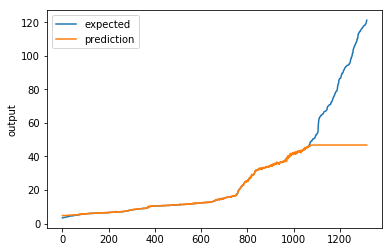

In [78]:
#Regression lift Chart
chart_regression(pred_sig_hl4_do.flatten(),y_test)

### Sigmoid, rmsprop, 3 layers, early stopping and Model checkpoint  - score_sig_3l_rms

In [79]:
# set up checkpointer
checkpointer_sig = ModelCheckpoint(filepath="./best_weights_relu_rms3l.hdf5", verbose=1, save_best_only=True)

In [80]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(60, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(30, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sig],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_relu_rms3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 4s - loss: 1689.5677 - val_loss: 1542.8683

Epoch 00001: val_loss improved from inf to 1542.86833, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 2/100
 - 1s - loss: 1589.3933 - val_loss: 1484.5038

Epoch 00002: val_loss improved from 1542.86833 to 1484.50383, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 3/100
 - 0s - loss: 1538.7106 - val_loss: 1440.6692

Epoch 00003: val_loss improved from 1484.50383 to 1440.66919, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 4/100
 - 0s - loss: 1493.4571 - val_loss: 1400.1483

Epoch 00004: val_loss improved from 1440.66919 to 1400.14829, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 5/100
 - 0s - loss: 1448.4558 - val_loss: 1355.5328

Epoch 00005: val_loss improved from 1400.14829 to 1355.53276, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 6/100
 - 0s - loss: 1402.4309 - val_loss: 1315.0663

Epoch 00006: val_loss improved from 1355.53276 to 1315.066

 - 0s - loss: 294.5944 - val_loss: 286.0697

Epoch 00050: val_loss improved from 297.78631 to 286.06972, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 51/100
 - 0s - loss: 282.6809 - val_loss: 274.6005

Epoch 00051: val_loss improved from 286.06972 to 274.60046, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 52/100
 - 0s - loss: 270.9254 - val_loss: 263.3085

Epoch 00052: val_loss improved from 274.60046 to 263.30853, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 53/100
 - 0s - loss: 259.9217 - val_loss: 252.2880

Epoch 00053: val_loss improved from 263.30853 to 252.28797, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 54/100
 - 0s - loss: 249.1230 - val_loss: 242.0677

Epoch 00054: val_loss improved from 252.28797 to 242.06766, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 55/100
 - 0s - loss: 238.4657 - val_loss: 231.6326

Epoch 00055: val_loss improved from 242.06766 to 231.63263, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 56/100
 - 0s - lo

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 4s - loss: 1791.6082 - val_loss: 1664.0237

Epoch 00001: val_loss did not improve from 17.01201
Epoch 2/100
 - 0s - loss: 1728.4130 - val_loss: 1619.2548

Epoch 00002: val_loss did not improve from 17.01201
Epoch 3/100
 - 0s - loss: 1682.1452 - val_loss: 1575.0480

Epoch 00003: val_loss did not improve from 17.01201
Epoch 4/100
 - 0s - loss: 1632.6801 - val_loss: 1526.3778

Epoch 00004: val_loss did not improve from 17.01201
Epoch 5/100
 - 0s - loss: 1582.2773 - val_loss: 1482.0744

Epoch 00005: val_loss did not improve from 17.01201
Epoch 6/100
 - 0s - loss: 1535.6135 - val_loss: 1436.1950

Epoch 00006: val_loss did not improve from 17.01201
Epoch 7/100
 - 0s - loss: 1483.4861 - val_loss: 1387.9092

Epoch 00007: val_loss did not improve from 17.01201
Epoch 8/100
 - 0s - loss: 1436.5297 - val_loss: 1346.2114

Epoch 00008: val_loss did not improve from 17.01201
Epoch 9/100
 - 0s - loss: 1392.5359 - val_loss: 1306.6250

Epoch

 - 0s - loss: 111.4927 - val_loss: 108.0309

Epoch 00075: val_loss did not improve from 17.01201
Epoch 76/100
 - 0s - loss: 105.8879 - val_loss: 102.2210

Epoch 00076: val_loss did not improve from 17.01201
Epoch 77/100
 - 0s - loss: 100.3997 - val_loss: 96.9439

Epoch 00077: val_loss did not improve from 17.01201
Epoch 78/100
 - 0s - loss: 95.2112 - val_loss: 91.9123

Epoch 00078: val_loss did not improve from 17.01201
Epoch 79/100
 - 0s - loss: 90.1937 - val_loss: 87.1738

Epoch 00079: val_loss did not improve from 17.01201
Epoch 80/100
 - 0s - loss: 85.3030 - val_loss: 81.8683

Epoch 00080: val_loss did not improve from 17.01201
Epoch 81/100
 - 0s - loss: 80.5324 - val_loss: 77.8388

Epoch 00081: val_loss did not improve from 17.01201
Epoch 82/100
 - 0s - loss: 76.3354 - val_loss: 73.0464

Epoch 00082: val_loss did not improve from 17.01201
Epoch 83/100
 - 0s - loss: 72.1667 - val_loss: 68.9950

Epoch 00083: val_loss did not improve from 17.01201
Epoch 84/100
 - 0s - loss: 68.0664 -


Epoch 00049: val_loss did not improve from 17.01201
Epoch 50/100
 - 0s - loss: 337.2882 - val_loss: 327.4553

Epoch 00050: val_loss did not improve from 17.01201
Epoch 51/100
 - 0s - loss: 324.3055 - val_loss: 314.8614

Epoch 00051: val_loss did not improve from 17.01201
Epoch 52/100
 - 0s - loss: 311.4325 - val_loss: 302.3927

Epoch 00052: val_loss did not improve from 17.01201
Epoch 53/100
 - 0s - loss: 298.6530 - val_loss: 290.1921

Epoch 00053: val_loss did not improve from 17.01201
Epoch 54/100
 - 1s - loss: 286.4965 - val_loss: 278.3538

Epoch 00054: val_loss did not improve from 17.01201
Epoch 55/100
 - 0s - loss: 274.8039 - val_loss: 266.8288

Epoch 00055: val_loss did not improve from 17.01201
Epoch 56/100
 - 0s - loss: 263.5295 - val_loss: 256.0723

Epoch 00056: val_loss did not improve from 17.01201
Epoch 57/100
 - 0s - loss: 252.4061 - val_loss: 245.2693

Epoch 00057: val_loss did not improve from 17.01201
Epoch 58/100
 - 0s - loss: 241.8786 - val_loss: 235.0638

Epoch 000

 - 0s - loss: 971.3769 - val_loss: 940.3100

Epoch 00024: val_loss did not improve from 17.01201
Epoch 25/100
 - 0s - loss: 953.0220 - val_loss: 920.0957

Epoch 00025: val_loss did not improve from 17.01201
Epoch 26/100
 - 0s - loss: 929.8052 - val_loss: 900.0091

Epoch 00026: val_loss did not improve from 17.01201
Epoch 27/100
 - 0s - loss: 907.7929 - val_loss: 873.5261

Epoch 00027: val_loss did not improve from 17.01201
Epoch 28/100
 - 0s - loss: 863.5175 - val_loss: 816.7526

Epoch 00028: val_loss did not improve from 17.01201
Epoch 29/100
 - 0s - loss: 807.8617 - val_loss: 761.3391

Epoch 00029: val_loss did not improve from 17.01201
Epoch 30/100
 - 0s - loss: 755.1393 - val_loss: 708.1680

Epoch 00030: val_loss did not improve from 17.01201
Epoch 31/100
 - 0s - loss: 706.6524 - val_loss: 670.8587

Epoch 00031: val_loss did not improve from 17.01201
Epoch 32/100
 - 0s - loss: 674.5202 - val_loss: 644.4433

Epoch 00032: val_loss did not improve from 17.01201
Epoch 33/100
 - 0s - lo

 - 0s - loss: 25.9555 - val_loss: 24.7292

Epoch 00099: val_loss did not improve from 17.01201
Epoch 100/100
 - 0s - loss: 24.2107 - val_loss: 22.6311

Epoch 00100: val_loss did not improve from 17.01201
4
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 4s - loss: 1843.6095 - val_loss: 1711.2968

Epoch 00001: val_loss did not improve from 17.01201
Epoch 2/100
 - 0s - loss: 1781.1020 - val_loss: 1673.2612

Epoch 00002: val_loss did not improve from 17.01201
Epoch 3/100
 - 0s - loss: 1741.9199 - val_loss: 1636.5357

Epoch 00003: val_loss did not improve from 17.01201
Epoch 4/100
 - 0s - loss: 1706.1356 - val_loss: 1604.9480

Epoch 00004: val_loss did not improve from 17.01201
Epoch 5/100
 - 0s - loss: 1673.3548 - val_loss: 1574.4176

Epoch 00005: val_loss did not improve from 17.01201
Epoch 6/100
 - 0s - loss: 1640.1368 - val_loss: 1539.3975

Epoch 00006: val_loss did not improve from 17.01201
Epoch 7/100
 - 1s - loss: 1598.7117 - val_loss: 1499.5696

Epoch 00007: val_loss

 - 1s - loss: 900.7744 - val_loss: 895.4076

Epoch 00031: val_loss did not improve from 17.01201
Epoch 32/100
 - 0s - loss: 898.7208 - val_loss: 894.7740

Epoch 00032: val_loss did not improve from 17.01201
Epoch 33/100
 - 0s - loss: 896.9667 - val_loss: 894.5178

Epoch 00033: val_loss did not improve from 17.01201
Epoch 34/100
 - 0s - loss: 895.8701 - val_loss: 894.4950

Epoch 00034: val_loss did not improve from 17.01201
Epoch 35/100
 - 0s - loss: 895.2422 - val_loss: 894.6024

Epoch 00035: val_loss did not improve from 17.01201
Epoch 36/100
 - 0s - loss: 894.5676 - val_loss: 894.6319

Epoch 00036: val_loss did not improve from 17.01201
Epoch 37/100
 - 0s - loss: 890.2103 - val_loss: 879.8439

Epoch 00037: val_loss did not improve from 17.01201
Epoch 38/100
 - 0s - loss: 870.1893 - val_loss: 861.4064

Epoch 00038: val_loss did not improve from 17.01201
Epoch 39/100
 - 0s - loss: 857.0264 - val_loss: 848.8092

Epoch 00039: val_loss did not improve from 17.01201
Epoch 40/100
 - 0s - lo


Epoch 00005: val_loss did not improve from 17.01201
Epoch 6/100
 - 0s - loss: 1503.6041 - val_loss: 1411.9197

Epoch 00006: val_loss did not improve from 17.01201
Epoch 7/100
 - 1s - loss: 1466.0636 - val_loss: 1377.3422

Epoch 00007: val_loss did not improve from 17.01201
Epoch 8/100
 - 0s - loss: 1426.1799 - val_loss: 1336.6101

Epoch 00008: val_loss did not improve from 17.01201
Epoch 9/100
 - 1s - loss: 1382.6565 - val_loss: 1298.0667

Epoch 00009: val_loss did not improve from 17.01201
Epoch 10/100
 - 0s - loss: 1339.8396 - val_loss: 1254.8839

Epoch 00010: val_loss did not improve from 17.01201
Epoch 11/100
 - 1s - loss: 1293.7159 - val_loss: 1214.2908

Epoch 00011: val_loss did not improve from 17.01201
Epoch 12/100
 - 0s - loss: 1252.0203 - val_loss: 1178.2093

Epoch 00012: val_loss did not improve from 17.01201
Epoch 13/100
 - 0s - loss: 1211.2499 - val_loss: 1139.2238

Epoch 00013: val_loss did not improve from 17.01201
Epoch 14/100
 - 0s - loss: 1170.0178 - val_loss: 1104.3

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 4s - loss: 1718.5325 - val_loss: 1574.4523

Epoch 00001: val_loss did not improve from 17.01201
Epoch 2/100
 - 0s - loss: 1624.0770 - val_loss: 1514.5211

Epoch 00002: val_loss did not improve from 17.01201
Epoch 3/100
 - 0s - loss: 1569.8190 - val_loss: 1470.2541

Epoch 00003: val_loss did not improve from 17.01201
Epoch 4/100
 - 0s - loss: 1524.3325 - val_loss: 1429.2381

Epoch 00004: val_loss did not improve from 17.01201
Epoch 5/100
 - 0s - loss: 1482.4602 - val_loss: 1390.2274

Epoch 00005: val_loss did not improve from 17.01201
Epoch 6/100
 - 0s - loss: 1442.1369 - val_loss: 1352.1903

Epoch 00006: val_loss did not improve from 17.01201
Epoch 7/100
 - 0s - loss: 1396.1535 - val_loss: 1307.3227

Epoch 00007: val_loss did not improve from 17.01201
Epoch 8/100
 - 0s - loss: 1350.9819 - val_loss: 1269.0229

Epoch 00008: val_loss did not improve from 17.01201
Epoch 9/100
 - 0s - loss: 1311.5201 - val_loss: 1233.1362

Epoch

 - 0s - loss: 598.5294 - val_loss: 571.2361

Epoch 00037: val_loss did not improve from 17.01201
Epoch 38/100
 - 0s - loss: 567.6430 - val_loss: 544.0237

Epoch 00038: val_loss did not improve from 17.01201
Epoch 39/100
 - 0s - loss: 543.0128 - val_loss: 522.4109

Epoch 00039: val_loss did not improve from 17.01201
Epoch 40/100
 - 0s - loss: 520.6080 - val_loss: 501.4561

Epoch 00040: val_loss did not improve from 17.01201
Epoch 41/100
 - 0s - loss: 499.9536 - val_loss: 482.4613

Epoch 00041: val_loss did not improve from 17.01201
Epoch 42/100
 - 0s - loss: 480.6576 - val_loss: 464.2154

Epoch 00042: val_loss did not improve from 17.01201
Epoch 43/100
 - 0s - loss: 463.1206 - val_loss: 448.4815

Epoch 00043: val_loss did not improve from 17.01201
Epoch 44/100
 - 0s - loss: 446.2679 - val_loss: 431.7154

Epoch 00044: val_loss did not improve from 17.01201
Epoch 45/100
 - 0s - loss: 430.3083 - val_loss: 416.3849

Epoch 00045: val_loss did not improve from 17.01201
Epoch 46/100
 - 1s - lo

In [81]:
# Predict stars
pred_sig_3l_rms = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_3l_rms.shape))


Shape: (1318, 1)


In [82]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_3l_rms = np.sqrt(mean_squared_error(y_test,pred_sig_3l_rms))
print("Final score (RMSE): {}".format(score_sig_3l_rms))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_3l_rms))

Final score (RMSE): 4.124561786651611
R2 score: 0.98


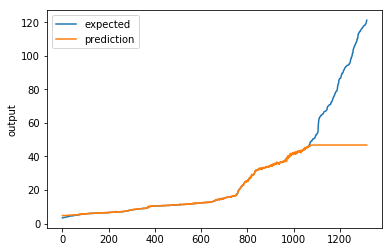

In [83]:
#Regression lift Chart
chart_regression(pred_sig_hl4_do.flatten(),y_test)

### Sigmoid, rmsprop, 3 layer and dropout - score_relu_3l_do

In [84]:
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(50, input_dim=x_train.shape[1]))  
    model_sig.add(Dropout(0.1))
    model_sig.add(Dense(25, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(10, activation='relu')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 4s - loss: 1597.9438 - val_loss: 1311.9551
Epoch 2/100
 - 1s - loss: 1174.1407 - val_loss: 960.0864
Epoch 3/100
 - 0s - loss: 846.9949 - val_loss: 691.9885
Epoch 4/100
 - 0s - loss: 581.3314 - val_loss: 443.8290
Epoch 5/100
 - 0s - loss: 315.6693 - val_loss: 200.4609
Epoch 6/100
 - 0s - loss: 136.2912 - val_loss: 80.6148
Epoch 7/100
 - 0s - loss: 53.7401 - val_loss: 30.5797
Epoch 8/100
 - 1s - loss: 26.9682 - val_loss: 20.9467
Epoch 9/100
 - 0s - loss: 20.1395 - val_loss: 17.0289
Epoch 10/100
 - 0s - loss: 17.7483 - val_loss: 17.4226
Epoch 11/100
 - 0s - loss: 16.5392 - val_loss: 13.4861
Epoch 12/100
 - 0s - loss: 13.9478 - val_loss: 12.4300
Epoch 13/100
 - 0s - loss: 10.6631 - val_loss: 7.1280
Epoch 14/100
 - 0s - loss: 6.8463 - val_loss: 3.3082
Epoch 15/100
 - 0s - loss: 4.8789 - val_loss: 3.0867
Epoch 16/100
 - 0s - loss: 3.9174 - val_loss: 1.5004
Epoch 17/100
 - 0s - loss: 3.5479 - val_loss: 1.9808
Epoch 18/100
 - 0s - 

In [85]:
# Predict stars
pred_sig_hl3_rms_do = model_sig.predict(x_test)

In [86]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_3l_rms_do = np.sqrt(mean_squared_error(y_test,pred_sig_hl3_rms_do))
print("Final score (RMSE): {}".format(score_sig_3l_rms_do))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_hl3_rms_do))

Final score (RMSE): 0.8083832859992981
R2 score: 1.00


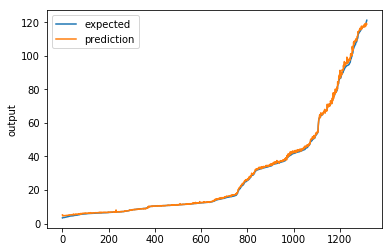

In [87]:
#Regression lift Chart
chart_regression(pred_sig_hl3_rms_do.flatten(),y_test)

## Tanh

### Tanh, adam, 2 layers, early stopping and Model checkpoint  - score_tanh_adam2l

In [88]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh_2l.hdf5", verbose=1, save_best_only=True)

In [89]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(120, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_tanh_2l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 4s - loss: 1339.8704 - val_loss: 970.6514

Epoch 00001: val_loss improved from inf to 970.65135, saving model to ./best_weights_tanh_2l.hdf5
Epoch 2/100
 - 0s - loss: 900.3659 - val_loss: 765.2611

Epoch 00002: val_loss improved from 970.65135 to 765.26105, saving model to ./best_weights_tanh_2l.hdf5
Epoch 3/100
 - 0s - loss: 695.3594 - val_loss: 593.7797

Epoch 00003: val_loss improved from 765.26105 to 593.77966, saving model to ./best_weights_tanh_2l.hdf5
Epoch 4/100
 - 0s - loss: 547.5053 - val_loss: 484.1746

Epoch 00004: val_loss improved from 593.77966 to 484.17462, saving model to ./best_weights_tanh_2l.hdf5
Epoch 5/100
 - 0s - loss: 448.3438 - val_loss: 403.8675

Epoch 00005: val_loss improved from 484.17462 to 403.86750, saving model to ./best_weights_tanh_2l.hdf5
Epoch 6/100
 - 0s - loss: 374.3710 - val_loss: 340.0761

Epoch 00006: val_loss improved from 403.86750 to 340.07615, saving model to ./best_weights_ta

 - 0s - loss: 0.3033 - val_loss: 0.3186

Epoch 00054: val_loss improved from 0.31964 to 0.31860, saving model to ./best_weights_tanh_2l.hdf5
Epoch 55/100
 - 0s - loss: 0.3199 - val_loss: 0.3149

Epoch 00055: val_loss improved from 0.31860 to 0.31493, saving model to ./best_weights_tanh_2l.hdf5
Epoch 56/100
 - 0s - loss: 0.2813 - val_loss: 0.2904

Epoch 00056: val_loss improved from 0.31493 to 0.29038, saving model to ./best_weights_tanh_2l.hdf5
Epoch 57/100
 - 0s - loss: 0.2786 - val_loss: 0.2882

Epoch 00057: val_loss improved from 0.29038 to 0.28816, saving model to ./best_weights_tanh_2l.hdf5
Epoch 58/100
 - 0s - loss: 0.2645 - val_loss: 0.2455

Epoch 00058: val_loss improved from 0.28816 to 0.24546, saving model to ./best_weights_tanh_2l.hdf5
Epoch 59/100
 - 0s - loss: 0.2530 - val_loss: 0.2334

Epoch 00059: val_loss improved from 0.24546 to 0.23338, saving model to ./best_weights_tanh_2l.hdf5
Epoch 60/100
 - 0s - loss: 0.2632 - val_loss: 0.2078

Epoch 00060: val_loss improved from


Epoch 00001: val_loss did not improve from 0.20454
Epoch 2/100
 - 1s - loss: 926.7479 - val_loss: 788.9149

Epoch 00002: val_loss did not improve from 0.20454
Epoch 3/100
 - 0s - loss: 713.6513 - val_loss: 605.6036

Epoch 00003: val_loss did not improve from 0.20454
Epoch 4/100
 - 0s - loss: 557.9681 - val_loss: 492.0033

Epoch 00004: val_loss did not improve from 0.20454
Epoch 5/100
 - 0s - loss: 457.1578 - val_loss: 410.0953

Epoch 00005: val_loss did not improve from 0.20454
Epoch 6/100
 - 0s - loss: 381.6051 - val_loss: 345.1140

Epoch 00006: val_loss did not improve from 0.20454
Epoch 7/100
 - 0s - loss: 321.1409 - val_loss: 291.4292

Epoch 00007: val_loss did not improve from 0.20454
Epoch 8/100
 - 0s - loss: 269.6454 - val_loss: 243.7489

Epoch 00008: val_loss did not improve from 0.20454
Epoch 9/100
 - 0s - loss: 224.1501 - val_loss: 201.0627

Epoch 00009: val_loss did not improve from 0.20454
Epoch 10/100
 - 0s - loss: 185.0214 - val_loss: 165.9777

Epoch 00010: val_loss did 


Epoch 00016: val_loss did not improve from 0.20107
Epoch 17/100
 - 0s - loss: 51.2356 - val_loss: 45.7716

Epoch 00017: val_loss did not improve from 0.20107
Epoch 18/100
 - 1s - loss: 43.3016 - val_loss: 38.1860

Epoch 00018: val_loss did not improve from 0.20107
Epoch 19/100
 - 0s - loss: 36.5323 - val_loss: 32.3225

Epoch 00019: val_loss did not improve from 0.20107
Epoch 20/100
 - 0s - loss: 30.9224 - val_loss: 27.1601

Epoch 00020: val_loss did not improve from 0.20107
Epoch 21/100
 - 0s - loss: 26.1174 - val_loss: 22.9917

Epoch 00021: val_loss did not improve from 0.20107
Epoch 22/100
 - 0s - loss: 22.0939 - val_loss: 19.3572

Epoch 00022: val_loss did not improve from 0.20107
Epoch 23/100
 - 0s - loss: 18.6853 - val_loss: 16.4122

Epoch 00023: val_loss did not improve from 0.20107
Epoch 24/100
 - 0s - loss: 15.7977 - val_loss: 13.8329

Epoch 00024: val_loss did not improve from 0.20107
Epoch 25/100
 - 0s - loss: 13.3347 - val_loss: 11.7401

Epoch 00025: val_loss did not improv

 - 0s - loss: 2.1795 - val_loss: 1.9512

Epoch 00036: val_loss did not improve from 0.20107
Epoch 37/100
 - 0s - loss: 1.8038 - val_loss: 1.6718

Epoch 00037: val_loss did not improve from 0.20107
Epoch 38/100
 - 0s - loss: 1.5555 - val_loss: 1.4554

Epoch 00038: val_loss did not improve from 0.20107
Epoch 39/100
 - 0s - loss: 1.2922 - val_loss: 1.2256

Epoch 00039: val_loss did not improve from 0.20107
Epoch 40/100
 - 0s - loss: 1.1185 - val_loss: 1.1614

Epoch 00040: val_loss did not improve from 0.20107
Epoch 41/100
 - 0s - loss: 0.9840 - val_loss: 0.9112

Epoch 00041: val_loss did not improve from 0.20107
Epoch 42/100
 - 0s - loss: 0.8566 - val_loss: 0.8919

Epoch 00042: val_loss did not improve from 0.20107
Epoch 43/100
 - 0s - loss: 0.7282 - val_loss: 0.7156

Epoch 00043: val_loss did not improve from 0.20107
Epoch 44/100
 - 1s - loss: 0.6657 - val_loss: 0.7103

Epoch 00044: val_loss did not improve from 0.20107
Epoch 45/100
 - 0s - loss: 0.5936 - val_loss: 0.6310

Epoch 00045: v

 - 0s - loss: 0.3681 - val_loss: 0.3555

Epoch 00050: val_loss did not improve from 0.20107
Epoch 51/100
 - 1s - loss: 0.3560 - val_loss: 0.3120

Epoch 00051: val_loss did not improve from 0.20107
Epoch 52/100
 - 1s - loss: 0.3123 - val_loss: 0.3200

Epoch 00052: val_loss did not improve from 0.20107
Epoch 53/100
 - 0s - loss: 0.3139 - val_loss: 0.3121

Epoch 00053: val_loss did not improve from 0.20107
Epoch 54/100
 - 0s - loss: 0.2888 - val_loss: 0.2693

Epoch 00054: val_loss did not improve from 0.20107
Epoch 55/100
 - 0s - loss: 0.2746 - val_loss: 0.2686

Epoch 00055: val_loss did not improve from 0.20107
Epoch 56/100
 - 0s - loss: 0.2998 - val_loss: 0.2530

Epoch 00056: val_loss did not improve from 0.20107
Epoch 57/100
 - 0s - loss: 0.2600 - val_loss: 0.2318

Epoch 00057: val_loss did not improve from 0.20107
Epoch 58/100
 - 0s - loss: 0.2551 - val_loss: 0.3133

Epoch 00058: val_loss did not improve from 0.20107
Epoch 59/100
 - 0s - loss: 0.3011 - val_loss: 0.2072

Epoch 00059: v

 - 1s - loss: 262.4493 - val_loss: 237.1113

Epoch 00008: val_loss did not improve from 0.19783
Epoch 9/100
 - 1s - loss: 217.7261 - val_loss: 195.5364

Epoch 00009: val_loss did not improve from 0.19783
Epoch 10/100
 - 0s - loss: 178.4902 - val_loss: 160.4940

Epoch 00010: val_loss did not improve from 0.19783
Epoch 11/100
 - 1s - loss: 147.0503 - val_loss: 132.4364

Epoch 00011: val_loss did not improve from 0.19783
Epoch 12/100
 - 0s - loss: 121.9070 - val_loss: 110.2859

Epoch 00012: val_loss did not improve from 0.19783
Epoch 13/100
 - 0s - loss: 102.1074 - val_loss: 92.5140

Epoch 00013: val_loss did not improve from 0.19783
Epoch 14/100
 - 0s - loss: 85.9619 - val_loss: 77.6767

Epoch 00014: val_loss did not improve from 0.19783
Epoch 15/100
 - 1s - loss: 72.4910 - val_loss: 65.2534

Epoch 00015: val_loss did not improve from 0.19783
Epoch 16/100
 - 0s - loss: 61.2280 - val_loss: 54.8845

Epoch 00016: val_loss did not improve from 0.19783
Epoch 17/100
 - 0s - loss: 51.7837 - val


Epoch 00019: val_loss did not improve from 0.19273
Epoch 20/100
 - 0s - loss: 29.7007 - val_loss: 26.3213

Epoch 00020: val_loss did not improve from 0.19273
Epoch 21/100
 - 1s - loss: 25.1760 - val_loss: 22.0772

Epoch 00021: val_loss did not improve from 0.19273
Epoch 22/100
 - 0s - loss: 21.2670 - val_loss: 18.7774

Epoch 00022: val_loss did not improve from 0.19273
Epoch 23/100
 - 0s - loss: 18.0603 - val_loss: 15.8481

Epoch 00023: val_loss did not improve from 0.19273
Epoch 24/100
 - 0s - loss: 15.2508 - val_loss: 13.4510

Epoch 00024: val_loss did not improve from 0.19273
Epoch 25/100
 - 0s - loss: 12.8474 - val_loss: 11.3380

Epoch 00025: val_loss did not improve from 0.19273
Epoch 26/100
 - 1s - loss: 10.8737 - val_loss: 9.6039

Epoch 00026: val_loss did not improve from 0.19273
Epoch 27/100
 - 1s - loss: 9.2075 - val_loss: 8.1825

Epoch 00027: val_loss did not improve from 0.19273
Epoch 28/100
 - 0s - loss: 7.7576 - val_loss: 6.9181

Epoch 00028: val_loss did not improve fro

 - 1s - loss: 3.2746 - val_loss: 2.9406

Epoch 00033: val_loss did not improve from 0.19273
Epoch 34/100
 - 0s - loss: 2.7731 - val_loss: 2.5918

Epoch 00034: val_loss did not improve from 0.19273
Epoch 35/100
 - 0s - loss: 2.3422 - val_loss: 2.1243

Epoch 00035: val_loss did not improve from 0.19273
Epoch 36/100
 - 1s - loss: 2.0008 - val_loss: 1.8153

Epoch 00036: val_loss did not improve from 0.19273
Epoch 37/100
 - 0s - loss: 1.6655 - val_loss: 1.5416

Epoch 00037: val_loss did not improve from 0.19273
Epoch 38/100
 - 0s - loss: 1.4283 - val_loss: 1.3436

Epoch 00038: val_loss did not improve from 0.19273
Epoch 39/100
 - 0s - loss: 1.2150 - val_loss: 1.2820

Epoch 00039: val_loss did not improve from 0.19273
Epoch 40/100
 - 0s - loss: 1.0676 - val_loss: 1.0820

Epoch 00040: val_loss did not improve from 0.19273
Epoch 41/100
 - 1s - loss: 0.9250 - val_loss: 0.9082

Epoch 00041: val_loss did not improve from 0.19273
Epoch 42/100
 - 0s - loss: 0.8016 - val_loss: 0.8067

Epoch 00042: v

In [90]:
# Predict stars
pred_tanh_adam2l = model_tanh.predict(x_test)
print("Shape: {}".format(pred_tanh_adam2l.shape))

Shape: (1318, 1)


In [91]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_adam2l = np.sqrt(mean_squared_error(y_test,pred_tanh_adam2l))
print("Final score (RMSE): {}".format(score_tanh_adam2l))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_adam2l))

Final score (RMSE): 0.43900614976882935
R2 score: 1.00


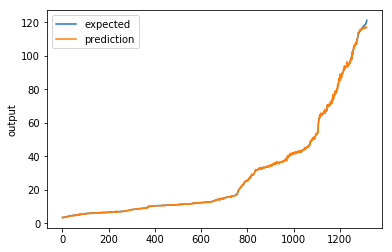

In [92]:
#Regression lift Chart
chart_regression(pred_tanh_adam2l.flatten(),y_test)

### Tanh, adam, 3 layers, early stopping and Model checkpoint  - score_tanh_adam3l

In [93]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_sigmoid_adam3l.hdf5", verbose=1, save_best_only=True)

In [94]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(120, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(60, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_sigmoid_adam3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 5s - loss: 1359.3639 - val_loss: 1097.5203

Epoch 00001: val_loss improved from inf to 1097.52032, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 2/100
 - 0s - loss: 1038.1594 - val_loss: 899.5257

Epoch 00002: val_loss improved from 1097.52032 to 899.52570, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 3/100
 - 0s - loss: 852.1553 - val_loss: 754.2978

Epoch 00003: val_loss improved from 899.52570 to 754.29783, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 4/100
 - 1s - loss: 717.2481 - val_loss: 643.1081

Epoch 00004: val_loss improved from 754.29783 to 643.10807, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 5/100
 - 0s - loss: 612.9360 - val_loss: 555.0142

Epoch 00005: val_loss improved from 643.10807 to 555.01416, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 6/100
 - 0s - loss: 529.1096 - val_loss: 482.9125

Epoch 00006: val_loss improved from 555.01416 to 482.9

 - 0s - loss: 0.9709 - val_loss: 1.1710

Epoch 00051: val_loss improved from 1.20158 to 1.17099, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 52/100
 - 0s - loss: 0.8178 - val_loss: 0.8249

Epoch 00052: val_loss improved from 1.17099 to 0.82490, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 53/100
 - 1s - loss: 0.6998 - val_loss: 0.7065

Epoch 00053: val_loss improved from 0.82490 to 0.70651, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 54/100
 - 0s - loss: 0.6261 - val_loss: 0.6097

Epoch 00054: val_loss improved from 0.70651 to 0.60968, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 55/100
 - 0s - loss: 0.5657 - val_loss: 0.5591

Epoch 00055: val_loss improved from 0.60968 to 0.55910, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 56/100
 - 0s - loss: 0.5129 - val_loss: 0.6763

Epoch 00056: val_loss did not improve from 0.55910
Epoch 57/100
 - 0s - loss: 0.4813 - val_loss: 0.4706

Epoch 00057: val_loss improved from 0.55910 to 0.


Epoch 00059: val_loss did not improve from 0.28446
Epoch 60/100
 - 1s - loss: 0.6498 - val_loss: 0.3285

Epoch 00060: val_loss did not improve from 0.28446
Epoch 61/100
 - 1s - loss: 0.3153 - val_loss: 0.3396

Epoch 00061: val_loss did not improve from 0.28446
Epoch 62/100
 - 0s - loss: 0.3142 - val_loss: 0.3787

Epoch 00062: val_loss did not improve from 0.28446
Epoch 63/100
 - 0s - loss: 0.3031 - val_loss: 0.2670

Epoch 00063: val_loss improved from 0.28446 to 0.26700, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 64/100
 - 0s - loss: 0.3004 - val_loss: 0.2619

Epoch 00064: val_loss improved from 0.26700 to 0.26185, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 65/100
 - 0s - loss: 0.2939 - val_loss: 0.3710

Epoch 00065: val_loss did not improve from 0.26185
Epoch 66/100
 - 1s - loss: 0.2607 - val_loss: 0.3636

Epoch 00066: val_loss did not improve from 0.26185
Epoch 67/100
 - 1s - loss: 0.3383 - val_loss: 0.4128

Epoch 00067: val_loss did not improve from 0.26

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 5s - loss: 1382.9769 - val_loss: 1111.6990

Epoch 00001: val_loss did not improve from 0.26185
Epoch 2/100
 - 0s - loss: 1054.0999 - val_loss: 912.4639

Epoch 00002: val_loss did not improve from 0.26185
Epoch 3/100
 - 0s - loss: 865.9857 - val_loss: 766.5381

Epoch 00003: val_loss did not improve from 0.26185
Epoch 4/100
 - 0s - loss: 730.4192 - val_loss: 654.6946

Epoch 00004: val_loss did not improve from 0.26185
Epoch 5/100
 - 1s - loss: 621.2771 - val_loss: 562.5420

Epoch 00005: val_loss did not improve from 0.26185
Epoch 6/100
 - 1s - loss: 536.7030 - val_loss: 490.7654

Epoch 00006: val_loss did not improve from 0.26185
Epoch 7/100
 - 0s - loss: 467.5729 - val_loss: 428.9747

Epoch 00007: val_loss did not improve from 0.26185
Epoch 8/100
 - 0s - loss: 407.3104 - val_loss: 374.0538

Epoch 00008: val_loss did not improve from 0.26185
Epoch 9/100
 - 0s - loss: 352.1492 - val_loss: 323.7754

Epoch 00009: val_loss did no


Epoch 00016: val_loss did not improve from 0.26185
Epoch 17/100
 - 1s - loss: 113.1835 - val_loss: 105.3693

Epoch 00017: val_loss did not improve from 0.26185
Epoch 18/100
 - 1s - loss: 99.6036 - val_loss: 92.1018

Epoch 00018: val_loss did not improve from 0.26185
Epoch 19/100
 - 1s - loss: 87.5871 - val_loss: 80.9301

Epoch 00019: val_loss did not improve from 0.26185
Epoch 20/100
 - 0s - loss: 77.0866 - val_loss: 71.1083

Epoch 00020: val_loss did not improve from 0.26185
Epoch 21/100
 - 1s - loss: 67.5539 - val_loss: 61.9792

Epoch 00021: val_loss did not improve from 0.26185
Epoch 22/100
 - 1s - loss: 59.3808 - val_loss: 54.2146

Epoch 00022: val_loss did not improve from 0.26185
Epoch 23/100
 - 0s - loss: 52.1780 - val_loss: 47.6234

Epoch 00023: val_loss did not improve from 0.26185
Epoch 24/100
 - 1s - loss: 45.7596 - val_loss: 41.1630

Epoch 00024: val_loss did not improve from 0.26185
Epoch 25/100
 - 1s - loss: 40.0574 - val_loss: 36.2132

Epoch 00025: val_loss did not impr


Epoch 00024: val_loss did not improve from 0.25893
Epoch 25/100
 - 1s - loss: 39.2641 - val_loss: 35.3877

Epoch 00025: val_loss did not improve from 0.25893
Epoch 26/100
 - 1s - loss: 34.3247 - val_loss: 30.8352

Epoch 00026: val_loss did not improve from 0.25893
Epoch 27/100
 - 1s - loss: 30.0366 - val_loss: 26.9452

Epoch 00027: val_loss did not improve from 0.25893
Epoch 28/100
 - 1s - loss: 26.3394 - val_loss: 23.5367

Epoch 00028: val_loss did not improve from 0.25893
Epoch 29/100
 - 1s - loss: 23.0101 - val_loss: 20.4759

Epoch 00029: val_loss did not improve from 0.25893
Epoch 30/100
 - 0s - loss: 20.1019 - val_loss: 18.0128

Epoch 00030: val_loss did not improve from 0.25893
Epoch 31/100
 - 1s - loss: 17.5892 - val_loss: 15.7230

Epoch 00031: val_loss did not improve from 0.25893
Epoch 32/100
 - 1s - loss: 15.3431 - val_loss: 14.0517

Epoch 00032: val_loss did not improve from 0.25893
Epoch 33/100
 - 1s - loss: 13.3851 - val_loss: 12.0199

Epoch 00033: val_loss did not improv

 - 1s - loss: 4.5953 - val_loss: 4.1858

Epoch 00040: val_loss did not improve from 0.25893
Epoch 41/100
 - 1s - loss: 3.8500 - val_loss: 3.8737

Epoch 00041: val_loss did not improve from 0.25893
Epoch 42/100
 - 1s - loss: 3.3389 - val_loss: 2.9965

Epoch 00042: val_loss did not improve from 0.25893
Epoch 43/100
 - 1s - loss: 2.8189 - val_loss: 3.0043

Epoch 00043: val_loss did not improve from 0.25893
Epoch 44/100
 - 1s - loss: 2.4437 - val_loss: 3.4054

Epoch 00044: val_loss did not improve from 0.25893
Epoch 45/100
 - 1s - loss: 2.1804 - val_loss: 2.2389

Epoch 00045: val_loss did not improve from 0.25893
Epoch 46/100
 - 1s - loss: 1.7191 - val_loss: 1.6650

Epoch 00046: val_loss did not improve from 0.25893
Epoch 47/100
 - 1s - loss: 1.4741 - val_loss: 1.4931

Epoch 00047: val_loss did not improve from 0.25893
Epoch 48/100
 - 1s - loss: 1.3024 - val_loss: 1.2351

Epoch 00048: val_loss did not improve from 0.25893
Epoch 49/100
 - 1s - loss: 1.1452 - val_loss: 1.5748

Epoch 00049: v


Epoch 00054: val_loss did not improve from 0.25893
Epoch 55/100
 - 1s - loss: 0.6521 - val_loss: 0.6288

Epoch 00055: val_loss did not improve from 0.25893
Epoch 56/100
 - 1s - loss: 0.5069 - val_loss: 0.7545

Epoch 00056: val_loss did not improve from 0.25893
Epoch 57/100
 - 1s - loss: 0.4714 - val_loss: 0.4928

Epoch 00057: val_loss did not improve from 0.25893
Epoch 58/100
 - 1s - loss: 0.4482 - val_loss: 0.3869

Epoch 00058: val_loss did not improve from 0.25893
Epoch 59/100
 - 1s - loss: 0.4441 - val_loss: 0.5872

Epoch 00059: val_loss did not improve from 0.25893
Epoch 60/100
 - 1s - loss: 0.5087 - val_loss: 0.4844

Epoch 00060: val_loss did not improve from 0.25893
Epoch 61/100
 - 1s - loss: 0.4076 - val_loss: 0.3473

Epoch 00061: val_loss did not improve from 0.25893
Epoch 62/100
 - 1s - loss: 0.3366 - val_loss: 0.4071

Epoch 00062: val_loss did not improve from 0.25893
Epoch 63/100
 - 1s - loss: 0.3191 - val_loss: 0.9531

Epoch 00063: val_loss did not improve from 0.25893
Epo


Epoch 00059: val_loss did not improve from 0.22327
Epoch 60/100
 - 1s - loss: 0.3740 - val_loss: 1.0008

Epoch 00060: val_loss did not improve from 0.22327
Epoch 61/100
 - 1s - loss: 0.5157 - val_loss: 0.3603

Epoch 00061: val_loss did not improve from 0.22327
Epoch 62/100
 - 1s - loss: 0.2995 - val_loss: 0.2889

Epoch 00062: val_loss did not improve from 0.22327
Epoch 63/100
 - 1s - loss: 0.3030 - val_loss: 0.3029

Epoch 00063: val_loss did not improve from 0.22327
Epoch 64/100
 - 1s - loss: 0.2693 - val_loss: 0.2222

Epoch 00064: val_loss improved from 0.22327 to 0.22218, saving model to ./best_weights_sigmoid_adam3l.hdf5
Epoch 65/100
 - 1s - loss: 0.3276 - val_loss: 0.2539

Epoch 00065: val_loss did not improve from 0.22218
Epoch 66/100
 - 1s - loss: 0.3994 - val_loss: 0.3108

Epoch 00066: val_loss did not improve from 0.22218
Epoch 67/100
 - 1s - loss: 0.2736 - val_loss: 0.2364

Epoch 00067: val_loss did not improve from 0.22218
Epoch 00067: early stopping
9
Train on 3074 samples,

In [95]:
# Predict stars
pred_tanh_adam3l = model_tanh.predict(x_test)
print("Shape: {}".format(pred_tanh_adam3l.shape))

Shape: (1318, 1)


In [96]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_adam3l = np.sqrt(mean_squared_error(y_test,pred_tanh_adam3l))
print("Final score (RMSE): {}".format(score_tanh_adam3l))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_adam3l))

Final score (RMSE): 0.4713636338710785
R2 score: 1.00


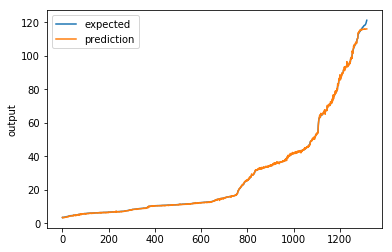

In [97]:
#Regression lift Chart
chart_regression(pred_tanh_adam3l.flatten(),y_test)

### Tanh, adam, 4 layers, early stopping and Model checkpoint  - score_tanh_adam4l

In [98]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_sigmoid_4l.hdf5", verbose=1, save_best_only=True)

In [99]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(120, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(60, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 4
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_sigmoid_4l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 5s - loss: 1663.6418 - val_loss: 1534.2572

Epoch 00001: val_loss improved from inf to 1534.25717, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 2/100
 - 1s - loss: 1586.0273 - val_loss: 1480.7211

Epoch 00002: val_loss improved from 1534.25717 to 1480.72108, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 3/100
 - 1s - loss: 1531.7549 - val_loss: 1431.9038

Epoch 00003: val_loss improved from 1480.72108 to 1431.90381, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 4/100
 - 1s - loss: 1480.7557 - val_loss: 1386.0348

Epoch 00004: val_loss improved from 1431.90381 to 1386.03478, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 5/100
 - 1s - loss: 1433.7600 - val_loss: 1343.5307

Epoch 00005: val_loss improved from 1386.03478 to 1343.53072, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 6/100
 - 1s - loss: 1390.2850 - val_loss: 1304.6376

Epoch 00006: val_loss improved from 1343.53072 to 1304.637


Epoch 00050: val_loss improved from 378.49256 to 367.75981, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 51/100
 - 1s - loss: 366.6420 - val_loss: 357.2680

Epoch 00051: val_loss improved from 367.75981 to 357.26804, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 52/100
 - 1s - loss: 355.9469 - val_loss: 347.0121

Epoch 00052: val_loss improved from 357.26804 to 347.01211, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 53/100
 - 1s - loss: 345.6070 - val_loss: 336.9733

Epoch 00053: val_loss improved from 347.01211 to 336.97328, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 54/100
 - 1s - loss: 335.4392 - val_loss: 327.1369

Epoch 00054: val_loss improved from 336.97328 to 327.13693, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 55/100
 - 1s - loss: 325.1915 - val_loss: 316.9084

Epoch 00055: val_loss improved from 327.13693 to 316.90843, saving model to ./best_weights_sigmoid_4l.hdf5
Epoch 56/100
 - 1s - loss: 315.4482 - val_loss: 307.5575

Epoch 000

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 5s - loss: 1632.5630 - val_loss: 1497.5584

Epoch 00001: val_loss did not improve from 61.66131
Epoch 2/100
 - 1s - loss: 1547.9594 - val_loss: 1445.6857

Epoch 00002: val_loss did not improve from 61.66131
Epoch 3/100
 - 1s - loss: 1494.9829 - val_loss: 1398.2636

Epoch 00003: val_loss did not improve from 61.66131
Epoch 4/100
 - 1s - loss: 1446.5695 - val_loss: 1354.6861

Epoch 00004: val_loss did not improve from 61.66131
Epoch 5/100
 - 1s - loss: 1400.8123 - val_loss: 1313.8256

Epoch 00005: val_loss did not improve from 61.66131
Epoch 6/100
 - 1s - loss: 1358.7806 - val_loss: 1275.9738

Epoch 00006: val_loss did not improve from 61.66131
Epoch 7/100
 - 1s - loss: 1318.9236 - val_loss: 1240.3872

Epoch 00007: val_loss did not improve from 61.66131
Epoch 8/100
 - 1s - loss: 1281.6785 - val_loss: 1207.3235

Epoch 00008: val_loss did not improve from 61.66131
Epoch 9/100
 - 1s - loss: 1246.2064 - val_loss: 1167.4948

Epoch

 - 1s - loss: 160.8929 - val_loss: 157.4711

Epoch 00075: val_loss did not improve from 61.66131
Epoch 76/100
 - 1s - loss: 155.3547 - val_loss: 151.5679

Epoch 00076: val_loss did not improve from 61.66131
Epoch 77/100
 - 1s - loss: 149.7388 - val_loss: 146.0698

Epoch 00077: val_loss did not improve from 61.66131
Epoch 78/100
 - 1s - loss: 144.4914 - val_loss: 141.0679

Epoch 00078: val_loss did not improve from 61.66131
Epoch 79/100
 - 1s - loss: 139.3409 - val_loss: 136.0169

Epoch 00079: val_loss did not improve from 61.66131
Epoch 80/100
 - 1s - loss: 134.2717 - val_loss: 130.9853

Epoch 00080: val_loss did not improve from 61.66131
Epoch 81/100
 - 1s - loss: 129.4180 - val_loss: 126.1446

Epoch 00081: val_loss did not improve from 61.66131
Epoch 82/100
 - 1s - loss: 124.6859 - val_loss: 121.5308

Epoch 00082: val_loss did not improve from 61.66131
Epoch 83/100
 - 1s - loss: 120.1986 - val_loss: 117.1057

Epoch 00083: val_loss did not improve from 61.66131
Epoch 84/100
 - 1s - lo


Epoch 00048: val_loss did not improve from 58.59670
Epoch 49/100
 - 1s - loss: 392.5972 - val_loss: 382.2899

Epoch 00049: val_loss did not improve from 58.59670
Epoch 50/100
 - 1s - loss: 381.2950 - val_loss: 371.4474

Epoch 00050: val_loss did not improve from 58.59670
Epoch 51/100
 - 1s - loss: 370.4021 - val_loss: 361.1401

Epoch 00051: val_loss did not improve from 58.59670
Epoch 52/100
 - 1s - loss: 359.7594 - val_loss: 350.5860

Epoch 00052: val_loss did not improve from 58.59670
Epoch 53/100
 - 1s - loss: 349.2544 - val_loss: 340.4054

Epoch 00053: val_loss did not improve from 58.59670
Epoch 54/100
 - 1s - loss: 338.8661 - val_loss: 330.4322

Epoch 00054: val_loss did not improve from 58.59670
Epoch 55/100
 - 1s - loss: 328.7750 - val_loss: 320.7989

Epoch 00055: val_loss did not improve from 58.59670
Epoch 56/100
 - 1s - loss: 318.9593 - val_loss: 310.9885

Epoch 00056: val_loss did not improve from 58.59670
Epoch 57/100
 - 1s - loss: 309.3348 - val_loss: 301.7959

Epoch 000

 - 1s - loss: 831.6801 - val_loss: 792.0404

Epoch 00023: val_loss did not improve from 58.59670
Epoch 24/100
 - 1s - loss: 806.0125 - val_loss: 768.3862

Epoch 00024: val_loss did not improve from 58.59670
Epoch 25/100
 - 1s - loss: 782.0984 - val_loss: 746.6631

Epoch 00025: val_loss did not improve from 58.59670
Epoch 26/100
 - 1s - loss: 759.3046 - val_loss: 725.5568

Epoch 00026: val_loss did not improve from 58.59670
Epoch 27/100
 - 1s - loss: 737.1257 - val_loss: 705.2293

Epoch 00027: val_loss did not improve from 58.59670
Epoch 28/100
 - 1s - loss: 715.7371 - val_loss: 685.4499

Epoch 00028: val_loss did not improve from 58.59670
Epoch 29/100
 - 1s - loss: 694.9642 - val_loss: 666.4623

Epoch 00029: val_loss did not improve from 58.59670
Epoch 30/100
 - 1s - loss: 674.7415 - val_loss: 647.8445

Epoch 00030: val_loss did not improve from 58.59670
Epoch 31/100
 - 1s - loss: 655.2741 - val_loss: 629.8298

Epoch 00031: val_loss did not improve from 58.59670
Epoch 32/100
 - 1s - lo

 - 1s - loss: 70.3782 - val_loss: 67.7343

Epoch 00098: val_loss did not improve from 58.59670
Epoch 99/100
 - 1s - loss: 67.4755 - val_loss: 65.0173

Epoch 00099: val_loss did not improve from 58.59670
Epoch 100/100
 - 1s - loss: 64.7021 - val_loss: 62.1802

Epoch 00100: val_loss did not improve from 58.59670
4
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 1642.8772 - val_loss: 1515.7738

Epoch 00001: val_loss did not improve from 58.59670
Epoch 2/100
 - 1s - loss: 1567.7023 - val_loss: 1464.2309

Epoch 00002: val_loss did not improve from 58.59670
Epoch 3/100
 - 1s - loss: 1515.0356 - val_loss: 1416.5707

Epoch 00003: val_loss did not improve from 58.59670
Epoch 4/100
 - 1s - loss: 1465.1877 - val_loss: 1371.7118

Epoch 00004: val_loss did not improve from 58.59670
Epoch 5/100
 - 1s - loss: 1419.4171 - val_loss: 1330.7142

Epoch 00005: val_loss did not improve from 58.59670
Epoch 6/100
 - 1s - loss: 1376.4067 - val_loss: 1292.1259

Epoch 00006: val_loss di

 - 1s - loss: 182.4928 - val_loss: 178.2521

Epoch 00072: val_loss did not improve from 58.59670
Epoch 73/100
 - 1s - loss: 176.1767 - val_loss: 171.9262

Epoch 00073: val_loss did not improve from 58.59670
Epoch 74/100
 - 1s - loss: 170.0739 - val_loss: 166.0909

Epoch 00074: val_loss did not improve from 58.59670
Epoch 75/100
 - 1s - loss: 164.1911 - val_loss: 160.2334

Epoch 00075: val_loss did not improve from 58.59670
Epoch 76/100
 - 1s - loss: 158.4524 - val_loss: 154.6948

Epoch 00076: val_loss did not improve from 58.59670
Epoch 77/100
 - 1s - loss: 152.5350 - val_loss: 148.9742

Epoch 00077: val_loss did not improve from 58.59670
Epoch 78/100
 - 1s - loss: 147.2117 - val_loss: 143.7362

Epoch 00078: val_loss did not improve from 58.59670
Epoch 79/100
 - 1s - loss: 142.0683 - val_loss: 138.6066

Epoch 00079: val_loss did not improve from 58.59670
Epoch 80/100
 - 1s - loss: 137.0307 - val_loss: 133.7355

Epoch 00080: val_loss did not improve from 58.59670
Epoch 81/100
 - 1s - lo


Epoch 00046: val_loss did not improve from 58.59670
Epoch 47/100
 - 1s - loss: 397.4864 - val_loss: 386.9596

Epoch 00047: val_loss did not improve from 58.59670
Epoch 48/100
 - 1s - loss: 386.2345 - val_loss: 376.1486

Epoch 00048: val_loss did not improve from 58.59670
Epoch 49/100
 - 1s - loss: 375.2047 - val_loss: 365.5220

Epoch 00049: val_loss did not improve from 58.59670
Epoch 50/100
 - 1s - loss: 364.4221 - val_loss: 355.0380

Epoch 00050: val_loss did not improve from 58.59670
Epoch 51/100
 - 1s - loss: 353.8130 - val_loss: 344.8788

Epoch 00051: val_loss did not improve from 58.59670
Epoch 52/100
 - 1s - loss: 343.4495 - val_loss: 334.6498

Epoch 00052: val_loss did not improve from 58.59670
Epoch 53/100
 - 1s - loss: 333.2586 - val_loss: 324.8313

Epoch 00053: val_loss did not improve from 58.59670
Epoch 54/100
 - 1s - loss: 322.9307 - val_loss: 314.9111

Epoch 00054: val_loss did not improve from 58.59670
Epoch 55/100
 - 1s - loss: 312.8284 - val_loss: 305.0436

Epoch 000


Epoch 00020: val_loss did not improve from 57.55573
Epoch 21/100
 - 1s - loss: 842.3076 - val_loss: 801.8459

Epoch 00021: val_loss did not improve from 57.55573
Epoch 22/100
 - 1s - loss: 816.7706 - val_loss: 778.2979

Epoch 00022: val_loss did not improve from 57.55573
Epoch 23/100
 - 1s - loss: 792.4407 - val_loss: 755.9094

Epoch 00023: val_loss did not improve from 57.55573
Epoch 24/100
 - 1s - loss: 768.9911 - val_loss: 734.5398

Epoch 00024: val_loss did not improve from 57.55573
Epoch 25/100
 - 1s - loss: 745.8285 - val_loss: 713.2548

Epoch 00025: val_loss did not improve from 57.55573
Epoch 26/100
 - 1s - loss: 723.5573 - val_loss: 692.7359

Epoch 00026: val_loss did not improve from 57.55573
Epoch 27/100
 - 1s - loss: 702.4082 - val_loss: 673.0734

Epoch 00027: val_loss did not improve from 57.55573
Epoch 28/100
 - 1s - loss: 681.9260 - val_loss: 654.2671

Epoch 00028: val_loss did not improve from 57.55573
Epoch 29/100
 - 1s - loss: 661.6371 - val_loss: 635.5102

Epoch 000


Epoch 00095: val_loss did not improve from 57.55573
Epoch 96/100
 - 1s - loss: 70.6243 - val_loss: 68.0400

Epoch 00096: val_loss did not improve from 57.55573
Epoch 97/100
 - 1s - loss: 67.7189 - val_loss: 65.1313

Epoch 00097: val_loss did not improve from 57.55573
Epoch 98/100
 - 1s - loss: 65.0067 - val_loss: 62.4969

Epoch 00098: val_loss did not improve from 57.55573
Epoch 99/100
 - 1s - loss: 62.2690 - val_loss: 59.6043

Epoch 00099: val_loss did not improve from 57.55573
Epoch 100/100
 - 1s - loss: 59.6724 - val_loss: 57.1373

Epoch 00100: val_loss improved from 57.55573 to 57.13727, saving model to ./best_weights_sigmoid_4l.hdf5
7
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 1676.4223 - val_loss: 1543.2994

Epoch 00001: val_loss did not improve from 57.13727
Epoch 2/100
 - 1s - loss: 1594.8042 - val_loss: 1488.8589

Epoch 00002: val_loss did not improve from 57.13727
Epoch 3/100
 - 1s - loss: 1539.4820 - val_loss: 1439.2071

Epoch 00003: val_loss 

 - 1s - loss: 208.1308 - val_loss: 203.4236

Epoch 00069: val_loss did not improve from 57.13727
Epoch 70/100
 - 1s - loss: 201.1821 - val_loss: 196.2805

Epoch 00070: val_loss did not improve from 57.13727
Epoch 71/100
 - 1s - loss: 193.9399 - val_loss: 189.4307

Epoch 00071: val_loss did not improve from 57.13727
Epoch 72/100
 - 1s - loss: 187.3445 - val_loss: 183.0278

Epoch 00072: val_loss did not improve from 57.13727
Epoch 73/100
 - 1s - loss: 180.9446 - val_loss: 176.5321

Epoch 00073: val_loss did not improve from 57.13727
Epoch 74/100
 - 1s - loss: 174.7105 - val_loss: 170.6222

Epoch 00074: val_loss did not improve from 57.13727
Epoch 75/100
 - 1s - loss: 168.6746 - val_loss: 164.6684

Epoch 00075: val_loss did not improve from 57.13727
Epoch 76/100
 - 1s - loss: 162.7644 - val_loss: 159.0232

Epoch 00076: val_loss did not improve from 57.13727
Epoch 77/100
 - 1s - loss: 157.0412 - val_loss: 153.3707

Epoch 00077: val_loss did not improve from 57.13727
Epoch 78/100
 - 1s - lo


Epoch 00043: val_loss did not improve from 57.13727
Epoch 44/100
 - 1s - loss: 447.5359 - val_loss: 435.1804

Epoch 00044: val_loss did not improve from 57.13727
Epoch 45/100
 - 1s - loss: 435.2732 - val_loss: 423.4129

Epoch 00045: val_loss did not improve from 57.13727
Epoch 46/100
 - 1s - loss: 423.1063 - val_loss: 411.7199

Epoch 00046: val_loss did not improve from 57.13727
Epoch 47/100
 - 1s - loss: 411.4470 - val_loss: 400.6820

Epoch 00047: val_loss did not improve from 57.13727
Epoch 48/100
 - 1s - loss: 400.1297 - val_loss: 389.6669

Epoch 00048: val_loss did not improve from 57.13727
Epoch 49/100
 - 1s - loss: 388.9865 - val_loss: 379.1686

Epoch 00049: val_loss did not improve from 57.13727
Epoch 50/100
 - 1s - loss: 378.0559 - val_loss: 368.3822

Epoch 00050: val_loss did not improve from 57.13727
Epoch 51/100
 - 1s - loss: 367.1201 - val_loss: 357.7714

Epoch 00051: val_loss did not improve from 57.13727
Epoch 52/100
 - 1s - loss: 356.6096 - val_loss: 347.8887

Epoch 000

 - 1s - loss: 929.0218 - val_loss: 881.2843

Epoch 00018: val_loss did not improve from 57.13727
Epoch 19/100
 - 1s - loss: 900.8959 - val_loss: 855.2439

Epoch 00019: val_loss did not improve from 57.13727
Epoch 20/100
 - 1s - loss: 873.2498 - val_loss: 830.2706

Epoch 00020: val_loss did not improve from 57.13727
Epoch 21/100
 - 1s - loss: 846.9358 - val_loss: 805.9710

Epoch 00021: val_loss did not improve from 57.13727
Epoch 22/100
 - 1s - loss: 821.3393 - val_loss: 782.7524

Epoch 00022: val_loss did not improve from 57.13727
Epoch 23/100
 - 1s - loss: 796.7374 - val_loss: 759.8846

Epoch 00023: val_loss did not improve from 57.13727
Epoch 24/100
 - 1s - loss: 772.9286 - val_loss: 737.8619

Epoch 00024: val_loss did not improve from 57.13727
Epoch 25/100
 - 1s - loss: 749.9170 - val_loss: 716.8982

Epoch 00025: val_loss did not improve from 57.13727
Epoch 26/100
 - 1s - loss: 727.7645 - val_loss: 696.4964

Epoch 00026: val_loss did not improve from 57.13727
Epoch 27/100
 - 1s - lo

 - 1s - loss: 80.0809 - val_loss: 77.4441

Epoch 00093: val_loss did not improve from 57.13727
Epoch 94/100
 - 1s - loss: 76.8854 - val_loss: 74.2587

Epoch 00094: val_loss did not improve from 57.13727
Epoch 95/100
 - 1s - loss: 73.7653 - val_loss: 71.2477

Epoch 00095: val_loss did not improve from 57.13727
Epoch 96/100
 - 1s - loss: 70.8519 - val_loss: 68.2142

Epoch 00096: val_loss did not improve from 57.13727
Epoch 97/100
 - 1s - loss: 67.7976 - val_loss: 65.1670

Epoch 00097: val_loss did not improve from 57.13727
Epoch 98/100
 - 1s - loss: 64.9751 - val_loss: 62.2818

Epoch 00098: val_loss did not improve from 57.13727
Epoch 99/100
 - 1s - loss: 62.2224 - val_loss: 60.4566

Epoch 00099: val_loss did not improve from 57.13727
Epoch 100/100
 - 1s - loss: 59.9116 - val_loss: 57.1339

Epoch 00100: val_loss improved from 57.13727 to 57.13390, saving model to ./best_weights_sigmoid_4l.hdf5
Training finished...Loading the best model



In [100]:
# Predict stars
pred_tanh_adam4l = model_tanh.predict(x_test)
print("Shape: {}".format(pred_tanh_adam4l.shape))

Shape: (1318, 1)


In [101]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_adam4l = np.sqrt(mean_squared_error(y_test,pred_tanh_adam4l))
print("Final score (RMSE): {}".format(score_tanh_adam4l))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_adam4l))

Final score (RMSE): 7.558696269989014
R2 score: 0.94


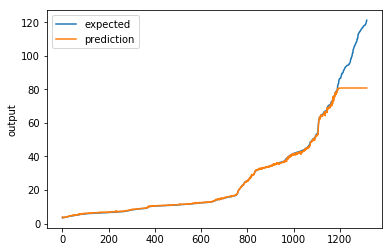

In [102]:
#Regression lift Chart
chart_regression(pred_tanh_adam4l.flatten(),y_test)

### Tanh, adam, 4 layer and dropout - score_4l_tanh_do

In [103]:
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(80, input_dim=x_train.shape[1]))  
    model_tanh.add(Dropout(0.1))
    model_tanh.add(Dense(60, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 4
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 1662.9009 - val_loss: 1509.5654
Epoch 2/100
 - 1s - loss: 1556.9769 - val_loss: 1451.5503
Epoch 3/100
 - 1s - loss: 1499.9687 - val_loss: 1401.7890
Epoch 4/100
 - 1s - loss: 1449.5470 - val_loss: 1356.9389
Epoch 5/100
 - 1s - loss: 1402.8972 - val_loss: 1315.1373
Epoch 6/100
 - 1s - loss: 1360.0758 - val_loss: 1276.7490
Epoch 7/100
 - 1s - loss: 1319.4436 - val_loss: 1240.6662
Epoch 8/100
 - 1s - loss: 1282.2310 - val_loss: 1208.0516
Epoch 9/100
 - 1s - loss: 1247.8301 - val_loss: 1177.2434
Epoch 10/100
 - 1s - loss: 1215.1665 - val_loss: 1148.5369
Epoch 11/100
 - 1s - loss: 1185.4921 - val_loss: 1122.8420
Epoch 12/100
 - 1s - loss: 1157.8169 - val_loss: 1098.8299
Epoch 13/100
 - 1s - loss: 1132.2618 - val_loss: 1074.0596
Epoch 14/100
 - 1s - loss: 1079.9578 - val_loss: 1016.2698
Epoch 15/100
 - 1s - loss: 1043.0480 - val_loss: 985.0226
Epoch 16/100
 - 1s - loss: 1009.6907 - val_loss: 954.3623
Epoch 17/100
 - 1s 

In [104]:
# Predict stars
pred_tanh_hl4_do = model_tanh.predict(x_test)

In [105]:
# Measure RMSE error.  RMSE is common for regression.
score_4l_tanh_do = np.sqrt(mean_squared_error(y_test,pred_tanh_hl4_do))
print("Final score (RMSE): {}".format(score_4l_tanh_do))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_hl4_do))

Final score (RMSE): 7.617536544799805
R2 score: 0.94


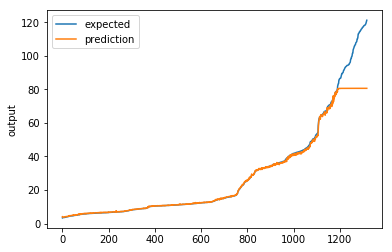

In [106]:
#Regression lift Chart
chart_regression(pred_tanh_hl4_do.flatten(),y_test)

### Tanh, sgd, 3 layers, early stopping and Model checkpoint  - score_tanh_3l_sgd

In [107]:
# set up checkpoinAter
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh_sgd3l.hdf5", verbose=1, save_best_only=True)

In [108]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(60, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(30, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_tanh_sgd3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 944.6137 - val_loss: 895.7843

Epoch 00001: val_loss improved from inf to 895.78435, saving model to ./best_weights_tanh_sgd3l.hdf5
Epoch 2/100
 - 1s - loss: 896.2609 - val_loss: 909.1138

Epoch 00002: val_loss did not improve from 895.78435
Epoch 3/100
 - 1s - loss: 898.3195 - val_loss: 1004.0814

Epoch 00003: val_loss did not improve from 895.78435
Epoch 4/100
 - 1s - loss: 899.0614 - val_loss: 901.1232

Epoch 00004: val_loss did not improve from 895.78435
Epoch 5/100
 - 1s - loss: 894.0332 - val_loss: 901.1978

Epoch 00005: val_loss did not improve from 895.78435
Epoch 6/100
 - 1s - loss: 896.2151 - val_loss: 898.6032

Epoch 00006: val_loss did not improve from 895.78435
Epoch 00006: early stopping
1
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 924.6747 - val_loss: 901.0994

Epoch 00001: val_loss did not improve from 895.78435
Epoch 2/100
 - 1s - loss: 894.8283 - val_loss: 929.73

 - 1s - loss: 896.5112 - val_loss: 953.3261

Epoch 00009: val_loss did not improve from 120.67060
Epoch 00009: early stopping
7
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 935.1578 - val_loss: 895.9458

Epoch 00001: val_loss did not improve from 120.67060
Epoch 2/100
 - 1s - loss: 898.0286 - val_loss: 960.6868

Epoch 00002: val_loss did not improve from 120.67060
Epoch 3/100
 - 1s - loss: 898.3178 - val_loss: 992.0396

Epoch 00003: val_loss did not improve from 120.67060
Epoch 4/100
 - 1s - loss: 901.0252 - val_loss: 896.3785

Epoch 00004: val_loss did not improve from 120.67060
Epoch 5/100
 - 1s - loss: 896.4066 - val_loss: 898.3515

Epoch 00005: val_loss did not improve from 120.67060
Epoch 6/100
 - 1s - loss: 898.6268 - val_loss: 895.5108

Epoch 00006: val_loss did not improve from 120.67060
Epoch 7/100
 - 1s - loss: 898.7636 - val_loss: 914.1634

Epoch 00007: val_loss did not improve from 120.67060
Epoch 8/100
 - 1s - loss: 898.6041 - val_loss: 919.724

In [109]:
# Predict stars
pred_tanh_3l_sgd = model_tanh.predict(x_test)
print("Shape: {}".format(pred_tanh_3l_sgd.shape))


Shape: (1318, 1)


In [110]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_3l_sgd = np.sqrt(mean_squared_error(y_test,pred_tanh_3l_sgd))
print("Final score (RMSE): {}".format(score_tanh_3l_sgd))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_3l_sgd))

Final score (RMSE): 10.985016822814941
R2 score: 0.87


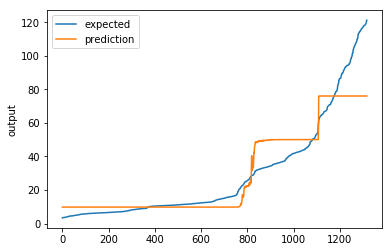

In [111]:
#Regression lift Chart
chart_regression(pred_tanh_3l_sgd.flatten(),y_test)

### Tanh, sgd, 3 layer and dropout - score_3l_tanh_do

In [112]:
    # Build network
    model_tanh = Sequential()
    model_tanh.add(Dense(50, input_dim=x_train.shape[1]))  
    model_tanh.add(Dropout(0.1))
    model_tanh.add(Dense(25, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 929.6058 - val_loss: 894.7788
Epoch 2/100
 - 1s - loss: 894.7760 - val_loss: 894.8494
Epoch 3/100
 - 1s - loss: 898.0812 - val_loss: 901.3721
Epoch 4/100
 - 1s - loss: 896.8569 - val_loss: 895.0986
Epoch 5/100
 - 1s - loss: 898.5391 - val_loss: 909.1310
Epoch 6/100
 - 1s - loss: 894.6670 - val_loss: 958.3881
Epoch 00006: early stopping


In [113]:
# Predict stars
pred_tanh_hl3_do = model_tanh.predict(x_test)

In [114]:
# Measure RMSE error.  RMSE is common for regression.
score_3l_tanh_do = np.sqrt(mean_squared_error(y_test,pred_tanh_hl3_do))
print("Final score (RMSE): {}".format(score_3l_tanh_do))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_hl3_do))

Final score (RMSE): 30.957843780517578
R2 score: -0.07


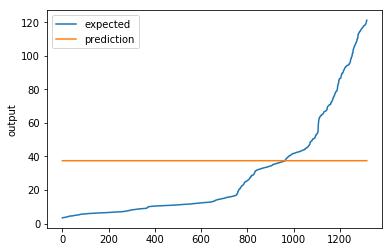

In [115]:
#Regression lift Chart
chart_regression(pred_tanh_hl3_do.flatten(),y_test)

### Tanh, rmsprop, 3 layers, early stopping and Model checkpoint  - score_tanh_3l_rms

In [116]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh_rms3l.hdf5", verbose=1, save_best_only=True)

In [117]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()
    model_tanh.add(Dense(60, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(30, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_tanh_rms3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 1625.1017 - val_loss: 1480.5819

Epoch 00001: val_loss improved from inf to 1480.58187, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 2/100
 - 1s - loss: 1530.0558 - val_loss: 1429.0258

Epoch 00002: val_loss improved from 1480.58187 to 1429.02579, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 3/100
 - 1s - loss: 1477.3547 - val_loss: 1381.9005

Epoch 00003: val_loss improved from 1429.02579 to 1381.90050, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 4/100
 - 1s - loss: 1428.8393 - val_loss: 1337.8536

Epoch 00004: val_loss improved from 1381.90050 to 1337.85365, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 5/100
 - 1s - loss: 1382.1798 - val_loss: 1295.0178

Epoch 00005: val_loss improved from 1337.85365 to 1295.01783, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 6/100
 - 1s - loss: 1334.6007 - val_loss: 1250.7464

Epoch 00006: val_loss improved from 1295.01783 to 1250.746


Epoch 00050: val_loss improved from 264.73629 to 253.75286, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 51/100
 - 1s - loss: 250.0994 - val_loss: 242.6838

Epoch 00051: val_loss improved from 253.75286 to 242.68376, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 52/100
 - 1s - loss: 239.5038 - val_loss: 232.3623

Epoch 00052: val_loss improved from 242.68376 to 232.36231, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 53/100
 - 1s - loss: 229.7645 - val_loss: 223.0576

Epoch 00053: val_loss improved from 232.36231 to 223.05757, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 54/100
 - 1s - loss: 220.4710 - val_loss: 214.0409

Epoch 00054: val_loss improved from 223.05757 to 214.04091, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 55/100
 - 1s - loss: 210.8023 - val_loss: 205.7641

Epoch 00055: val_loss improved from 214.04091 to 205.76413, saving model to ./best_weights_tanh_rms3l.hdf5
Epoch 56/100
 - 1s - loss: 201.5028 - val_loss: 195.7468

Epoch 000

 - 6s - loss: 1610.6420 - val_loss: 1455.9286

Epoch 00001: val_loss did not improve from 12.35512
Epoch 2/100
 - 1s - loss: 1504.9143 - val_loss: 1406.6804

Epoch 00002: val_loss did not improve from 12.35512
Epoch 3/100
 - 1s - loss: 1454.3535 - val_loss: 1361.1445

Epoch 00003: val_loss did not improve from 12.35512
Epoch 4/100
 - 1s - loss: 1406.6955 - val_loss: 1318.1174

Epoch 00004: val_loss did not improve from 12.35512
Epoch 5/100
 - 1s - loss: 1359.5199 - val_loss: 1273.3885

Epoch 00005: val_loss did not improve from 12.35512
Epoch 6/100
 - 1s - loss: 1313.3915 - val_loss: 1231.2230

Epoch 00006: val_loss did not improve from 12.35512
Epoch 7/100
 - 1s - loss: 1269.4386 - val_loss: 1190.3557

Epoch 00007: val_loss did not improve from 12.35512
Epoch 8/100
 - 1s - loss: 1226.8259 - val_loss: 1152.9627

Epoch 00008: val_loss did not improve from 12.35512
Epoch 9/100
 - 1s - loss: 1185.9385 - val_loss: 1114.5547

Epoch 00009: val_loss did not improve from 12.35512
Epoch 10/100


 - 1s - loss: 70.5910 - val_loss: 68.5316

Epoch 00076: val_loss did not improve from 12.35512
Epoch 77/100
 - 1s - loss: 66.5612 - val_loss: 63.2566

Epoch 00077: val_loss did not improve from 12.35512
Epoch 78/100
 - 1s - loss: 63.0889 - val_loss: 60.2603

Epoch 00078: val_loss did not improve from 12.35512
Epoch 79/100
 - 1s - loss: 59.2499 - val_loss: 56.4527

Epoch 00079: val_loss did not improve from 12.35512
Epoch 80/100
 - 1s - loss: 56.0021 - val_loss: 52.8825

Epoch 00080: val_loss did not improve from 12.35512
Epoch 81/100
 - 1s - loss: 52.5816 - val_loss: 49.5602

Epoch 00081: val_loss did not improve from 12.35512
Epoch 82/100
 - 1s - loss: 49.4245 - val_loss: 47.7112

Epoch 00082: val_loss did not improve from 12.35512
Epoch 83/100
 - 1s - loss: 46.2997 - val_loss: 43.5581

Epoch 00083: val_loss did not improve from 12.35512
Epoch 84/100
 - 1s - loss: 43.5129 - val_loss: 40.5222

Epoch 00084: val_loss did not improve from 12.35512
Epoch 85/100
 - 1s - loss: 40.6648 - val_

 - 1s - loss: 266.0889 - val_loss: 258.6602

Epoch 00050: val_loss did not improve from 11.63446
Epoch 51/100
 - 1s - loss: 255.1538 - val_loss: 248.5817

Epoch 00051: val_loss did not improve from 11.63446
Epoch 52/100
 - 1s - loss: 244.0857 - val_loss: 236.5267

Epoch 00052: val_loss did not improve from 11.63446
Epoch 53/100
 - 1s - loss: 233.8523 - val_loss: 227.4120

Epoch 00053: val_loss did not improve from 11.63446
Epoch 54/100
 - 1s - loss: 223.7619 - val_loss: 217.5676

Epoch 00054: val_loss did not improve from 11.63446
Epoch 55/100
 - 1s - loss: 213.8846 - val_loss: 207.9440

Epoch 00055: val_loss did not improve from 11.63446
Epoch 56/100
 - 1s - loss: 204.4072 - val_loss: 198.1586

Epoch 00056: val_loss did not improve from 11.63446
Epoch 57/100
 - 1s - loss: 195.4666 - val_loss: 190.9001

Epoch 00057: val_loss did not improve from 11.63446
Epoch 58/100
 - 1s - loss: 186.7661 - val_loss: 181.5304

Epoch 00058: val_loss did not improve from 11.63446
Epoch 59/100
 - 1s - lo


Epoch 00024: val_loss did not improve from 11.63446
Epoch 25/100
 - 1s - loss: 723.8400 - val_loss: 690.4245

Epoch 00025: val_loss did not improve from 11.63446
Epoch 26/100
 - 1s - loss: 697.3868 - val_loss: 665.5880

Epoch 00026: val_loss did not improve from 11.63446
Epoch 27/100
 - 1s - loss: 671.5629 - val_loss: 642.6774

Epoch 00027: val_loss did not improve from 11.63446
Epoch 28/100
 - 1s - loss: 647.1568 - val_loss: 619.7500

Epoch 00028: val_loss did not improve from 11.63446
Epoch 29/100
 - 1s - loss: 623.2929 - val_loss: 598.0384

Epoch 00029: val_loss did not improve from 11.63446
Epoch 30/100
 - 1s - loss: 600.8812 - val_loss: 576.7614

Epoch 00030: val_loss did not improve from 11.63446
Epoch 31/100
 - 1s - loss: 578.4240 - val_loss: 556.3894

Epoch 00031: val_loss did not improve from 11.63446
Epoch 32/100
 - 1s - loss: 557.3912 - val_loss: 536.2863

Epoch 00032: val_loss did not improve from 11.63446
Epoch 33/100
 - 1s - loss: 536.9777 - val_loss: 517.3662

Epoch 000


Epoch 00099: val_loss did not improve from 11.63446
Epoch 100/100
 - 1s - loss: 15.2354 - val_loss: 13.8067

Epoch 00100: val_loss did not improve from 11.63446
4
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 1647.1586 - val_loss: 1494.5843

Epoch 00001: val_loss did not improve from 11.63446
Epoch 2/100
 - 1s - loss: 1543.5020 - val_loss: 1441.3186

Epoch 00002: val_loss did not improve from 11.63446
Epoch 3/100
 - 1s - loss: 1491.9251 - val_loss: 1394.9772

Epoch 00003: val_loss did not improve from 11.63446
Epoch 4/100
 - 1s - loss: 1443.5250 - val_loss: 1351.3444

Epoch 00004: val_loss did not improve from 11.63446
Epoch 5/100
 - 1s - loss: 1396.4413 - val_loss: 1308.4876

Epoch 00005: val_loss did not improve from 11.63446
Epoch 6/100
 - 1s - loss: 1351.0651 - val_loss: 1263.8496

Epoch 00006: val_loss did not improve from 11.63446
Epoch 7/100
 - 1s - loss: 1303.4086 - val_loss: 1222.6959

Epoch 00007: val_loss did not improve from 11.63446
Epoch 8/100


Epoch 00073: val_loss did not improve from 11.63446
Epoch 74/100
 - 1s - loss: 81.9484 - val_loss: 78.8750

Epoch 00074: val_loss did not improve from 11.63446
Epoch 75/100
 - 1s - loss: 77.5276 - val_loss: 75.6996

Epoch 00075: val_loss did not improve from 11.63446
Epoch 76/100
 - 1s - loss: 73.2626 - val_loss: 69.7446

Epoch 00076: val_loss did not improve from 11.63446
Epoch 77/100
 - 1s - loss: 69.0566 - val_loss: 65.8330

Epoch 00077: val_loss did not improve from 11.63446
Epoch 78/100
 - 1s - loss: 65.2408 - val_loss: 62.5821

Epoch 00078: val_loss did not improve from 11.63446
Epoch 79/100
 - 1s - loss: 61.4619 - val_loss: 59.0361

Epoch 00079: val_loss did not improve from 11.63446
Epoch 80/100
 - 1s - loss: 58.0179 - val_loss: 54.6738

Epoch 00080: val_loss did not improve from 11.63446
Epoch 81/100
 - 1s - loss: 54.5743 - val_loss: 53.3872

Epoch 00081: val_loss did not improve from 11.63446
Epoch 82/100
 - 1s - loss: 51.3396 - val_loss: 49.4062

Epoch 00082: val_loss did n

 - 1s - loss: 273.0723 - val_loss: 265.1262

Epoch 00048: val_loss did not improve from 11.63446
Epoch 49/100
 - 1s - loss: 261.4849 - val_loss: 253.8142

Epoch 00049: val_loss did not improve from 11.63446
Epoch 50/100
 - 1s - loss: 251.1006 - val_loss: 243.8786

Epoch 00050: val_loss did not improve from 11.63446
Epoch 51/100
 - 1s - loss: 240.4711 - val_loss: 233.7738

Epoch 00051: val_loss did not improve from 11.63446
Epoch 52/100
 - 1s - loss: 230.2634 - val_loss: 223.4922

Epoch 00052: val_loss did not improve from 11.63446
Epoch 53/100
 - 1s - loss: 220.5970 - val_loss: 214.2336

Epoch 00053: val_loss did not improve from 11.63446
Epoch 54/100
 - 1s - loss: 211.6756 - val_loss: 205.2929

Epoch 00054: val_loss did not improve from 11.63446
Epoch 55/100
 - 1s - loss: 202.2520 - val_loss: 196.1336

Epoch 00055: val_loss did not improve from 11.63446
Epoch 56/100
 - 1s - loss: 193.5621 - val_loss: 187.9889

Epoch 00056: val_loss did not improve from 11.63446
Epoch 57/100
 - 1s - lo


Epoch 00022: val_loss did not improve from 11.63446
Epoch 23/100
 - 1s - loss: 776.0465 - val_loss: 738.5101

Epoch 00023: val_loss did not improve from 11.63446
Epoch 24/100
 - 1s - loss: 747.4600 - val_loss: 712.5228

Epoch 00024: val_loss did not improve from 11.63446
Epoch 25/100
 - 1s - loss: 720.8158 - val_loss: 687.4039

Epoch 00025: val_loss did not improve from 11.63446
Epoch 26/100
 - 1s - loss: 694.0434 - val_loss: 662.8271

Epoch 00026: val_loss did not improve from 11.63446
Epoch 27/100
 - 1s - loss: 668.6250 - val_loss: 639.8435

Epoch 00027: val_loss did not improve from 11.63446
Epoch 28/100
 - 1s - loss: 644.0630 - val_loss: 616.9300

Epoch 00028: val_loss did not improve from 11.63446
Epoch 29/100
 - 1s - loss: 620.4007 - val_loss: 594.9361

Epoch 00029: val_loss did not improve from 11.63446
Epoch 30/100
 - 1s - loss: 598.6056 - val_loss: 574.9132

Epoch 00030: val_loss did not improve from 11.63446
Epoch 31/100
 - 1s - loss: 576.3430 - val_loss: 554.4487

Epoch 000


Epoch 00097: val_loss did not improve from 11.63446
Epoch 98/100
 - 1s - loss: 17.6718 - val_loss: 16.0210

Epoch 00098: val_loss did not improve from 11.63446
Epoch 99/100
 - 1s - loss: 16.3474 - val_loss: 15.6324

Epoch 00099: val_loss did not improve from 11.63446
Epoch 100/100
 - 1s - loss: 15.1432 - val_loss: 14.0822

Epoch 00100: val_loss did not improve from 11.63446
7
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 1624.2497 - val_loss: 1469.9781

Epoch 00001: val_loss did not improve from 11.63446
Epoch 2/100
 - 1s - loss: 1518.8044 - val_loss: 1419.6639

Epoch 00002: val_loss did not improve from 11.63446
Epoch 3/100
 - 1s - loss: 1467.8415 - val_loss: 1373.0981

Epoch 00003: val_loss did not improve from 11.63446
Epoch 4/100
 - 1s - loss: 1419.0152 - val_loss: 1328.8400

Epoch 00004: val_loss did not improve from 11.63446
Epoch 5/100
 - 1s - loss: 1372.5355 - val_loss: 1284.4888

Epoch 00005: val_loss did not improve from 11.63446
Epoch 6/100
 - 1s


Epoch 00071: val_loss did not improve from 11.63446
Epoch 72/100
 - 1s - loss: 90.1401 - val_loss: 86.6228

Epoch 00072: val_loss did not improve from 11.63446
Epoch 73/100
 - 1s - loss: 85.7678 - val_loss: 82.2449

Epoch 00073: val_loss did not improve from 11.63446
Epoch 74/100
 - 1s - loss: 81.5671 - val_loss: 78.3889

Epoch 00074: val_loss did not improve from 11.63446
Epoch 75/100
 - 1s - loss: 77.2415 - val_loss: 74.4015

Epoch 00075: val_loss did not improve from 11.63446
Epoch 76/100
 - 1s - loss: 72.7382 - val_loss: 69.2700

Epoch 00076: val_loss did not improve from 11.63446
Epoch 77/100
 - 1s - loss: 68.7995 - val_loss: 67.6359

Epoch 00077: val_loss did not improve from 11.63446
Epoch 78/100
 - 1s - loss: 64.8351 - val_loss: 62.3150

Epoch 00078: val_loss did not improve from 11.63446
Epoch 79/100
 - 1s - loss: 60.9502 - val_loss: 57.7938

Epoch 00079: val_loss did not improve from 11.63446
Epoch 80/100
 - 1s - loss: 57.2565 - val_loss: 54.0737

Epoch 00080: val_loss did n

 - 1s - loss: 318.0199 - val_loss: 308.0937

Epoch 00046: val_loss did not improve from 11.63446
Epoch 47/100
 - 1s - loss: 305.4242 - val_loss: 296.3020

Epoch 00047: val_loss did not improve from 11.63446
Epoch 48/100
 - 1s - loss: 293.7372 - val_loss: 285.4003

Epoch 00048: val_loss did not improve from 11.63446
Epoch 49/100
 - 1s - loss: 282.0347 - val_loss: 273.8503

Epoch 00049: val_loss did not improve from 11.63446
Epoch 50/100
 - 1s - loss: 270.4230 - val_loss: 262.2948

Epoch 00050: val_loss did not improve from 11.63446
Epoch 51/100
 - 1s - loss: 259.5042 - val_loss: 252.4704

Epoch 00051: val_loss did not improve from 11.63446
Epoch 52/100
 - 1s - loss: 248.7085 - val_loss: 240.9689

Epoch 00052: val_loss did not improve from 11.63446
Epoch 53/100
 - 1s - loss: 238.1111 - val_loss: 231.4826

Epoch 00053: val_loss did not improve from 11.63446
Epoch 54/100
 - 1s - loss: 227.7183 - val_loss: 221.2556

Epoch 00054: val_loss did not improve from 11.63446
Epoch 55/100
 - 1s - lo


Epoch 00020: val_loss did not improve from 11.63446
Epoch 21/100
 - 1s - loss: 826.9109 - val_loss: 784.6540

Epoch 00021: val_loss did not improve from 11.63446
Epoch 22/100
 - 1s - loss: 797.5597 - val_loss: 757.9516

Epoch 00022: val_loss did not improve from 11.63446
Epoch 23/100
 - 1s - loss: 769.0250 - val_loss: 732.1663

Epoch 00023: val_loss did not improve from 11.63446
Epoch 24/100
 - 1s - loss: 741.2263 - val_loss: 706.3587

Epoch 00024: val_loss did not improve from 11.63446
Epoch 25/100
 - 1s - loss: 713.8131 - val_loss: 681.5384

Epoch 00025: val_loss did not improve from 11.63446
Epoch 26/100
 - 1s - loss: 688.1202 - val_loss: 657.2481

Epoch 00026: val_loss did not improve from 11.63446
Epoch 27/100
 - 1s - loss: 663.3391 - val_loss: 634.5281

Epoch 00027: val_loss did not improve from 11.63446
Epoch 28/100
 - 1s - loss: 638.6898 - val_loss: 612.2591

Epoch 00028: val_loss did not improve from 11.63446
Epoch 29/100
 - 1s - loss: 615.3558 - val_loss: 590.6238

Epoch 000


Epoch 00095: val_loss did not improve from 11.63446
Epoch 96/100
 - 1s - loss: 20.4867 - val_loss: 18.7432

Epoch 00096: val_loss did not improve from 11.63446
Epoch 97/100
 - 1s - loss: 18.8480 - val_loss: 17.3266

Epoch 00097: val_loss did not improve from 11.63446
Epoch 98/100
 - 1s - loss: 17.4572 - val_loss: 16.0777

Epoch 00098: val_loss did not improve from 11.63446
Epoch 99/100
 - 1s - loss: 16.0436 - val_loss: 14.9733

Epoch 00099: val_loss did not improve from 11.63446
Epoch 100/100
 - 1s - loss: 14.7439 - val_loss: 13.5819

Epoch 00100: val_loss did not improve from 11.63446
Training finished...Loading the best model



In [118]:
# Predict stars
pred_tanh_3l_rms = model_sig.predict(x_test)
print("Shape: {}".format(pred_tanh_3l_rms.shape))

Shape: (1318, 1)


In [119]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_3l_rms = np.sqrt(mean_squared_error(y_test,pred_tanh_3l_rms))
print("Final score (RMSE): {}".format(score_tanh_3l_rms))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_3l_rms))

Final score (RMSE): 0.8083832859992981
R2 score: 1.00


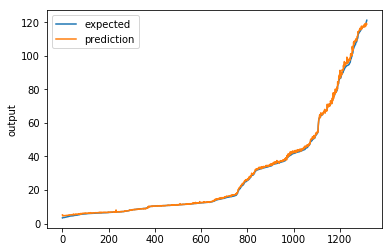

In [120]:
#Regression lift Chart
chart_regression(pred_tanh_3l_rms.flatten(),y_test)

### Tanh, rmsprop, 3 layer and dropout - score_tanh_3l_do

In [121]:
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(50, input_dim=x_train.shape[1]))  
    model_tanh.add(Dropout(0.1))
    model_tanh.add(Dense(25, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 1622.3474 - val_loss: 1464.8293
Epoch 2/100
 - 1s - loss: 1513.0639 - val_loss: 1414.3917
Epoch 3/100
 - 1s - loss: 1462.2931 - val_loss: 1367.9647
Epoch 4/100
 - 1s - loss: 1413.6213 - val_loss: 1324.5658
Epoch 5/100
 - 1s - loss: 1367.0353 - val_loss: 1279.9443
Epoch 6/100
 - 1s - loss: 1320.6240 - val_loss: 1238.0996
Epoch 7/100
 - 1s - loss: 1276.5753 - val_loss: 1198.0474
Epoch 8/100
 - 1s - loss: 1233.9985 - val_loss: 1159.1371
Epoch 9/100
 - 1s - loss: 1192.4905 - val_loss: 1121.3626
Epoch 10/100
 - 1s - loss: 1152.9969 - val_loss: 1084.6218
Epoch 11/100
 - 1s - loss: 1113.7773 - val_loss: 1049.2037
Epoch 12/100
 - 1s - loss: 1075.5307 - val_loss: 1013.2553
Epoch 13/100
 - 1s - loss: 1038.4671 - val_loss: 979.3645
Epoch 14/100
 - 1s - loss: 1002.4056 - val_loss: 946.6690
Epoch 15/100
 - 1s - loss: 966.9058 - val_loss: 914.4445
Epoch 16/100
 - 1s - loss: 933.3532 - val_loss: 882.5573
Epoch 17/100
 - 1s - lo

In [122]:
# Predict stars
pred_tanh_hl3_rms_do = model_tanh.predict(x_test)

In [123]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_3l_rms_do = np.sqrt(mean_squared_error(y_test,pred_tanh_hl3_rms_do))
print("Final score (RMSE): {}".format(score_tanh_3l_rms_do))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_hl3_rms_do))

Final score (RMSE): 3.442368745803833
R2 score: 0.99


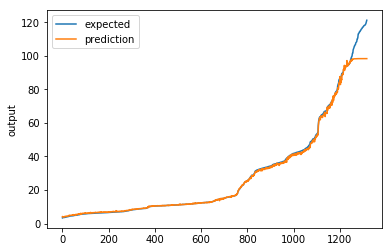

In [124]:
#Regression lift Chart
chart_regression(pred_tanh_hl3_rms_do.flatten(),y_test)

# LSTM

## Data Processing for LSTM

In [ ]:
#Read Stock_Price_MAX.csv file and load data into stock_df dataframe 
stock_df= pd.read_csv('Stock_Price_MAX.csv')
stock_df

In [ ]:
stock_df = stock_df.drop(['Date', 'Adj_Close'], axis = 1)
stock_close_df = stock_df['Close']

In [ ]:
# Normalize the columns
    
normalize_numeric_minmax(stock_df,"Open")
normalize_numeric_minmax(stock_df,"High") 
normalize_numeric_minmax(stock_df,"Low") 
normalize_numeric_minmax(stock_df,"Volume") 
normalize_numeric_minmax(stock_df,"Close") 
stock_df

In [ ]:
print(stock_df[0:7])
print(stock_close_df[0:7])

In [ ]:
x_rnn,y_rnn = to_sequences(7,stock_df,stock_close_df)

In [ ]:
x_rnn[0:5]

In [ ]:
y_rnn[0:5]

In [ ]:
x_rnn.shape[1:3]

In [ ]:
y_rnn.shape

In [ ]:
#Split for train and test
x_train_rnn, x_test_rnn, y_train_rnn, y_test_rnn = train_test_split(x_rnn,y_rnn, test_size=0.3, random_state=42)

In [ ]:
x_train_rnn.shape[1:3]

## LSTM with 1 lstm layer

In [ ]:
# set up checkpointer
checkpointer_lstm = ModelCheckpoint(filepath="./best_weights_lstm.hdf5", verbose=1, save_best_only=True)

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import numpy as np

for i in range(10):
    print(i)
    
    print('Build model...')
    model_lstm = Sequential()

    model_lstm.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=x_train_rnn.shape[1:3]))
    model_lstm.add(Dense(32))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model_lstm.fit(x_train_rnn,y_train_rnn,validation_data=(x_test_rnn,y_test_rnn),callbacks=[monitor,checkpointer_lstm],verbose=2, epochs=10)  

print('Training finished...Loading the best model') 
print()
model_lstm.load_weights('./best_weights_lstm.hdf5')



In [ ]:
pred_rnn = model_lstm.predict(x_test_rnn)

In [ ]:
score_rnn= np.sqrt(mean_squared_error(pred_rnn,y_test_rnn))
print("Score (RMSE): {}".format(score_rnn))
score_rnn_r2= r2_score(pred_rnn,y_test_rnn)
print("Score (R2): {}".format(score_rnn_r2))

In [ ]:
chart_regression(pred_rnn.flatten(),y_test_rnn)

## LSTM with 2 lstm layers

In [ ]:
# set up checkpointer
checkpointer_lstm_2l = ModelCheckpoint(filepath="./best_weights_lstm_2l.hdf5", verbose=1, save_best_only=True)

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import numpy as np

for i in range(10):
    print(i)
    
    print('Build model...')
    model_lstm_2l = Sequential()

    model_lstm_2l.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, input_shape=x_train_rnn.shape[1:3],return_sequences=True))
    model_lstm_2l.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model_lstm_2l.add(Dense(32))
    model_lstm_2l.add(Dense(1))
    model_lstm_2l.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model_lstm_2l.fit(x_train_rnn,y_train_rnn,validation_data=(x_test_rnn,y_test_rnn),callbacks=[monitor,checkpointer_lstm_2l],verbose=2, epochs=10)  

print('Training finished...Loading the best model') 
print()
model_lstm_2l.load_weights('./best_weights_lstm_2l.hdf5')



In [ ]:
pred_rnn_2l = model_lstm_2l.predict(x_test_rnn)

In [ ]:
score_rnn_2l= np.sqrt(mean_squared_error(pred_rnn_2l,y_test_rnn))
print("Score (RMSE): {}".format(score_rnn))
score_rnn_r2_2l= r2_score(pred_rnn_2l,y_test_rnn)
print("Score (R2): {}".format(score_rnn_r2_2l))

In [ ]:
chart_regression(pred_rnn_2l.flatten(),y_test_rnn)

# CNN

## Data Processing

In [495]:
#Read Stock_Price_MAX.csv file and load data into stock_df dataframe 
stock_df= pd.read_csv('Stock_Price_MAX.csv')

In [496]:
stock_df = stock_df.drop(['Date', 'Adj_Close'], axis = 1)

In [497]:
close_df = stock_df[['Close']]

In [498]:
# Normalize the input columns
    
normalize_numeric_minmax(stock_df,"Open")
normalize_numeric_minmax(stock_df,"High") 
normalize_numeric_minmax(stock_df,"Low") 
normalize_numeric_minmax(stock_df,"Volume") 
normalize_numeric_minmax(stock_df,"Close") 

In [499]:
stock_df

,Open,High,Low,Close,Volume
0,0.004378,0.006469,0.006934,0.007408,0.075401
1,0.007031,0.006205,0.008535,0.006482,0.019194
2,0.005970,0.005413,0.008135,0.006350,0.005339
3,0.005970,0.005149,0.007201,0.005027,0.036632
4,0.003714,0.002904,0.003334,0.001191,0.167478
5,0.001725,0.002640,0.003734,0.001588,0.244393
6,0.001990,0.001584,0.000800,0.002117,0.280091
7,0.001459,0.001452,0.003867,0.001984,0.133252
8,0.001725,0.001716,0.004001,0.002778,0.151243
9,0.002521,0.003564,0.005067,0.003043,0.296706


In [500]:
close_df

,Close
0,4.125000
1,4.015625
2,4.000000
3,3.843750
4,3.390625
5,3.437500
6,3.500000
7,3.484375
8,3.578125
9,3.609375


In [501]:
#Create a sliding Window
SEQUENCE_SIZE = 7
x,y = to_sequences(7,stock_df,close_df['Close'])

0
[[0.00437775 0.00646865 0.00693437 0.00740835 0.075401  ]
 [0.00703093 0.00620462 0.00853461 0.0064823  0.01919424]
 [0.00596966 0.00541254 0.00813455 0.00635001 0.00533943]
 [0.00596966 0.00514851 0.00720108 0.00502709 0.03663175]
 [0.00371445 0.00290429 0.00333383 0.00119063 0.16747797]
 [0.00172457 0.00264026 0.00373389 0.0015875  0.2443934 ]
 [0.00198989 0.00158416 0.00080012 0.00211667 0.2800905 ]] - 3.484375
1
[[0.00703093 0.00620462 0.00853461 0.0064823  0.01919424]
 [0.00596966 0.00541254 0.00813455 0.00635001 0.00533943]
 [0.00596966 0.00514851 0.00720108 0.00502709 0.03663175]
 [0.00371445 0.00290429 0.00333383 0.00119063 0.16747797]
 [0.00172457 0.00264026 0.00373389 0.0015875  0.2443934 ]
 [0.00198989 0.00158416 0.00080012 0.00211667 0.2800905 ]
 [0.00145925 0.00145215 0.00386724 0.00198438 0.13325198]] - 3.578125
2
[[0.00596966 0.00541254 0.00813455 0.00635001 0.00533943]
 [0.00596966 0.00514851 0.00720108 0.00502709 0.03663175]
 [0.00371445 0.00290429 0.00333383 0.00119

 [0.02175609 0.02085809 0.02320347 0.02169588 0.00608366]] - 5.921875
140
[[0.01644973 0.01874587 0.01880281 0.01984379 0.02306251]
 [0.01950088 0.01953795 0.02106981 0.01918233 0.02348655]
 [0.01883759 0.01940594 0.02106981 0.02063754 0.01335289]
 [0.01923556 0.01980198 0.02133652 0.02103442 0.01192501]
 [0.02056216 0.02085809 0.02280341 0.02209275 0.00750289]
 [0.02175609 0.02085809 0.02320347 0.02169588 0.00608366]
 [0.02135811 0.02138614 0.02373688 0.02262192 0.01077404]] - 6.046875
141
[[0.01950088 0.01953795 0.02106981 0.01918233 0.02348655]
 [0.01883759 0.01940594 0.02106981 0.02063754 0.01335289]
 [0.01923556 0.01980198 0.02133652 0.02103442 0.01192501]
 [0.02056216 0.02085809 0.02280341 0.02209275 0.00750289]
 [0.02175609 0.02085809 0.02320347 0.02169588 0.00608366]
 [0.02135811 0.02138614 0.02373688 0.02262192 0.01077404]
 [0.02202141 0.02310231 0.02387023 0.02368025 0.02027597]] - 5.96875
142
[[0.01883759 0.01940594 0.02106981 0.02063754 0.01335289]
 [0.01923556 0.01980198 0

 [0.02420232 0.02411617 0.02637194 0.02408771 0.01004712]] - 5.995
301
[[0.02454193 0.02460198 0.02718273 0.02540005 0.02676636]
 [0.02507256 0.02496106 0.02754545 0.02575989 0.04423848]
 [0.02507256 0.02449637 0.02731075 0.02550588 0.01783559]
 [0.02496644 0.02479208 0.02696936 0.02497672 0.01864905]
 [0.02464806 0.02373597 0.02603055 0.02425705 0.01975674]
 [0.02420232 0.02411617 0.02637194 0.02408771 0.01004712]
 [0.02354433 0.02263762 0.02515576 0.02324105 0.00726923]] - 5.97
302
[[0.02507256 0.02496106 0.02754545 0.02575989 0.04423848]
 [0.02507256 0.02449637 0.02731075 0.02550588 0.01783559]
 [0.02496644 0.02479208 0.02696936 0.02497672 0.01864905]
 [0.02464806 0.02373597 0.02603055 0.02425705 0.01975674]
 [0.02420232 0.02411617 0.02637194 0.02408771 0.01004712]
 [0.02354433 0.02263762 0.02515576 0.02324105 0.00726923]
 [0.02237693 0.02202508 0.02464368 0.02302938 0.00996924]] - 6.0075
303
[[0.02507256 0.02449637 0.02731075 0.02550588 0.01783559]
 [0.02496644 0.02479208 0.0269693

 [0.02486031 0.02458086 0.02741743 0.02582338 0.00256154]] - 6.425
411
[[0.0230137  0.02229967 0.02475036 0.02262721 0.01671924]
 [0.02231326 0.02145479 0.02402492 0.02203454 0.01219327]
 [0.02169772 0.02088449 0.02357685 0.02190754 0.01628655]
 [0.02178262 0.02303894 0.02443032 0.02413005 0.02814232]
 [0.02379904 0.02451749 0.02645729 0.02540005 0.00874039]
 [0.02486031 0.02458086 0.02741743 0.02582338 0.00256154]
 [0.02549707 0.02593267 0.02816421 0.02688172 0.00758943]] - 6.225
412
[[0.02231326 0.02145479 0.02402492 0.02203454 0.01219327]
 [0.02169772 0.02088449 0.02357685 0.02190754 0.01628655]
 [0.02178262 0.02303894 0.02443032 0.02413005 0.02814232]
 [0.02379904 0.02451749 0.02645729 0.02540005 0.00874039]
 [0.02486031 0.02458086 0.02741743 0.02582338 0.00256154]
 [0.02549707 0.02593267 0.02816421 0.02688172 0.00758943]
 [0.02655835 0.02567921 0.02711872 0.02518838 0.01131924]] - 6.235
413
[[0.02169772 0.02088449 0.02357685 0.02190754 0.01628655]
 [0.02178262 0.02303894 0.0244303

[[0.02522114 0.02436964 0.02720406 0.02510372 0.02525193]
 [0.02473296 0.02382046 0.0263506  0.02493438 0.01525674]
 [0.02454193 0.02422178 0.02667065 0.02527305 0.00467308]
 [0.02473296 0.02426403 0.02690535 0.02459572 0.00441346]
 [0.02411742 0.02320792 0.0252411  0.02313521 0.01831155]
 [0.02273776 0.02267987 0.02509175 0.02391838 0.01768847]
 [0.02348066 0.02289109 0.02485705 0.02349505 0.01356058]] - 6.1125
607
[[0.02473296 0.02382046 0.0263506  0.02493438 0.01525674]
 [0.02454193 0.02422178 0.02667065 0.02527305 0.00467308]
 [0.02473296 0.02426403 0.02690535 0.02459572 0.00441346]
 [0.02411742 0.02320792 0.0252411  0.02313521 0.01831155]
 [0.02273776 0.02267987 0.02509175 0.02391838 0.01768847]
 [0.02348066 0.02289109 0.02485705 0.02349505 0.01356058]
 [0.0232684  0.02310231 0.02592387 0.02423588 0.00495866]] - 6.2075
608
[[0.02454193 0.02422178 0.02667065 0.02527305 0.00467308]
 [0.02473296 0.02426403 0.02690535 0.02459572 0.00441346]
 [0.02411742 0.02320792 0.0252411  0.0231352

 [0.02613384 0.02551023 0.02827089 0.02656422 0.01760193]] - 6.39
696
[[0.02687673 0.0259538  0.02837757 0.02626789 0.01999905]
 [0.02570933 0.02508779 0.02731075 0.02580222 0.0476481 ]
 [0.02547585 0.02582706 0.02797218 0.02656422 0.03916733]
 [0.02634609 0.02578482 0.02818554 0.02618322 0.02093366]
 [0.02592158 0.02521452 0.02827089 0.02641605 0.01312789]
 [0.02613384 0.02551023 0.02827089 0.02656422 0.01760193]
 [0.02623996 0.02540462 0.0283349  0.02658539 0.0223702 ]] - 6.5
697
[[0.02570933 0.02508779 0.02731075 0.02580222 0.0476481 ]
 [0.02547585 0.02582706 0.02797218 0.02656422 0.03916733]
 [0.02634609 0.02578482 0.02818554 0.02618322 0.02093366]
 [0.02592158 0.02521452 0.02827089 0.02641605 0.01312789]
 [0.02613384 0.02551023 0.02827089 0.02656422 0.01760193]
 [0.02623996 0.02540462 0.0283349  0.02658539 0.0223702 ]
 [0.02628241 0.02627063 0.02884698 0.02751672 0.02063943]] - 6.5025
698
[[0.02547585 0.02582706 0.02797218 0.02656422 0.03916733]
 [0.02634609 0.02578482 0.02818554 

[[0.02961481 0.02867855 0.03151404 0.02956989 0.04118367]
 [0.02925398 0.02897426 0.03194077 0.02992973 0.02978655]
 [0.02952991 0.02899538 0.03138602 0.02980273 0.03413079]
 [0.02952991 0.03007261 0.03211146 0.0309034  0.03099809]
 [0.03059118 0.03060066 0.03307161 0.03151723 0.03879521]
 [0.03163123 0.03123432 0.03360502 0.03139023 0.0351779 ]
 [0.03139775 0.03081188 0.03375437 0.03160189 0.03962598]] - 7.0075
880
[[0.02925398 0.02897426 0.03194077 0.02992973 0.02978655]
 [0.02952991 0.02899538 0.03138602 0.02980273 0.03413079]
 [0.02952991 0.03007261 0.03211146 0.0309034  0.03099809]
 [0.03059118 0.03060066 0.03307161 0.03151723 0.03879521]
 [0.03163123 0.03123432 0.03360502 0.03139023 0.0351779 ]
 [0.03139775 0.03081188 0.03375437 0.03160189 0.03962598]
 [0.03129162 0.03055842 0.03298626 0.03181356 0.04572694]] - 7.36
881
[[0.02952991 0.02899538 0.03138602 0.02980273 0.03413079]
 [0.02952991 0.03007261 0.03211146 0.0309034  0.03099809]
 [0.03059118 0.03060066 0.03307161 0.03151723 

 [0.04417547 0.04447789 0.04683366 0.04563542 0.01566347]] - 8.6425
1100
[[0.04396322 0.04306271 0.04593753 0.04366692 0.00636923]
 [0.04341136 0.04348515 0.04617223 0.04421725 0.02985578]
 [0.04406934 0.04325281 0.04623624 0.04402675 0.01551635]
 [0.04375096 0.04356964 0.04625757 0.04453475 0.01464231]
 [0.04417547 0.04348515 0.04672698 0.04445009 0.01446058]
 [0.04417547 0.04447789 0.04683366 0.04563542 0.01566347]
 [0.04523674 0.04473135 0.04794316 0.04565659 0.01347405]] - 8.6625
1101
[[0.04341136 0.04348515 0.04617223 0.04421725 0.02985578]
 [0.04406934 0.04325281 0.04623624 0.04402675 0.01551635]
 [0.04375096 0.04356964 0.04625757 0.04453475 0.01464231]
 [0.04417547 0.04348515 0.04672698 0.04445009 0.01446058]
 [0.04417547 0.04447789 0.04683366 0.04563542 0.01566347]
 [0.04523674 0.04473135 0.04794316 0.04565659 0.01347405]
 [0.0457037  0.0449637  0.04800717 0.04582592 0.01272981]] - 8.7175
1102
[[0.04406934 0.04325281 0.04623624 0.04402675 0.01551635]
 [0.04375096 0.04356964 0.0

 [0.05975495 0.05953795 0.06159853 0.05903395 0.02028462]] - 10.1825
1208
[[0.05903329 0.05987591 0.06155586 0.06115062 0.02564136]
 [0.06081622 0.05974917 0.06230264 0.05992295 0.01519616]
 [0.05945779 0.05890429 0.06110779 0.05903395 0.03576636]
 [0.05894838 0.05820726 0.06142784 0.05933028 0.0242827 ]
 [0.05909696 0.05998152 0.06187591 0.05998645 0.05081541]
 [0.05975495 0.05953795 0.06159853 0.05903395 0.02028462]
 [0.05882103 0.05839736 0.06097977 0.05869528 0.02898175]] - 10.2825
1209
[[0.06081622 0.05974917 0.06230264 0.05992295 0.01519616]
 [0.05945779 0.05890429 0.06110779 0.05903395 0.03576636]
 [0.05894838 0.05820726 0.06142784 0.05933028 0.0242827 ]
 [0.05909696 0.05998152 0.06187591 0.05998645 0.05081541]
 [0.05975495 0.05953795 0.06159853 0.05903395 0.02028462]
 [0.05882103 0.05839736 0.06097977 0.05869528 0.02898175]
 [0.05803569 0.05869307 0.06080908 0.05954195 0.03453752]] - 10.0425
1210
[[0.05945779 0.05890429 0.06110779 0.05903395 0.03576636]
 [0.05894838 0.05820726 

 [0.06561317 0.0648396  0.06731672 0.06487596 0.01518751]] - 11.0025
1379
[[0.0645519  0.06344555 0.06614321 0.0639023  0.02178174]
 [0.0633845  0.0634033  0.06614321 0.0647278  0.02824617]
 [0.06423352 0.06312871 0.06659128 0.06417746 0.01907309]
 [0.06423352 0.06422706 0.06663395 0.0651088  0.0205702 ]
 [0.06531602 0.06443828 0.0673594  0.06565913 0.01647693]
 [0.06561317 0.0648396  0.06731672 0.06487596 0.01518751]
 [0.06476416 0.06433267 0.06691132 0.06563796 0.01202885]] - 11.1025
1380
[[0.0633845  0.0634033  0.06614321 0.0647278  0.02824617]
 [0.06423352 0.06312871 0.06659128 0.06417746 0.01907309]
 [0.06423352 0.06422706 0.06663395 0.0651088  0.0205702 ]
 [0.06531602 0.06443828 0.0673594  0.06565913 0.01647693]
 [0.06561317 0.0648396  0.06731672 0.06487596 0.01518751]
 [0.06476416 0.06433267 0.06691132 0.06563796 0.01202885]
 [0.06518867 0.06517756 0.06721004 0.06648463 0.01943655]] - 11.0475
1381
[[0.06423352 0.06312871 0.06659128 0.06417746 0.01907309]
 [0.06423352 0.06422706 

[[0.07174733 0.07081717 0.07363233 0.07137414 0.01238366]
 [0.07091954 0.07050033 0.07286421 0.07116248 0.01073943]
 [0.0711318  0.07028911 0.07367501 0.07133181 0.01594905]
 [0.07111057 0.07016238 0.07314159 0.0708873  0.01986059]
 [0.07047381 0.06957096 0.07254416 0.07040048 0.00917308]
 [0.07019787 0.06973993 0.0725655  0.0708873  0.01787885]
 [0.07053748 0.07012013 0.0730349  0.07135297 0.01247885]] - 11.69
1629
[[0.07091954 0.07050033 0.07286421 0.07116248 0.01073943]
 [0.0711318  0.07028911 0.07367501 0.07133181 0.01594905]
 [0.07111057 0.07016238 0.07314159 0.0708873  0.01986059]
 [0.07047381 0.06957096 0.07254416 0.07040048 0.00917308]
 [0.07019787 0.06973993 0.0725655  0.0708873  0.01787885]
 [0.07053748 0.07012013 0.0730349  0.07135297 0.01247885]
 [0.07115301 0.07058482 0.07393104 0.07145881 0.02223174]] - 11.69
1630
[[0.0711318  0.07028911 0.07367501 0.07133181 0.01594905]
 [0.07111057 0.07016238 0.07314159 0.0708873  0.01986059]
 [0.07047381 0.06957096 0.07254416 0.0704004

 [0.07323311 0.07316171 0.07506188 0.07444332 0.02446443]] - 12.1925
1874
[[0.0740609  0.07316171 0.07627806 0.07446449 0.01339616]
 [0.07393355 0.07406997 0.07685415 0.07484549 0.02252597]
 [0.07507972 0.07392211 0.07617138 0.07359665 0.0170827 ]
 [0.07276616 0.07292937 0.07529658 0.07380831 0.01502308]
 [0.07350904 0.07292937 0.07557395 0.07294048 0.00536539]
 [0.07323311 0.07316171 0.07506188 0.07444332 0.02446443]
 [0.0748887  0.07478812 0.07757959 0.07571331 0.03830194]] - 12.215
1875
[[0.07393355 0.07406997 0.07685415 0.07484549 0.02252597]
 [0.07507972 0.07392211 0.07617138 0.07359665 0.0170827 ]
 [0.07276616 0.07292937 0.07529658 0.07380831 0.01502308]
 [0.07350904 0.07292937 0.07557395 0.07294048 0.00536539]
 [0.07323311 0.07316171 0.07506188 0.07444332 0.02446443]
 [0.0748887  0.07478812 0.07757959 0.07571331 0.03830194]
 [0.07548301 0.07476699 0.07815567 0.07590382 0.02610867]] - 12.1875
1876
[[0.07507972 0.07392211 0.07617138 0.07359665 0.0170827 ]
 [0.07276616 0.07292937 0

[[0.07435806 0.07345743 0.07666212 0.07452798 0.01414905]
 [0.0737213  0.07297162 0.07587267 0.07410464 0.02693944]
 [0.07340292 0.0740066  0.07480584 0.07520532 0.04158175]
 [0.08291192 0.09244621 0.08587949 0.08870967 0.26452225]
 [0.08843054 0.0895736  0.09010413 0.09006435 0.09779716]
 [0.08997999 0.09107327 0.09238713 0.09103801 0.0757558 ]
 [0.09184783 0.09111551 0.09302723 0.09156718 0.03303175]] - 13.9675
2027
[[0.0737213  0.07297162 0.07587267 0.07410464 0.02693944]
 [0.07340292 0.0740066  0.07480584 0.07520532 0.04158175]
 [0.08291192 0.09244621 0.08587949 0.08870967 0.26452225]
 [0.08843054 0.0895736  0.09010413 0.09006435 0.09779716]
 [0.08997999 0.09107327 0.09238713 0.09103801 0.0757558 ]
 [0.09184783 0.09111551 0.09302723 0.09156718 0.03303175]
 [0.091487   0.09024951 0.09311257 0.09074168 0.03020194]] - 13.855
2028
[[0.07340292 0.0740066  0.07480584 0.07520532 0.04158175]
 [0.08291192 0.09244621 0.08587949 0.08870967 0.26452225]
 [0.08843054 0.0895736  0.09010413 0.0900

2172
[[0.08690231 0.08714455 0.08474866 0.08851918 0.05636253]
 [0.08662637 0.088433   0.08773577 0.08532301 0.04177213]
 [0.08450383 0.08393399 0.08519673 0.08244433 0.02355578]
 [0.08132001 0.08292013 0.07926517 0.07935399 0.0504606 ]
 [0.07813619 0.07901254 0.07666212 0.07393532 0.03833656]
 [0.07304208 0.07297162 0.06989844 0.06773347 0.05303945]
 [0.06958234 0.07398548 0.07013314 0.07533231 0.1142914 ]] - 12.51
2173
[[0.08662637 0.088433   0.08773577 0.08532301 0.04177213]
 [0.08450383 0.08393399 0.08519673 0.08244433 0.02355578]
 [0.08132001 0.08292013 0.07926517 0.07935399 0.0504606 ]
 [0.07813619 0.07901254 0.07666212 0.07393532 0.03833656]
 [0.07304208 0.07297162 0.06989844 0.06773347 0.05303945]
 [0.06958234 0.07398548 0.07013314 0.07533231 0.1142914 ]
 [0.07567404 0.07770297 0.0770035  0.07840149 0.05194907]] - 12.25
2174
[[0.08450383 0.08393399 0.08519673 0.08244433 0.02355578]
 [0.08132001 0.08292013 0.07926517 0.07935399 0.0504606 ]
 [0.07813619 0.07901254 0.07666212 0.07

[[0.10891309 0.10940726 0.11124861 0.10983405 0.02425674]
 [0.10912535 0.1097452  0.11167534 0.11116754 0.01876155]
 [0.11209691 0.1120264  0.11419304 0.11220473 0.02179039]
 [0.11245774 0.11291353 0.11521721 0.11434256 0.02378078]
 [0.11364638 0.11276567 0.11464113 0.11167557 0.02463751]
 [0.1151746  0.11496237 0.11754288 0.11531623 0.05341157]
 [0.1159175  0.11496237 0.11745755 0.1150834  0.02497501]] - 16.815001000000002
2378
[[0.10912535 0.1097452  0.11167534 0.11116754 0.01876155]
 [0.11209691 0.1120264  0.11419304 0.11220473 0.02179039]
 [0.11245774 0.11291353 0.11521721 0.11434256 0.02378078]
 [0.11364638 0.11276567 0.11464113 0.11167557 0.02463751]
 [0.1151746  0.11496237 0.11754288 0.11531623 0.05341157]
 [0.1159175  0.11496237 0.11745755 0.1150834  0.02497501]
 [0.11528073 0.11420197 0.1167961  0.11485057 0.03002886]] - 16.9125
2379
[[0.11209691 0.1120264  0.11419304 0.11220473 0.02179039]
 [0.11245774 0.11291353 0.11521721 0.11434256 0.02378078]
 [0.11364638 0.11276567 0.114

2627
[[0.23091699 0.2314086  0.23179996 0.23050547 0.01214568]
 [0.23036513 0.22946534 0.2294956  0.22644146 0.04008896]
 [0.22862464 0.22701518 0.22855681 0.22546777 0.02126251]
 [0.22552574 0.22443828 0.22620977 0.22237743 0.03657982]
 [0.22484651 0.22414258 0.2192114  0.21551943 0.05842214]
 [0.2143187  0.21379274 0.20922591 0.21378376 0.07308177]
 [0.21380928 0.21603167 0.21665102 0.21653543 0.06537551]] - 29.155001000000002
2628
[[0.23036513 0.22946534 0.2294956  0.22644146 0.04008896]
 [0.22862464 0.22701518 0.22855681 0.22546777 0.02126251]
 [0.22552574 0.22443828 0.22620977 0.22237743 0.03657982]
 [0.22484651 0.22414258 0.2192114  0.21551943 0.05842214]
 [0.2143187  0.21379274 0.20922591 0.21378376 0.07308177]
 [0.21380928 0.21603167 0.21665102 0.21653543 0.06537551]
 [0.21610162 0.22034058 0.21976615 0.21932945 0.04233896]] - 27.905001000000002
2629
[[0.22862464 0.22701518 0.22855681 0.22546777 0.02126251]
 [0.22552574 0.22443828 0.22620977 0.22237743 0.03657982]
 [0.22484651 

 [0.2667031  0.26900595 0.26546898 0.2660232  0.0489505 ]] - 34.279999
2859
[[0.2536282  0.25498086 0.24524197 0.24312082 0.10261303]
 [0.2481945  0.2513901  0.23739013 0.25201082 0.11523899]
 [0.24755776 0.24860197 0.24178544 0.23846415 0.05502118]
 [0.24000148 0.25371352 0.24379109 0.25226483 0.03310098]
 [0.2578733  0.26892146 0.26051894 0.26521888 0.06202647]
 [0.2667031  0.26900595 0.26546898 0.2660232  0.0489505 ]
 [0.2648777  0.26288053 0.26248187 0.26272118 0.02814665]] - 34.509997999999996
2860
[[0.2481945  0.2513901  0.23739013 0.25201082 0.11523899]
 [0.24755776 0.24860197 0.24178544 0.23846415 0.05502118]
 [0.24000148 0.25371352 0.24379109 0.25226483 0.03310098]
 [0.2578733  0.26892146 0.26051894 0.26521888 0.06202647]
 [0.2667031  0.26900595 0.26546898 0.2660232  0.0489505 ]
 [0.2648777  0.26288053 0.26248187 0.26272118 0.02814665]
 [0.2647079  0.26685145 0.26743194 0.26466852 0.02723367]] - 33.599998
2861
[[0.24755776 0.24860197 0.24178544 0.23846415 0.05502118]
 [0.24000

 [0.31620085 0.3150099  0.3156525  0.31398696 0.0492707 ]] - 35.77
2977
[[0.30737105 0.3054627  0.30724588 0.30382693 0.0292803 ]
 [0.30435705 0.3071947  0.30724588 0.30767927 0.03105434]
 [0.3047391  0.30474454 0.30630708 0.30382693 0.02900771]
 [0.31178597 0.32603565 0.3159512  0.32245365 0.12480583]
 [0.32210153 0.32354325 0.32230946 0.318305   0.0837736 ]
 [0.31620085 0.3150099  0.3156525  0.31398696 0.0492707 ]
 [0.2788016  0.28818482 0.27737477 0.27533653 0.2850535 ]] - 36.259997999999996
2978
[[0.30435705 0.3071947  0.30724588 0.30767927 0.03105434]
 [0.3047391  0.30474454 0.30630708 0.30382693 0.02900771]
 [0.31178597 0.32603565 0.3159512  0.32245365 0.12480583]
 [0.32210153 0.32354325 0.32230946 0.318305   0.0837736 ]
 [0.31620085 0.3150099  0.3156525  0.31398696 0.0492707 ]
 [0.2788016  0.28818482 0.27737477 0.27533653 0.2850535 ]
 [0.27481124 0.27969372 0.27387556 0.2794852  0.07734811]] - 36.814999
2979
[[0.3047391  0.30474454 0.30630708 0.30382693 0.02900771]
 [0.31178597 

 [0.39651796 0.40000528 0.39630452 0.40038946 0.03700819]] - 50.91
3121
[[0.3942256  0.39493597 0.3977981  0.39442044 0.02373751]
 [0.39431053 0.3940911  0.39681658 0.39416644 0.01568078]
 [0.39515954 0.39911816 0.39613384 0.39285412 0.02611299]
 [0.39176345 0.39168316 0.39259195 0.3923461  0.01520914]
 [0.3959661  0.39611882 0.3977127  0.39691812 0.01557693]
 [0.39651796 0.40000528 0.39630452 0.40038946 0.03700819]
 [0.40118754 0.40714458 0.40390033 0.40352213 0.03191107]] - 51.0
3122
[[0.39431053 0.3940911  0.39681658 0.39416644 0.01568078]
 [0.39515954 0.39911816 0.39613384 0.39285412 0.02611299]
 [0.39176345 0.39168316 0.39259195 0.3923461  0.01520914]
 [0.3959661  0.39611882 0.3977127  0.39691812 0.01557693]
 [0.39651796 0.40000528 0.39630452 0.40038946 0.03700819]
 [0.40118754 0.40714458 0.40390033 0.40352213 0.03191107]
 [0.4033101  0.4046944  0.40364426 0.40428415 0.0266279 ]] - 51.055
3123
[[0.39515954 0.39911816 0.39613384 0.39285412 0.02611299]
 [0.39176345 0.39168316 0.3925

[[0.34328452 0.34284887 0.34313393 0.34103802 0.02962646]
 [0.34120443 0.33972275 0.34168303 0.33803234 0.02594424]
 [0.33971867 0.33786404 0.3402748  0.33807468 0.02568896]
 [0.3394215  0.3387089  0.34151232 0.339514   0.03367213]
 [0.33937904 0.3387089  0.3427072  0.33820167 0.02780915]
 [0.33729896 0.33803302 0.33754373 0.335196   0.04064281]
 [0.3362377  0.33655444 0.33831185 0.338117   0.02552021]] - 43.25
3241
[[0.34120443 0.33972275 0.34168303 0.33803234 0.02594424]
 [0.33971867 0.33786404 0.3402748  0.33807468 0.02568896]
 [0.3394215  0.3387089  0.34151232 0.339514   0.03367213]
 [0.33937904 0.3387089  0.3427072  0.33820167 0.02780915]
 [0.33729896 0.33803302 0.33754373 0.335196   0.04064281]
 [0.3362377  0.33655444 0.33831185 0.338117   0.02552021]
 [0.33937904 0.34622836 0.34334728 0.33866733 0.04847887]] - 43.400002
3242
[[0.33971867 0.33786404 0.3402748  0.33807468 0.02568896]
 [0.3394215  0.3387089  0.34151232 0.339514   0.03367213]
 [0.33937904 0.3387089  0.3427072  0.338

3376
[[0.2737924  0.27369505 0.27434498 0.27097622 0.03002453]
 [0.27048123 0.2709914  0.27417427 0.27173823 0.02024136]
 [0.2720519  0.27111816 0.2736622  0.27042586 0.02742405]
 [0.27383485 0.27352607 0.2737049  0.27118787 0.03735435]
 [0.27124533 0.27314588 0.274729   0.27457455 0.03230049]
 [0.27442914 0.2768211  0.2783989  0.27639487 0.02612597]
 [0.27833468 0.27665213 0.27912438 0.2750402  0.03906348]] - 35.860001000000004
3377
[[0.27048123 0.2709914  0.27417427 0.27173823 0.02024136]
 [0.2720519  0.27111816 0.2736622  0.27042586 0.02742405]
 [0.27383485 0.27352607 0.2737049  0.27118787 0.03735435]
 [0.27124533 0.27314588 0.274729   0.27457455 0.03230049]
 [0.27442914 0.2768211  0.2783989  0.27639487 0.02612597]
 [0.27833468 0.27665213 0.27912438 0.2750402  0.03906348]
 [0.27595738 0.27517357 0.2794231  0.27609855 0.04036156]] - 36.055
3378
[[0.2720519  0.27111816 0.2736622  0.27042586 0.02742405]
 [0.27383485 0.27352607 0.2737049  0.27118787 0.03735435]
 [0.27124533 0.27314588 0

[[0.33250198 0.3344     0.3362209  0.3361697  0.01429183]
 [0.3360679  0.34390497 0.3401041  0.3444247  0.06099234]
 [0.3440911  0.34259537 0.3401895  0.3358733  0.03734136]
 [0.33746874 0.339934   0.34176835 0.3413767  0.02785242]
 [0.34154406 0.3429756  0.34573695 0.34400135 0.02054424]
 [0.34438825 0.34394717 0.34778526 0.34539834 0.02436924]
 [0.343327   0.34221518 0.34577963 0.34260434 0.0149452 ]] - 43.470001
3585
[[0.3360679  0.34390497 0.3401041  0.3444247  0.06099234]
 [0.3440911  0.34259537 0.3401895  0.3358733  0.03734136]
 [0.33746874 0.339934   0.34176835 0.3413767  0.02785242]
 [0.34154406 0.3429756  0.34573695 0.34400135 0.02054424]
 [0.34438825 0.34394717 0.34778526 0.34539834 0.02436924]
 [0.343327   0.34221518 0.34577963 0.34260434 0.0149452 ]
 [0.3416714  0.34048316 0.3442434  0.34053    0.01770578]] - 43.945
3586
[[0.3440911  0.34259537 0.3401895  0.3358733  0.03734136]
 [0.33746874 0.339934   0.34176835 0.3413767  0.02785242]
 [0.34154406 0.3429756  0.34573695 0.34

[[0.540851   0.5458746  0.5447213  0.5427568  0.036913  ]
 [0.5453508  0.55187327 0.54933    0.5524511  0.04643656]
 [0.55294955 0.5515353  0.54787916 0.5454661  0.04141733]
 [0.5535863  0.6037914  0.5590168  0.6017272  0.12374573]
 [0.59815973 0.5997782  0.59968424 0.59944123 0.045013  ]
 [0.6002823  0.6048053  0.60403687 0.6006265  0.05372743]
 [0.5971834  0.60214394 0.60279936 0.6029972  0.03418271]] - 73.385002
3762
[[0.5453508  0.55187327 0.54933    0.5524511  0.04643656]
 [0.55294955 0.5515353  0.54787916 0.5454661  0.04141733]
 [0.5535863  0.6037914  0.5590168  0.6017272  0.12374573]
 [0.59815973 0.5997782  0.59968424 0.59944123 0.045013  ]
 [0.6002823  0.6048053  0.60403687 0.6006265  0.05372743]
 [0.5971834  0.60214394 0.60279936 0.6029972  0.03418271]
 [0.60788095 0.6067485  0.60045236 0.59381086 0.0722034 ]] - 73.050003
3763
[[0.55294955 0.5515353  0.54787916 0.5454661  0.04141733]
 [0.5535863  0.6037914  0.5590168  0.6017272  0.12374573]
 [0.59815973 0.5997782  0.59968424 0

 [0.62753576 0.6429941  0.6264829  0.6199729  0.03606492]] - 76.635002
3928
[[0.63428545 0.64497954 0.64013827 0.64410293 0.02969136]
 [0.6451104  0.6418957  0.6388154  0.6378376  0.02188559]
 [0.6389126  0.6380515  0.6352309  0.6378799  0.01989087]
 [0.63980407 0.63927656 0.6380046  0.63953096 0.01851491]
 [0.6410352  0.6430363  0.6428693  0.63881123 0.0166803 ]
 [0.62753576 0.6429941  0.6264829  0.6199729  0.03606492]
 [0.62244165 0.62723696 0.62511736 0.6213276  0.02661492]] - 77.355003
3929
[[0.6451104  0.6418957  0.6388154  0.6378376  0.02188559]
 [0.6389126  0.6380515  0.6352309  0.6378799  0.01989087]
 [0.63980407 0.63927656 0.6380046  0.63953096 0.01851491]
 [0.6410352  0.6430363  0.6428693  0.63881123 0.0166803 ]
 [0.62753576 0.6429941  0.6264829  0.6199729  0.03606492]
 [0.62244165 0.62723696 0.62511736 0.6213276  0.02661492]
 [0.6222294  0.625505   0.62195957 0.6274236  0.01931972]] - 77.379997
3930
[[0.6389126  0.6380515  0.6352309  0.6378799  0.01989087]
 [0.63980407 0.639

4125
[[0.927324   0.95454526 0.9325766  0.94572854 0.04545867]
 [0.94804007 0.9705135  0.95536405 0.9721446  0.07791711]
 [0.9788594  0.9760898  0.96586156 0.9630006  0.02532549]
 [0.96935046 0.96764094 0.9707263  0.9644399  0.02076708]
 [0.967143   0.96476835 0.94879234 0.94022524 0.02806876]
 [0.9413328  0.9455894  0.9417086  0.9442045  0.02111539]
 [0.947276   0.9502363  0.9508407  0.94835323 0.0170416 ]] - 116.099998
4126
[[0.94804007 0.9705135  0.95536405 0.9721446  0.07791711]
 [0.9788594  0.9760898  0.96586156 0.9630006  0.02532549]
 [0.96935046 0.96764094 0.9707263  0.9644399  0.02076708]
 [0.967143   0.96476835 0.94879234 0.94022524 0.02806876]
 [0.9413328  0.9455894  0.9417086  0.9442045  0.02111539]
 [0.947276   0.9502363  0.9508407  0.94835323 0.0170416 ]
 [0.94999284 0.95868516 0.95732695 0.9554652  0.01124135]] - 115.33000200000001
4127
[[0.9788594  0.9760898  0.96586156 0.9630006  0.02532549]
 [0.96935046 0.96764094 0.9707263  0.9644399  0.02076708]
 [0.967143   0.964768

 [0.9398895  0.93452144 0.93428355 0.9267632  0.04075098]] - 112.75
4375
[[0.9502475  0.9508277  0.9558761  0.9509779  0.0162952 ]
 [0.95253986 0.94964486 0.94187933 0.93404454 0.01711515]
 [0.9345407  0.93122643 0.933174   0.93014985 0.02042741]
 [0.93267286 0.9428858  0.9349663  0.9395479  0.01944087]
 [0.94031405 0.94373065 0.9456346  0.9395479  0.02688751]
 [0.9398895  0.93452144 0.93428355 0.9267632  0.04075098]
 [0.9294466  0.92995906 0.9308697  0.92710185 0.02334376]] - 111.760002
4376
[[0.95253986 0.94964486 0.94187933 0.93404454 0.01711515]
 [0.9345407  0.93122643 0.933174   0.93014985 0.02042741]
 [0.93267286 0.9428858  0.9349663  0.9395479  0.01944087]
 [0.94031405 0.94373065 0.9456346  0.9395479  0.02688751]
 [0.9398895  0.93452144 0.93428355 0.9267632  0.04075098]
 [0.9294466  0.92995906 0.9308697  0.92710185 0.02334376]
 [0.9309748  0.9294522  0.9278826  0.9187198  0.02198078]] - 113.110001
4377
[[0.9345407  0.93122643 0.933174   0.93014985 0.02042741]
 [0.93267286 0.9428

In [502]:
x.shape

(4384, 7, 5)

In [503]:
y.shape

(4384,)

In [504]:
#Split for train and test
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = train_test_split(x,y, test_size=0.3, random_state=42)

In [505]:
x_train_cnn.shape

(3068, 7, 5)

In [506]:
x_test_cnn.shape

(1316, 7, 5)

In [507]:
y_train_cnn.shape

(3068,)

In [508]:
y_train_cnn

array([ 5.9375  , 66.5     , 62.794998, ..., 50.544998, 69.375   ,
        6.9975  ])

In [509]:
y_test_cnn.shape

(1316,)

In [510]:
data_rows, data_cols, data_channels = 1,7,5

In [511]:
x_train_cnn = x_train_cnn.reshape(x_train_cnn.shape[0], data_rows, data_cols, data_channels)
x_test_cnn = x_test_cnn.reshape(x_test_cnn.shape[0], data_rows, data_cols,data_channels)

In [512]:
x_train_cnn.shape

(3068, 1, 7, 5)

In [513]:
x_test_cnn.shape

(1316, 1, 7, 5)

In [514]:
y_test_cnn.shape

(1316,)

In [515]:
y_train_cnn.shape

(3068,)

In [516]:
y_train_cnn

array([ 5.9375  , 66.5     , 62.794998, ..., 50.544998, 69.375   ,
        6.9975  ])

In [517]:
input_shape = (data_rows, data_cols, data_channels)

In [529]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn.hdf5", verbose=1, save_best_only=True)


In [538]:
for i in range(10):
    print(i)
    
    model_cnn = Sequential()
    #Filter dim equal to depth
    model_cnn.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1, activation='softmax'))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train_cnn, y_train_cnn, 
            batch_size=128, 
            callbacks=[monitor, checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test_cnn, y_test_cnn))

print('Training finished...Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn.hdf5')


0
Train on 3068 samples, validate on 1316 samples
Epoch 1/100
 - 12s - loss: 1831.8274 - val_loss: 1622.6420

Epoch 00001: val_loss did not improve from 1622.64203
Epoch 2/100
 - 1s - loss: 1831.8275 - val_loss: 1622.6420

Epoch 00002: val_loss did not improve from 1622.64203
Epoch 3/100
 - 1s - loss: 1831.8274 - val_loss: 1622.6420

Epoch 00003: val_loss did not improve from 1622.64203
Epoch 4/100
 - 1s - loss: 1831.8274 - val_loss: 1622.6420

Epoch 00004: val_loss did not improve from 1622.64203
Epoch 5/100
 - 1s - loss: 1831.8274 - val_loss: 1622.6420

Epoch 00005: val_loss did not improve from 1622.64203
Epoch 6/100
 - 1s - loss: 1831.8274 - val_loss: 1622.6420

Epoch 00006: val_loss did not improve from 1622.64203
Epoch 00006: early stopping
1
Train on 3068 samples, validate on 1316 samples
Epoch 1/100
 - 11s - loss: 1831.8274 - val_loss: 1622.6420

Epoch 00001: val_loss did not improve from 1622.64203
Epoch 2/100
 - 1s - loss: 1831.8274 - val_loss: 1622.6420

Epoch 00002: val_los

KeyboardInterrupt: 

In [531]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_312 (Conv2D)          (None, 1, 3, 32)          832       
_________________________________________________________________
conv2d_313 (Conv2D)          (None, 1, 3, 64)          2112      
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 1, 3, 64)          0         
_________________________________________________________________
dropout_165 (Dropout)        (None, 1, 3, 64)          0         
_________________________________________________________________
flatten_112 (Flatten)        (None, 192)               0         
_________________________________________________________________
dense_972 (Dense)            (None, 10)                1930      
_________________________________________________________________
dense_973 (Dense)            (None, 1)                 11        
Total para

In [534]:
pred_cnn = model_cnn.predict(x_test_cnn)
pred_cnn.flatten()

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [535]:
y_test_cnn[0:5]

array([ 6.5125  , 20.16    ,  6.32    , 27.235001, 10.6725  ])

In [536]:
score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test_cnn))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test_cnn)
print("Score (R2): {}".format(score_cnn_r2))

Score (RMSE): 40.28203188581865
Score (R2): 0.0


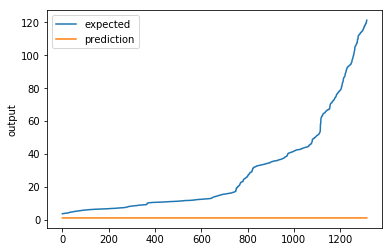

In [537]:
chart_regression(pred_cnn.flatten(),y_test_cnn)

# Additional Features

## Best N Value

## Yahoo Finance Data. Good Model for stock price prediction

## Predict Stock Prices for Continuese time Period